# Data Cleaning
* Rare Encoding 'city' (top 8 labels)
* Creating groups for 'experience' and converting it to ordinal.
* Converting the rest to ordinal for Null filling.

# Feature Selection
 * chi_squared
 * mutual_info_classif

# Model Test
 * GaussianNB
 * Logistic Regression
 * Extreme Tree Classifier
 * Decision Tree Classifier
 * Random Forest
 * KNeighbors
 * SVC\
 
# Model Train
 For deployment

In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.encoding import RareLabelEncoder, OneHotEncoder
from feature_engine.discretisation import EqualFrequencyDiscretiser
from sklearn.preprocessing import RobustScaler

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif


from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, KFold, cross_validate

from sklearn import metrics
from scipy import stats

# Data Cleaning

In [14]:
def Data_Cleaning(data_, scale = False, normalize = False):
    """
    Function that takes the dataset 
    and convert categorical features to ordinal,
    fill nulls, standardize data and create dummies.
    """
    data = data_.copy()
    
    
    cat = 'gender'
    data[cat].replace({"Male":1, 
                       "Female":2, 
                       "Other":3},
                      inplace=True)
    
    
    cat = 'enrolled_university'
    data[cat].isnull().mean()*100
    data[cat].replace({"no_enrollment":0, 
                       'Full time course':2, 
                       'Part time course':1}, 
                      inplace = True)
    
    
    cat = 'education_level'
    data[cat].replace({"Primary School": 0, 
                       "High School": 1, 
                       "Graduate": 2, 
                       "Masters": 3, 
                       "Phd": 4},
                      inplace =True)
    
    
    cat= "major_discipline"
    data[cat].replace({'STEM':0, 
                       'Business Degree':1, 
                       'Humanities': 2,
                       'Arts':3, 
                       'No Major':4 ,
                       'Other':5},
                      inplace = True)
    
    
    cat = 'experience'
    def Create_Groups(x):
        if x in ['<1','1','2','3','4']:
            return '0-5'
        elif x in ['5','6','7','8','9']:
            return '5-10'
        elif x in ['10','11','12','13','14']:
            return '10-15'
        elif x in ['15','16','17','18','19']:
            return '15-20'
        elif x in ['20','>20']:
            return '20+'
        else: return x
        
    data[cat] = data[cat].apply(Create_Groups)
    data[cat].replace({'0-5': 0, 
                       '5-10':1, 
                       '10-15':2, 
                       '15-20':3,
                       '20+':4},
                      inplace=True)
    
    
    cat = 'last_new_job'
    data[cat].replace({'never':0,
                       '1':1, 
                       '2':2, 
                       '3':3, 
                       '4':4,
                       '>4':5}, 
                      inplace = True)
    
    
    cat = 'company_size'
    data[cat].replace({'<10':0, 
                       '10/49':1, 
                       '50-99':2, 
                       '100-500':3, 
                       '500-999':4,
                       '1000-4999':5,
                       '5000-9999':6, 
                       '10000+':7},
                      inplace=True)
    
    
    cat = 'company_type'
    data[cat].replace({'Pvt Ltd':0, 
                       'Funded Startup':1,
                       'Early Stage Startup':2,
                       'Public Sector':3,
                       'NGO':4,
                       'Other':5},
                      inplace=True)

    cat = 'city'
    rare_encoder = RareLabelEncoder(tol=0.02,
                                    n_categories=8,
                                    variables=cat,
                                    replace_with='Other')
    rare_encoder.fit(data)
    data = rare_encoder.transform(data)
    data[cat].replace({'city_103':0, 
                       'city_21':1,
                       'city_16':2,
                       'city_114':3,
                       'city_160':4,
                       'city_136':5,
                       'city_67':6,
                       'Other':7},
                      inplace=True)

    
    cat = 'city_development_index'
    bins = 6
    disc = EqualFrequencyDiscretiser(q=bins)
    disc.fit(pd.DataFrame(data[cat]))
    data[cat] = disc.transform(pd.DataFrame(data[cat]))
    
    cat = 'relevent_experience'
    data[cat] = data[cat].apply(lambda x: 1 if 'Has' in x else 0) 
    
    

    null_columns = data.isnull().mean()*100
    null_columns = null_columns[null_columns > 0].index.to_list()
    #null_columns = ['gender', 'enrolled_university', 
    #'education_level', 'major_discipline', 'experience', 
    #'company_size', 'company_type', 'last_new_job']
    
    #Using IterativeImputer to fill nulls
    imputer = IterativeImputer(max_iter=200,random_state=0)
    for col in null_columns:
        data[col] = imputer.fit_transform(data[[col]])
        data[col] = round(data[col])
    
    if scale:
        cat = 'training_hours'
        if normalize:
            data[cat] =  data[cat] ** (1/3)
        scaler = RobustScaler().fit(data[[cat]])
        data[cat] = scaler.transform(data[[cat]])
        data[cat] =  data[cat] + data[cat].max()
    return data

In [15]:
data_cleaned = Data_Cleaning(pd.read_csv('z_train.csv'), scale =True, normalize = True)

# Feature Selection

In [16]:
X = data_cleaned.drop(['target','enrollee_id'], axis = 1) 
y = data_cleaned['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2)

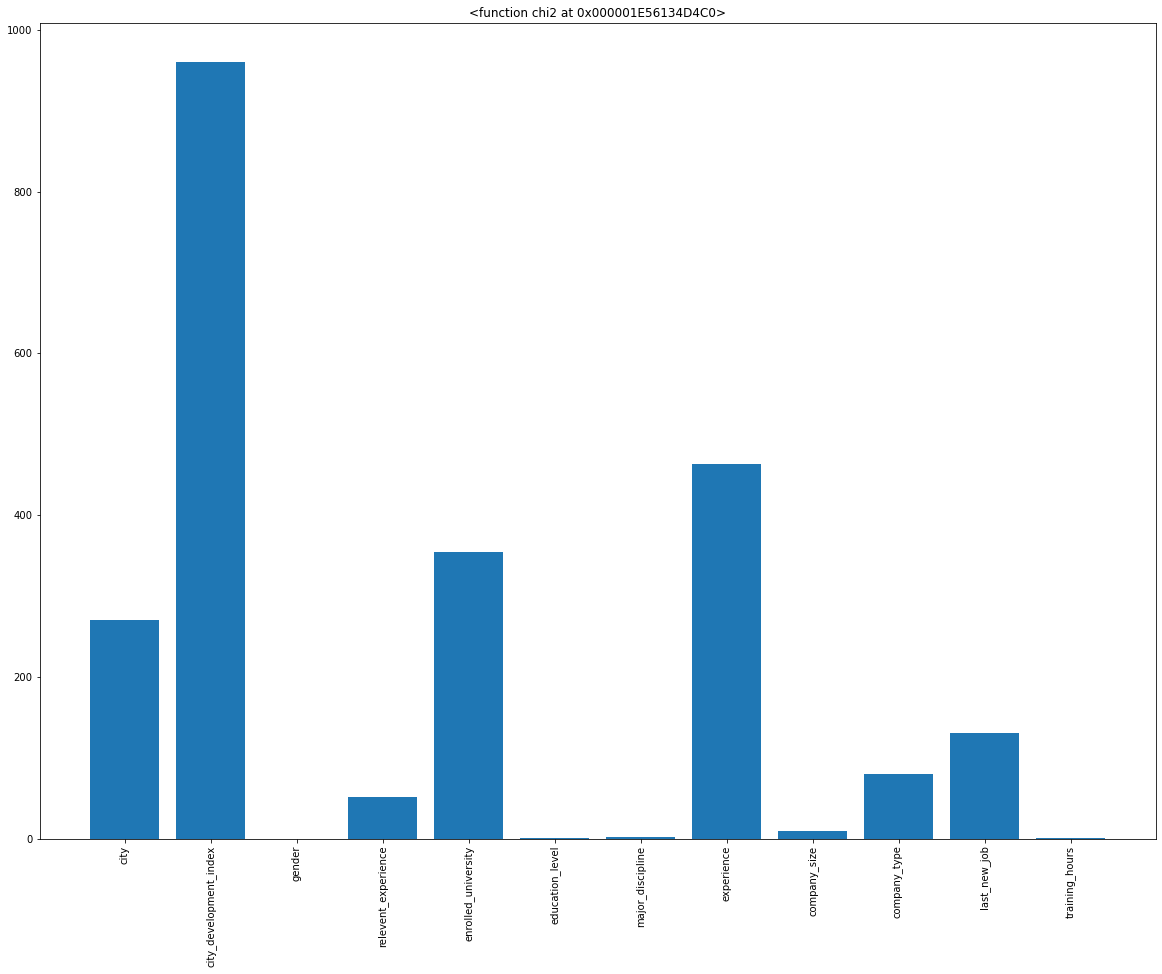

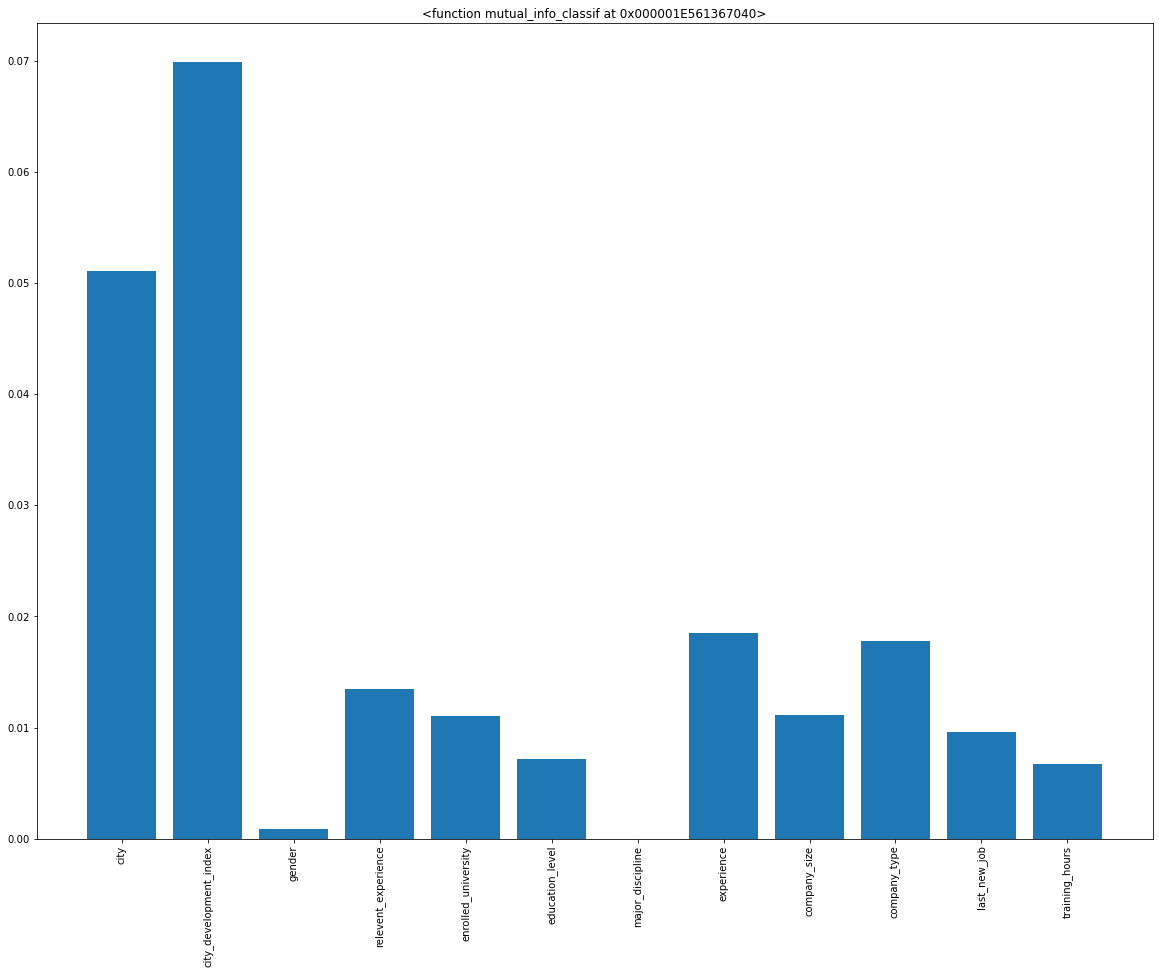

(array([[7.        , 1.        , 1.        , ..., 1.        , 0.        ,
         1.98067192],
        [0.        , 3.        , 1.        , ..., 1.        , 1.        ,
         0.89110777],
        [0.        , 3.        , 1.        , ..., 1.        , 2.        ,
         2.8100112 ],
        ...,
        [2.        , 2.        , 1.        , ..., 0.        , 3.        ,
         1.6157293 ],
        [2.        , 2.        , 3.        , ..., 0.        , 5.        ,
         2.66106258],
        [0.        , 3.        , 1.        , ..., 1.        , 1.        ,
         2.43791585]]),
 array([[0.        , 3.        , 1.        , ..., 0.        , 1.        ,
         3.34518372],
        [1.        , 0.        , 1.        , ..., 0.        , 2.        ,
         2.4027524 ],
        [7.        , 1.        , 1.        , ..., 0.        , 1.        ,
         1.24860074],
        ...,
        [0.        , 3.        , 1.        , ..., 0.        , 0.        ,
         2.5380812 ],
        [7. 

In [17]:
def select_features_viz(X_train, y_train, X_test, score_func, k = 'all'):
    fs = SelectKBest(score_func=score_func, k=k) #12 -15
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    plt.figure(figsize=(20,15))
    plt.bar(X_train.columns, fs.scores_)
    plt.xticks(rotation=90)
    plt.title(f"{str(score_func)}")
    plt.show()
    return X_train_fs, X_test_fs, fs

select_features_viz(X_train, y_train, X_test, 
                    score_func=chi2) # k 17

select_features_viz(X_train, y_train, X_test, 
                    score_func=mutual_info_classif) # k = 23

In [18]:
def select_features(X_train, y_train, X_test, score_func, k = 'all'):
    fs = SelectKBest(score_func=score_func, k=k)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)  
    return X_train_fs, X_test_fs

# Model Test

In [27]:
def ModelTest(model, X_train, X_test, y_train, y_test, typ, k):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cross_val = cross_validate(model,X_train,y_train, 
                               scoring=('accuracy','precision','recall','f1','roc_auc'),
                               cv=10)

    print(f"\nModel: {str(model)}\n")
    display(metrics.confusion_matrix(y_test,y_pred))
    print(f"Cross Val:")
    acc= cross_val.get('test_accuracy').mean()
    print(f"Acc: {acc}")
    precision = cross_val.get('test_precision').mean()
    print(f"Precision: {precision}")
    recall = cross_val.get('test_recall').mean()
    print(f"Recall: {recall}")
    f1 = cross_val.get('test_f1').mean()
    print(f"f1: {f1}")
    roc_auc = cross_val.get('test_roc_auc').mean()
    print(f"ROC AUC: {roc_auc}")
    return  ((acc+precision + recall)/3, f"{str(model)} set = {typ} k = {str(k)}" )

In [28]:
metricss = []

for scale in [True,False]:
    for normalize in [True,False]:
        
        #Extracting and Cleaning Data
        data_cleaned = Data_Cleaning(pd.read_csv('z_train.csv'), 
                                     scale = scale, 
                                     normalize = normalize)
        
        #Train, Test Split
        X = data_cleaned.drop(['target','enrollee_id'], axis = 1) 
        y = data_cleaned['target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=0.2)

        X_train_fs_chi, X_test_fs_chi = select_features(X_train, y_train, X_test, 
                                                        chi2, 
                                                        k = 7)
        X_train_fs_mic, X_test_fs_mic = select_features(X_train, y_train, X_test, 
                                                        mutual_info_classif, 
                                                        k = 10)
        
        #Model Training
        a = ModelTest(GaussianNB(), #Model    
                      X_train = X_train_fs_chi, X_test = X_test_fs_chi,
                      y_train = y_train, y_test = y_test,
                      typ = 'chi',
                      k = 17)
        metricss.append((a, "scale: " + str(scale), "normalize:" + str(normalize)))

        a = ModelTest(GaussianNB(), #Model          
                      X_train = X_train_fs_mic, X_test = X_test_fs_mic,  #Best
                      y_train = y_train, y_test = y_test,
                      typ = 'mic',
                      k = 23)
        metricss.append((a, "scale: " + str(scale), "normalize:" + str(normalize)))
        
temp = 0.001
for metric in metricss:
    if metric[0][0] > temp:
        print(metric)
        temp = metric[0][0]  


Model: GaussianNB()



array([[1924,  398],
       [ 391,  353]], dtype=int64)

Cross Val:
Acc: 0.7480424143556281
Precision: 0.4984646820369659
Recall: 0.43636363636363634
f1: 0.46507733821622743
ROC AUC: 0.711111111111111

Model: GaussianNB()



array([[1985,  337],
       [ 407,  337]], dtype=int64)

Cross Val:
Acc: 0.7621533442088092
Precision: 0.5337235199104617
Recall: 0.4233766233766233
f1: 0.4718887654837891
ROC AUC: 0.7298614647879353

Model: GaussianNB()



array([[1944,  339],
       [ 446,  337]], dtype=int64)

Cross Val:
Acc: 0.751141924959217
Precision: 0.4991141855554441
Recall: 0.4495211389128559
f1: 0.47266873966997885
ROC AUC: 0.7123938822808855

Model: GaussianNB()



array([[1959,  324],
       [ 439,  344]], dtype=int64)

Cross Val:
Acc: 0.7513866231647635
Precision: 0.4996902918426899
Recall: 0.4475388265746333
f1: 0.471790712582467
ROC AUC: 0.7224455311933282

Model: GaussianNB()



array([[2000,  305],
       [ 434,  327]], dtype=int64)

Cross Val:
Acc: 0.7588907014681892
Precision: 0.521031490979588
Recall: 0.43747844414638826
f1: 0.4754582308543721
ROC AUC: 0.7131281924626407

Model: GaussianNB()



array([[1976,  329],
       [ 437,  324]], dtype=int64)

Cross Val:
Acc: 0.7551386623164763
Precision: 0.5124388428006474
Recall: 0.4312661003597965
f1: 0.46808589646682935
ROC AUC: 0.7267342333205172

Model: GaussianNB()



array([[1990,  324],
       [ 428,  324]], dtype=int64)

Cross Val:
Acc: 0.7622349102773247
Precision: 0.5304745525411623
Recall: 0.44173294132577523
f1: 0.4818791081772017
ROC AUC: 0.7138362084869192

Model: GaussianNB()



array([[1973,  341],
       [ 406,  346]], dtype=int64)

Cross Val:
Acc: 0.7484502446982055
Precision: 0.4979837938936605
Recall: 0.4397774863572909
f1: 0.4669626664676884
ROC AUC: 0.7206165876093933
((0.5609569109187434, 'GaussianNB() set = chi k = 17'), 'scale: True', 'normalize:True')
((0.5730844958319649, 'GaussianNB() set = mic k = 23'), 'scale: True', 'normalize:True')
((0.5781474680480874, 'GaussianNB() set = chi k = 17'), 'scale: False', 'normalize:False')


In [29]:
#Model Test                                   
for scale in [True,False]:
    for normalize in [True,False]:
        
        #Extracting and Cleaning Data
        data_cleaned = Data_Cleaning(pd.read_csv('z_train.csv'), 
                                     scale = scale, 
                                     normalize = normalize)
        
        #Train, Test Split
        X = data_cleaned.drop(['target','enrollee_id'], axis = 1) 
        y = data_cleaned['target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=0.2)

        X_train_fs_chi, X_test_fs_chi = select_features(X_train, y_train, X_test, 
                                                        chi2, 
                                                        k = 7)
        X_train_fs_mic, X_test_fs_mic = select_features(X_train, y_train, X_test, 
                                                        mutual_info_classif, 
                                                        k = 10)
        
        #Model Training   
    
        a = ModelTest(LogisticRegression(max_iter=1000,random_state=0), #Model    
                      X_train = X_train_fs_chi, X_test = X_test_fs_chi,
                      y_train = y_train, y_test = y_test,
                      typ = 'chi',
                      k = 17)
        metricss.append((a, "scale: " + str(scale), "normalize:" + str(normalize)))

        a = ModelTest(LogisticRegression(max_iter=1000, random_state=0), #Model          
                      X_train = X_train_fs_mic, X_test = X_test_fs_mic,  #Best
                      y_train = y_train, y_test = y_test,
                      typ = 'mic',
                      k = 23)
        metricss.append((a, "scale: " + str(scale), "normalize:" + str(normalize)))
        
temp = 0.001
for metric in metricss:
    if metric[0][0] > temp:
        print(metric)
        temp = metric[0][0]  


Model: LogisticRegression(max_iter=1000, random_state=0)



array([[2143,  152],
       [ 571,  200]], dtype=int64)

Cross Val:
Acc: 0.7743066884176183
Precision: 0.6027489954013869
Recall: 0.27677274188363865
f1: 0.37869115278479193
ROC AUC: 0.7331838778216425

Model: LogisticRegression(max_iter=1000, random_state=0)



array([[2139,  156],
       [ 570,  201]], dtype=int64)

Cross Val:
Acc: 0.7748776508972266
Precision: 0.6071395978441126
Recall: 0.2754601950069645
f1: 0.37824572021782166
ROC AUC: 0.7332428099867294

Model: LogisticRegression(max_iter=1000, random_state=0)



array([[2142,  133],
       [ 595,  196]], dtype=int64)

Cross Val:
Acc: 0.7707177814029363
Precision: 0.591208774980972
Recall: 0.23839673441028314
f1: 0.33938554666754694
ROC AUC: 0.738273784117016

Model: LogisticRegression(max_iter=1000, random_state=0)



array([[2136,  139],
       [ 585,  206]], dtype=int64)

Cross Val:
Acc: 0.7738988580750408
Precision: 0.6009158741191947
Recall: 0.2575201928087546
f1: 0.36011599282583284
ROC AUC: 0.7384692986397566

Model: LogisticRegression(max_iter=1000, random_state=0)



array([[2158,  136],
       [ 551,  221]], dtype=int64)

Cross Val:
Acc: 0.7759380097879282
Precision: 0.5996278842801349
Recall: 0.30011464695167683
f1: 0.3997640071123985
ROC AUC: 0.7263879312113434

Model: LogisticRegression(max_iter=1000, random_state=0)



array([[2164,  130],
       [ 564,  208]], dtype=int64)

Cross Val:
Acc: 0.7727569331158238
Precision: 0.5942089714236258
Recall: 0.2732433301189328
f1: 0.373898696939206
ROC AUC: 0.7321214505555534

Model: LogisticRegression(max_iter=1000, random_state=0)



array([[2146,  149],
       [ 549,  222]], dtype=int64)

Cross Val:
Acc: 0.7769168026101141
Precision: 0.6085552302255112
Recall: 0.29742205078752815
f1: 0.39838002152745833
ROC AUC: 0.7263333067363429

Model: LogisticRegression(max_iter=1000, random_state=0)



array([[2152,  143],
       [ 572,  199]], dtype=int64)

Cross Val:
Acc: 0.7736541598694944
Precision: 0.6038525910671309
Recall: 0.26859423550841105
f1: 0.3710917751308084
ROC AUC: 0.7337243312391399
((0.5609569109187434, 'GaussianNB() set = chi k = 17'), 'scale: True', 'normalize:True')
((0.5730844958319649, 'GaussianNB() set = mic k = 23'), 'scale: True', 'normalize:True')
((0.5781474680480874, 'GaussianNB() set = chi k = 17'), 'scale: False', 'normalize:False')


In [30]:
#Model Test                                   
for scale in [True,False]:
    for normalize in [True,False]:   
        
        #Extracting and Cleaning Data
        data_cleaned = Data_Cleaning(pd.read_csv('z_train.csv'), 
                                     scale = scale, 
                                     normalize = normalize)
        
        #Train, Test Split
        X = data_cleaned.drop(['target','enrollee_id'], axis = 1) 
        y = data_cleaned['target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=0.2)

        X_train_fs_chi, X_test_fs_chi = select_features(X_train, y_train, X_test, 
                                                        chi2, 
                                                        k = 7)
        X_train_fs_mic, X_test_fs_mic = select_features(X_train, y_train, X_test, 
                                                        mutual_info_classif, 
                                                        k = 10)
                
        for max_depth in np.arange(5,100,5):
            a = ModelTest(ExtraTreeClassifier(max_depth=max_depth,
                                              random_state=0), #Model    
                          X_train = X_train_fs_chi, X_test = X_test_fs_chi,
                          y_train = y_train, y_test = y_test,
                          typ = 'chi',
                          k = 7)
            metricss.append((a, "scale: " + str(scale), "normalize:" + str(normalize)))

            a = ModelTest(ExtraTreeClassifier(max_depth=max_depth,
                                              random_state=0), #Model          
                          X_train = X_train_fs_mic, X_test = X_test_fs_mic,  #Best
                          y_train = y_train, y_test = y_test,
                          typ = 'mic',
                          k = 10)
            metricss.append((a, "scale: " + str(scale), "normalize:" + str(normalize)))
        
temp = 0.001
for metric in metricss:
    if metric[0][0] > temp:
        print(metric)
        temp = metric[0][0]  


Model: ExtraTreeClassifier(max_depth=5, random_state=0)



array([[2160,  134],
       [ 571,  201]], dtype=int64)

Cross Val:
Acc: 0.7756933115823819
Precision: 0.5978289457478154
Recall: 0.2962187935283403
f1: 0.3937712415571593
ROC AUC: 0.6981940043763524

Model: ExtraTreeClassifier(max_depth=5, random_state=0)



array([[2115,  179],
       [ 522,  250]], dtype=int64)

Cross Val:
Acc: 0.780016313213703
Precision: 0.6027898560144636
Recall: 0.3410939676417015
f1: 0.43533396058124635
ROC AUC: 0.7373374800112862

Model: ExtraTreeClassifier(max_depth=10, random_state=0)



array([[2097,  197],
       [ 516,  256]], dtype=int64)

Cross Val:
Acc: 0.7710440456769984
Precision: 0.5622636717522869
Recall: 0.3636633451194685
f1: 0.4410896500671968
ROC AUC: 0.7361764001598899

Model: ExtraTreeClassifier(max_depth=10, random_state=0)



array([[1992,  302],
       [ 386,  386]], dtype=int64)

Cross Val:
Acc: 0.7747145187601958
Precision: 0.5677752759549844
Recall: 0.4033515482695811
f1: 0.47105314849364055
ROC AUC: 0.749874408250155

Model: ExtraTreeClassifier(max_depth=15, random_state=0)



array([[1994,  300],
       [ 451,  321]], dtype=int64)

Cross Val:
Acc: 0.7578303425774878
Precision: 0.5190499928671208
Recall: 0.387611700417872
f1: 0.4435299844177122
ROC AUC: 0.7144276238964905

Model: ExtraTreeClassifier(max_depth=15, random_state=0)



array([[1979,  315],
       [ 424,  348]], dtype=int64)

Cross Val:
Acc: 0.7517128874388256
Precision: 0.501356044390271
Recall: 0.4256284153005464
f1: 0.45926296307206016
ROC AUC: 0.7020607290875083

Model: ExtraTreeClassifier(max_depth=20, random_state=0)



array([[1982,  312],
       [ 451,  321]], dtype=int64)

Cross Val:
Acc: 0.7560358890701468
Precision: 0.5139154862429905
Recall: 0.39744562305796644
f1: 0.44767882384939145
ROC AUC: 0.7096078089852926

Model: ExtraTreeClassifier(max_depth=20, random_state=0)



array([[1912,  382],
       [ 421,  351]], dtype=int64)

Cross Val:
Acc: 0.7407830342577488
Precision: 0.47650142939246615
Recall: 0.4197224900889318
f1: 0.4459418254371272
ROC AUC: 0.6868527511489211

Model: ExtraTreeClassifier(max_depth=25, random_state=0)



array([[1981,  313],
       [ 457,  315]], dtype=int64)

Cross Val:
Acc: 0.7557911908646002
Precision: 0.5133624191682585
Recall: 0.39580735026250935
f1: 0.44640287609598206
ROC AUC: 0.7087349329338541

Model: ExtraTreeClassifier(max_depth=25, random_state=0)



array([[1895,  399],
       [ 415,  357]], dtype=int64)

Cross Val:
Acc: 0.7328711256117455
Precision: 0.4585352152377265
Recall: 0.4115257687774564
f1: 0.4332763219450893
ROC AUC: 0.677199420983782

Model: ExtraTreeClassifier(max_depth=30, random_state=0)



array([[1981,  313],
       [ 457,  315]], dtype=int64)

Cross Val:
Acc: 0.7557911908646002
Precision: 0.5133624191682585
Recall: 0.39580735026250935
f1: 0.44640287609598206
ROC AUC: 0.7087349329338541

Model: ExtraTreeClassifier(max_depth=30, random_state=0)



array([[1906,  388],
       [ 422,  350]], dtype=int64)

Cross Val:
Acc: 0.7358075040783033
Precision: 0.46526043359342034
Recall: 0.42070288224579455
f1: 0.4415704702830909
ROC AUC: 0.6829174869017695

Model: ExtraTreeClassifier(max_depth=35, random_state=0)



array([[1981,  313],
       [ 457,  315]], dtype=int64)

Cross Val:
Acc: 0.7557911908646002
Precision: 0.5133624191682585
Recall: 0.39580735026250935
f1: 0.44640287609598206
ROC AUC: 0.7087349329338541

Model: ExtraTreeClassifier(max_depth=35, random_state=0)



array([[1906,  388],
       [ 422,  350]], dtype=int64)

Cross Val:
Acc: 0.7358075040783033
Precision: 0.46526043359342034
Recall: 0.42070288224579455
f1: 0.4415704702830909
ROC AUC: 0.6829174869017695

Model: ExtraTreeClassifier(max_depth=40, random_state=0)



array([[1981,  313],
       [ 457,  315]], dtype=int64)

Cross Val:
Acc: 0.7557911908646002
Precision: 0.5133624191682585
Recall: 0.39580735026250935
f1: 0.44640287609598206
ROC AUC: 0.7087349329338541

Model: ExtraTreeClassifier(max_depth=40, random_state=0)



array([[1906,  388],
       [ 422,  350]], dtype=int64)

Cross Val:
Acc: 0.7358075040783033
Precision: 0.46526043359342034
Recall: 0.42070288224579455
f1: 0.4415704702830909
ROC AUC: 0.6829174869017695

Model: ExtraTreeClassifier(max_depth=45, random_state=0)



array([[1981,  313],
       [ 457,  315]], dtype=int64)

Cross Val:
Acc: 0.7557911908646002
Precision: 0.5133624191682585
Recall: 0.39580735026250935
f1: 0.44640287609598206
ROC AUC: 0.7087349329338541

Model: ExtraTreeClassifier(max_depth=45, random_state=0)



array([[1906,  388],
       [ 422,  350]], dtype=int64)

Cross Val:
Acc: 0.7358075040783033
Precision: 0.46526043359342034
Recall: 0.42070288224579455
f1: 0.4415704702830909
ROC AUC: 0.6829174869017695

Model: ExtraTreeClassifier(max_depth=50, random_state=0)



array([[1981,  313],
       [ 457,  315]], dtype=int64)

Cross Val:
Acc: 0.7557911908646002
Precision: 0.5133624191682585
Recall: 0.39580735026250935
f1: 0.44640287609598206
ROC AUC: 0.7087349329338541

Model: ExtraTreeClassifier(max_depth=50, random_state=0)



array([[1906,  388],
       [ 422,  350]], dtype=int64)

Cross Val:
Acc: 0.7358075040783033
Precision: 0.46526043359342034
Recall: 0.42070288224579455
f1: 0.4415704702830909
ROC AUC: 0.6829174869017695

Model: ExtraTreeClassifier(max_depth=55, random_state=0)



array([[1981,  313],
       [ 457,  315]], dtype=int64)

Cross Val:
Acc: 0.7557911908646002
Precision: 0.5133624191682585
Recall: 0.39580735026250935
f1: 0.44640287609598206
ROC AUC: 0.7087349329338541

Model: ExtraTreeClassifier(max_depth=55, random_state=0)



array([[1906,  388],
       [ 422,  350]], dtype=int64)

Cross Val:
Acc: 0.7358075040783033
Precision: 0.46526043359342034
Recall: 0.42070288224579455
f1: 0.4415704702830909
ROC AUC: 0.6829174869017695

Model: ExtraTreeClassifier(max_depth=60, random_state=0)



array([[1981,  313],
       [ 457,  315]], dtype=int64)

Cross Val:
Acc: 0.7557911908646002
Precision: 0.5133624191682585
Recall: 0.39580735026250935
f1: 0.44640287609598206
ROC AUC: 0.7087349329338541

Model: ExtraTreeClassifier(max_depth=60, random_state=0)



array([[1906,  388],
       [ 422,  350]], dtype=int64)

Cross Val:
Acc: 0.7358075040783033
Precision: 0.46526043359342034
Recall: 0.42070288224579455
f1: 0.4415704702830909
ROC AUC: 0.6829174869017695

Model: ExtraTreeClassifier(max_depth=65, random_state=0)



array([[1981,  313],
       [ 457,  315]], dtype=int64)

Cross Val:
Acc: 0.7557911908646002
Precision: 0.5133624191682585
Recall: 0.39580735026250935
f1: 0.44640287609598206
ROC AUC: 0.7087349329338541

Model: ExtraTreeClassifier(max_depth=65, random_state=0)



array([[1906,  388],
       [ 422,  350]], dtype=int64)

Cross Val:
Acc: 0.7358075040783033
Precision: 0.46526043359342034
Recall: 0.42070288224579455
f1: 0.4415704702830909
ROC AUC: 0.6829174869017695

Model: ExtraTreeClassifier(max_depth=70, random_state=0)



array([[1981,  313],
       [ 457,  315]], dtype=int64)

Cross Val:
Acc: 0.7557911908646002
Precision: 0.5133624191682585
Recall: 0.39580735026250935
f1: 0.44640287609598206
ROC AUC: 0.7087349329338541

Model: ExtraTreeClassifier(max_depth=70, random_state=0)



array([[1906,  388],
       [ 422,  350]], dtype=int64)

Cross Val:
Acc: 0.7358075040783033
Precision: 0.46526043359342034
Recall: 0.42070288224579455
f1: 0.4415704702830909
ROC AUC: 0.6829174869017695

Model: ExtraTreeClassifier(max_depth=75, random_state=0)



array([[1981,  313],
       [ 457,  315]], dtype=int64)

Cross Val:
Acc: 0.7557911908646002
Precision: 0.5133624191682585
Recall: 0.39580735026250935
f1: 0.44640287609598206
ROC AUC: 0.7087349329338541

Model: ExtraTreeClassifier(max_depth=75, random_state=0)



array([[1906,  388],
       [ 422,  350]], dtype=int64)

Cross Val:
Acc: 0.7358075040783033
Precision: 0.46526043359342034
Recall: 0.42070288224579455
f1: 0.4415704702830909
ROC AUC: 0.6829174869017695

Model: ExtraTreeClassifier(max_depth=80, random_state=0)



array([[1981,  313],
       [ 457,  315]], dtype=int64)

Cross Val:
Acc: 0.7557911908646002
Precision: 0.5133624191682585
Recall: 0.39580735026250935
f1: 0.44640287609598206
ROC AUC: 0.7087349329338541

Model: ExtraTreeClassifier(max_depth=80, random_state=0)



array([[1906,  388],
       [ 422,  350]], dtype=int64)

Cross Val:
Acc: 0.7358075040783033
Precision: 0.46526043359342034
Recall: 0.42070288224579455
f1: 0.4415704702830909
ROC AUC: 0.6829174869017695

Model: ExtraTreeClassifier(max_depth=85, random_state=0)



array([[1981,  313],
       [ 457,  315]], dtype=int64)

Cross Val:
Acc: 0.7557911908646002
Precision: 0.5133624191682585
Recall: 0.39580735026250935
f1: 0.44640287609598206
ROC AUC: 0.7087349329338541

Model: ExtraTreeClassifier(max_depth=85, random_state=0)



array([[1906,  388],
       [ 422,  350]], dtype=int64)

Cross Val:
Acc: 0.7358075040783033
Precision: 0.46526043359342034
Recall: 0.42070288224579455
f1: 0.4415704702830909
ROC AUC: 0.6829174869017695

Model: ExtraTreeClassifier(max_depth=90, random_state=0)



array([[1981,  313],
       [ 457,  315]], dtype=int64)

Cross Val:
Acc: 0.7557911908646002
Precision: 0.5133624191682585
Recall: 0.39580735026250935
f1: 0.44640287609598206
ROC AUC: 0.7087349329338541

Model: ExtraTreeClassifier(max_depth=90, random_state=0)



array([[1906,  388],
       [ 422,  350]], dtype=int64)

Cross Val:
Acc: 0.7358075040783033
Precision: 0.46526043359342034
Recall: 0.42070288224579455
f1: 0.4415704702830909
ROC AUC: 0.6829174869017695

Model: ExtraTreeClassifier(max_depth=95, random_state=0)



array([[1981,  313],
       [ 457,  315]], dtype=int64)

Cross Val:
Acc: 0.7557911908646002
Precision: 0.5133624191682585
Recall: 0.39580735026250935
f1: 0.44640287609598206
ROC AUC: 0.7087349329338541

Model: ExtraTreeClassifier(max_depth=95, random_state=0)



array([[1906,  388],
       [ 422,  350]], dtype=int64)

Cross Val:
Acc: 0.7358075040783033
Precision: 0.46526043359342034
Recall: 0.42070288224579455
f1: 0.4415704702830909
ROC AUC: 0.6829174869017695

Model: ExtraTreeClassifier(max_depth=5, random_state=0)



array([[2222,   91],
       [ 587,  166]], dtype=int64)

Cross Val:
Acc: 0.7646003262642741
Precision: 0.5842598283011388
Recall: 0.21068996150429373
f1: 0.306273047233128
ROC AUC: 0.7040162437149355

Model: ExtraTreeClassifier(max_depth=5, random_state=0)



array([[2142,  171],
       [ 457,  296]], dtype=int64)

Cross Val:
Acc: 0.7784665579119087
Precision: 0.5961058273175933
Recall: 0.3585028977537121
f1: 0.4473486120840124
ROC AUC: 0.7458357135682192

Model: ExtraTreeClassifier(max_depth=10, random_state=0)



array([[2138,  175],
       [ 502,  251]], dtype=int64)

Cross Val:
Acc: 0.7680261011419249
Precision: 0.5576254190715584
Recall: 0.3617549388722028
f1: 0.4377794244299073
ROC AUC: 0.7349247330083821

Model: ExtraTreeClassifier(max_depth=10, random_state=0)



array([[2062,  251],
       [ 450,  303]], dtype=int64)

Cross Val:
Acc: 0.7679445350734094
Precision: 0.5578408102790349
Recall: 0.3614376665679598
f1: 0.4378441416977948
ROC AUC: 0.7404050603609019

Model: ExtraTreeClassifier(max_depth=15, random_state=0)



array([[2053,  260],
       [ 453,  300]], dtype=int64)

Cross Val:
Acc: 0.7549755301794454
Precision: 0.5141607592245817
Recall: 0.3891154448157706
f1: 0.4424353570361291
ROC AUC: 0.710086631389921

Model: ExtraTreeClassifier(max_depth=15, random_state=0)



array([[2012,  301],
       [ 430,  323]], dtype=int64)

Cross Val:
Acc: 0.7469820554649266
Precision: 0.4945073887396833
Recall: 0.42004526418207194
f1: 0.45362296654329637
ROC AUC: 0.693267807490471

Model: ExtraTreeClassifier(max_depth=20, random_state=0)



array([[2028,  285],
       [ 437,  316]], dtype=int64)

Cross Val:
Acc: 0.7507340946166395
Precision: 0.5028544684669944
Recall: 0.3943187106053555
f1: 0.44160422891474205
ROC AUC: 0.7030492238190185

Model: ExtraTreeClassifier(max_depth=20, random_state=0)



array([[1930,  383],
       [ 473,  280]], dtype=int64)

Cross Val:
Acc: 0.7256117455138662
Precision: 0.44813012543814523
Recall: 0.41190405685519693
f1: 0.42863068612475663
ROC AUC: 0.6443795184852776

Model: ExtraTreeClassifier(max_depth=25, random_state=0)



array([[2023,  290],
       [ 436,  317]], dtype=int64)

Cross Val:
Acc: 0.7511419249592169
Precision: 0.5040200446370917
Recall: 0.39399297770633274
f1: 0.4418645355834584
ROC AUC: 0.7031764687708674

Model: ExtraTreeClassifier(max_depth=25, random_state=0)



array([[1872,  441],
       [ 435,  318]], dtype=int64)

Cross Val:
Acc: 0.7081566068515498
Precision: 0.41431958863384616
Recall: 0.4005139811328736
f1: 0.40711089681769996
ROC AUC: 0.6138071023840675

Model: ExtraTreeClassifier(max_depth=30, random_state=0)



array([[2023,  290],
       [ 436,  317]], dtype=int64)

Cross Val:
Acc: 0.7511419249592169
Precision: 0.5040200446370917
Recall: 0.39399297770633274
f1: 0.4418645355834584
ROC AUC: 0.7031764687708674

Model: ExtraTreeClassifier(max_depth=30, random_state=0)



array([[1860,  453],
       [ 426,  327]], dtype=int64)

Cross Val:
Acc: 0.7039151712887439
Precision: 0.40992603624071694
Recall: 0.41971741613435426
f1: 0.41444500682050894
ROC AUC: 0.6156233331212262

Model: ExtraTreeClassifier(max_depth=35, random_state=0)



array([[2023,  290],
       [ 436,  317]], dtype=int64)

Cross Val:
Acc: 0.7511419249592169
Precision: 0.5040200446370917
Recall: 0.39399297770633274
f1: 0.4418645355834584
ROC AUC: 0.7031764687708674

Model: ExtraTreeClassifier(max_depth=35, random_state=0)



array([[1876,  437],
       [ 434,  319]], dtype=int64)

Cross Val:
Acc: 0.7066068515497553
Precision: 0.4164382243562545
Recall: 0.4291721308007953
f1: 0.42231306776123223
ROC AUC: 0.6187877258755816

Model: ExtraTreeClassifier(max_depth=40, random_state=0)



array([[2023,  290],
       [ 436,  317]], dtype=int64)

Cross Val:
Acc: 0.7511419249592169
Precision: 0.5040200446370917
Recall: 0.39399297770633274
f1: 0.4418645355834584
ROC AUC: 0.7031764687708674

Model: ExtraTreeClassifier(max_depth=40, random_state=0)



array([[1876,  437],
       [ 434,  319]], dtype=int64)

Cross Val:
Acc: 0.7066068515497553
Precision: 0.4164382243562545
Recall: 0.4291721308007953
f1: 0.42231306776123223
ROC AUC: 0.6187877258755816

Model: ExtraTreeClassifier(max_depth=45, random_state=0)



array([[2023,  290],
       [ 436,  317]], dtype=int64)

Cross Val:
Acc: 0.7511419249592169
Precision: 0.5040200446370917
Recall: 0.39399297770633274
f1: 0.4418645355834584
ROC AUC: 0.7031764687708674

Model: ExtraTreeClassifier(max_depth=45, random_state=0)



array([[1876,  437],
       [ 434,  319]], dtype=int64)

Cross Val:
Acc: 0.7066068515497553
Precision: 0.4164382243562545
Recall: 0.4291721308007953
f1: 0.42231306776123223
ROC AUC: 0.6187877258755816

Model: ExtraTreeClassifier(max_depth=50, random_state=0)



array([[2023,  290],
       [ 436,  317]], dtype=int64)

Cross Val:
Acc: 0.7511419249592169
Precision: 0.5040200446370917
Recall: 0.39399297770633274
f1: 0.4418645355834584
ROC AUC: 0.7031764687708674

Model: ExtraTreeClassifier(max_depth=50, random_state=0)



array([[1876,  437],
       [ 434,  319]], dtype=int64)

Cross Val:
Acc: 0.7066068515497553
Precision: 0.4164382243562545
Recall: 0.4291721308007953
f1: 0.42231306776123223
ROC AUC: 0.6187877258755816

Model: ExtraTreeClassifier(max_depth=55, random_state=0)



array([[2023,  290],
       [ 436,  317]], dtype=int64)

Cross Val:
Acc: 0.7511419249592169
Precision: 0.5040200446370917
Recall: 0.39399297770633274
f1: 0.4418645355834584
ROC AUC: 0.7031764687708674

Model: ExtraTreeClassifier(max_depth=55, random_state=0)



array([[1876,  437],
       [ 434,  319]], dtype=int64)

Cross Val:
Acc: 0.7066068515497553
Precision: 0.4164382243562545
Recall: 0.4291721308007953
f1: 0.42231306776123223
ROC AUC: 0.6187877258755816

Model: ExtraTreeClassifier(max_depth=60, random_state=0)



array([[2023,  290],
       [ 436,  317]], dtype=int64)

Cross Val:
Acc: 0.7511419249592169
Precision: 0.5040200446370917
Recall: 0.39399297770633274
f1: 0.4418645355834584
ROC AUC: 0.7031764687708674

Model: ExtraTreeClassifier(max_depth=60, random_state=0)



array([[1876,  437],
       [ 434,  319]], dtype=int64)

Cross Val:
Acc: 0.7066068515497553
Precision: 0.4164382243562545
Recall: 0.4291721308007953
f1: 0.42231306776123223
ROC AUC: 0.6187877258755816

Model: ExtraTreeClassifier(max_depth=65, random_state=0)



array([[2023,  290],
       [ 436,  317]], dtype=int64)

Cross Val:
Acc: 0.7511419249592169
Precision: 0.5040200446370917
Recall: 0.39399297770633274
f1: 0.4418645355834584
ROC AUC: 0.7031764687708674

Model: ExtraTreeClassifier(max_depth=65, random_state=0)



array([[1876,  437],
       [ 434,  319]], dtype=int64)

Cross Val:
Acc: 0.7066068515497553
Precision: 0.4164382243562545
Recall: 0.4291721308007953
f1: 0.42231306776123223
ROC AUC: 0.6187877258755816

Model: ExtraTreeClassifier(max_depth=70, random_state=0)



array([[2023,  290],
       [ 436,  317]], dtype=int64)

Cross Val:
Acc: 0.7511419249592169
Precision: 0.5040200446370917
Recall: 0.39399297770633274
f1: 0.4418645355834584
ROC AUC: 0.7031764687708674

Model: ExtraTreeClassifier(max_depth=70, random_state=0)



array([[1876,  437],
       [ 434,  319]], dtype=int64)

Cross Val:
Acc: 0.7066068515497553
Precision: 0.4164382243562545
Recall: 0.4291721308007953
f1: 0.42231306776123223
ROC AUC: 0.6187877258755816

Model: ExtraTreeClassifier(max_depth=75, random_state=0)



array([[2023,  290],
       [ 436,  317]], dtype=int64)

Cross Val:
Acc: 0.7511419249592169
Precision: 0.5040200446370917
Recall: 0.39399297770633274
f1: 0.4418645355834584
ROC AUC: 0.7031764687708674

Model: ExtraTreeClassifier(max_depth=75, random_state=0)



array([[1876,  437],
       [ 434,  319]], dtype=int64)

Cross Val:
Acc: 0.7066068515497553
Precision: 0.4164382243562545
Recall: 0.4291721308007953
f1: 0.42231306776123223
ROC AUC: 0.6187877258755816

Model: ExtraTreeClassifier(max_depth=80, random_state=0)



array([[2023,  290],
       [ 436,  317]], dtype=int64)

Cross Val:
Acc: 0.7511419249592169
Precision: 0.5040200446370917
Recall: 0.39399297770633274
f1: 0.4418645355834584
ROC AUC: 0.7031764687708674

Model: ExtraTreeClassifier(max_depth=80, random_state=0)



array([[1876,  437],
       [ 434,  319]], dtype=int64)

Cross Val:
Acc: 0.7066068515497553
Precision: 0.4164382243562545
Recall: 0.4291721308007953
f1: 0.42231306776123223
ROC AUC: 0.6187877258755816

Model: ExtraTreeClassifier(max_depth=85, random_state=0)



array([[2023,  290],
       [ 436,  317]], dtype=int64)

Cross Val:
Acc: 0.7511419249592169
Precision: 0.5040200446370917
Recall: 0.39399297770633274
f1: 0.4418645355834584
ROC AUC: 0.7031764687708674

Model: ExtraTreeClassifier(max_depth=85, random_state=0)



array([[1876,  437],
       [ 434,  319]], dtype=int64)

Cross Val:
Acc: 0.7066068515497553
Precision: 0.4164382243562545
Recall: 0.4291721308007953
f1: 0.42231306776123223
ROC AUC: 0.6187877258755816

Model: ExtraTreeClassifier(max_depth=90, random_state=0)



array([[2023,  290],
       [ 436,  317]], dtype=int64)

Cross Val:
Acc: 0.7511419249592169
Precision: 0.5040200446370917
Recall: 0.39399297770633274
f1: 0.4418645355834584
ROC AUC: 0.7031764687708674

Model: ExtraTreeClassifier(max_depth=90, random_state=0)



array([[1876,  437],
       [ 434,  319]], dtype=int64)

Cross Val:
Acc: 0.7066068515497553
Precision: 0.4164382243562545
Recall: 0.4291721308007953
f1: 0.42231306776123223
ROC AUC: 0.6187877258755816

Model: ExtraTreeClassifier(max_depth=95, random_state=0)



array([[2023,  290],
       [ 436,  317]], dtype=int64)

Cross Val:
Acc: 0.7511419249592169
Precision: 0.5040200446370917
Recall: 0.39399297770633274
f1: 0.4418645355834584
ROC AUC: 0.7031764687708674

Model: ExtraTreeClassifier(max_depth=95, random_state=0)



array([[1876,  437],
       [ 434,  319]], dtype=int64)

Cross Val:
Acc: 0.7066068515497553
Precision: 0.4164382243562545
Recall: 0.4291721308007953
f1: 0.42231306776123223
ROC AUC: 0.6187877258755816

Model: ExtraTreeClassifier(max_depth=5, random_state=0)



array([[2106,  194],
       [ 467,  299]], dtype=int64)

Cross Val:
Acc: 0.7770799347471452
Precision: 0.5883443563901305
Recall: 0.35380799314261224
f1: 0.44094281179588446
ROC AUC: 0.7484452814264327

Model: ExtraTreeClassifier(max_depth=5, random_state=0)



array([[2126,  174],
       [ 484,  282]], dtype=int64)

Cross Val:
Acc: 0.7758564437194126
Precision: 0.5910244568415058
Recall: 0.33059573556198435
f1: 0.42328920623877203
ROC AUC: 0.7297578827413915

Model: ExtraTreeClassifier(max_depth=10, random_state=0)



array([[2071,  229],
       [ 456,  310]], dtype=int64)

Cross Val:
Acc: 0.7695758564437194
Precision: 0.5592988887802682
Recall: 0.3616768456016287
f1: 0.4387644653799786
ROC AUC: 0.7376303161014577

Model: ExtraTreeClassifier(max_depth=10, random_state=0)



array([[2082,  218],
       [ 435,  331]], dtype=int64)

Cross Val:
Acc: 0.7740619902120719
Precision: 0.5676156924810489
Recall: 0.39699774991964
f1: 0.46560966498571077
ROC AUC: 0.7456412707307627

Model: ExtraTreeClassifier(max_depth=15, random_state=0)



array([[2016,  284],
       [ 474,  292]], dtype=int64)

Cross Val:
Acc: 0.7455954323001631
Precision: 0.48662913773528355
Recall: 0.36460623593699776
f1: 0.41661866853576957
ROC AUC: 0.6696281942071353

Model: ExtraTreeClassifier(max_depth=15, random_state=0)



array([[2003,  297],
       [ 426,  340]], dtype=int64)

Cross Val:
Acc: 0.7527732463295268
Precision: 0.50704347140431
Recall: 0.3956841315761277
f1: 0.44345190842807075
ROC AUC: 0.6990381941547076

Model: ExtraTreeClassifier(max_depth=20, random_state=0)



array([[1949,  351],
       [ 485,  281]], dtype=int64)

Cross Val:
Acc: 0.716721044045677
Precision: 0.4249522337879862
Recall: 0.38031822565091616
f1: 0.40099166168585654
ROC AUC: 0.6209574449024241

Model: ExtraTreeClassifier(max_depth=20, random_state=0)



array([[1978,  322],
       [ 463,  303]], dtype=int64)

Cross Val:
Acc: 0.7312398042414355
Precision: 0.45598437194111696
Recall: 0.40254580520732886
f1: 0.42708601807433366
ROC AUC: 0.658411277595146

Model: ExtraTreeClassifier(max_depth=25, random_state=0)



array([[1902,  398],
       [ 466,  300]], dtype=int64)

Cross Val:
Acc: 0.7017944535073408
Precision: 0.399621633200203
Recall: 0.3819522125790206
f1: 0.3898326149766161
ROC AUC: 0.6063463643659021

Model: ExtraTreeClassifier(max_depth=25, random_state=0)



array([[1873,  427],
       [ 442,  324]], dtype=int64)

Cross Val:
Acc: 0.716394779771615
Precision: 0.43064355575927243
Recall: 0.42282867245258765
f1: 0.42645656228255413
ROC AUC: 0.6384345056714678

Model: ExtraTreeClassifier(max_depth=30, random_state=0)



array([[1904,  396],
       [ 458,  308]], dtype=int64)

Cross Val:
Acc: 0.7038336052202284
Precision: 0.40296004672387326
Recall: 0.38783777992071145
f1: 0.3947457279881973
ROC AUC: 0.611243788402037

Model: ExtraTreeClassifier(max_depth=30, random_state=0)



array([[1861,  439],
       [ 446,  320]], dtype=int64)

Cross Val:
Acc: 0.7133768352365416
Precision: 0.4254636241286997
Recall: 0.4244680167148827
f1: 0.4245585369466697
ROC AUC: 0.6250972939707433

Model: ExtraTreeClassifier(max_depth=35, random_state=0)



array([[1904,  396],
       [ 458,  308]], dtype=int64)

Cross Val:
Acc: 0.7013866231647634
Precision: 0.3976247200034504
Recall: 0.3842408657452052
f1: 0.3901879790679246
ROC AUC: 0.6082793629997629

Model: ExtraTreeClassifier(max_depth=35, random_state=0)



array([[1860,  440],
       [ 437,  329]], dtype=int64)

Cross Val:
Acc: 0.7111745513866231
Precision: 0.4220314872895826
Recall: 0.43034179792135435
f1: 0.42584643107562875
ROC AUC: 0.6254740247781524

Model: ExtraTreeClassifier(max_depth=40, random_state=0)



array([[1904,  396],
       [ 458,  308]], dtype=int64)

Cross Val:
Acc: 0.7013866231647634
Precision: 0.3976247200034504
Recall: 0.3842408657452052
f1: 0.3901879790679246
ROC AUC: 0.6082793629997629

Model: ExtraTreeClassifier(max_depth=40, random_state=0)



array([[1859,  441],
       [ 436,  330]], dtype=int64)

Cross Val:
Acc: 0.7111745513866232
Precision: 0.4217751932489363
Recall: 0.4293603342976535
f1: 0.4252665049809746
ROC AUC: 0.624754621982979

Model: ExtraTreeClassifier(max_depth=45, random_state=0)



array([[1904,  396],
       [ 458,  308]], dtype=int64)

Cross Val:
Acc: 0.7013866231647634
Precision: 0.3976247200034504
Recall: 0.3842408657452052
f1: 0.3901879790679246
ROC AUC: 0.6082793629997629

Model: ExtraTreeClassifier(max_depth=45, random_state=0)



array([[1859,  441],
       [ 436,  330]], dtype=int64)

Cross Val:
Acc: 0.7111745513866232
Precision: 0.4217751932489363
Recall: 0.4293603342976535
f1: 0.4252665049809746
ROC AUC: 0.624754621982979

Model: ExtraTreeClassifier(max_depth=50, random_state=0)



array([[1904,  396],
       [ 458,  308]], dtype=int64)

Cross Val:
Acc: 0.7013866231647634
Precision: 0.3976247200034504
Recall: 0.3842408657452052
f1: 0.3901879790679246
ROC AUC: 0.6082793629997629

Model: ExtraTreeClassifier(max_depth=50, random_state=0)



array([[1859,  441],
       [ 436,  330]], dtype=int64)

Cross Val:
Acc: 0.7111745513866232
Precision: 0.4217751932489363
Recall: 0.4293603342976535
f1: 0.4252665049809746
ROC AUC: 0.624754621982979

Model: ExtraTreeClassifier(max_depth=55, random_state=0)



array([[1904,  396],
       [ 458,  308]], dtype=int64)

Cross Val:
Acc: 0.7013866231647634
Precision: 0.3976247200034504
Recall: 0.3842408657452052
f1: 0.3901879790679246
ROC AUC: 0.6082793629997629

Model: ExtraTreeClassifier(max_depth=55, random_state=0)



array([[1859,  441],
       [ 436,  330]], dtype=int64)

Cross Val:
Acc: 0.7111745513866232
Precision: 0.4217751932489363
Recall: 0.4293603342976535
f1: 0.4252665049809746
ROC AUC: 0.624754621982979

Model: ExtraTreeClassifier(max_depth=60, random_state=0)



array([[1904,  396],
       [ 458,  308]], dtype=int64)

Cross Val:
Acc: 0.7013866231647634
Precision: 0.3976247200034504
Recall: 0.3842408657452052
f1: 0.3901879790679246
ROC AUC: 0.6082793629997629

Model: ExtraTreeClassifier(max_depth=60, random_state=0)



array([[1859,  441],
       [ 436,  330]], dtype=int64)

Cross Val:
Acc: 0.7111745513866232
Precision: 0.4217751932489363
Recall: 0.4293603342976535
f1: 0.4252665049809746
ROC AUC: 0.624754621982979

Model: ExtraTreeClassifier(max_depth=65, random_state=0)



array([[1904,  396],
       [ 458,  308]], dtype=int64)

Cross Val:
Acc: 0.7013866231647634
Precision: 0.3976247200034504
Recall: 0.3842408657452052
f1: 0.3901879790679246
ROC AUC: 0.6082793629997629

Model: ExtraTreeClassifier(max_depth=65, random_state=0)



array([[1859,  441],
       [ 436,  330]], dtype=int64)

Cross Val:
Acc: 0.7111745513866232
Precision: 0.4217751932489363
Recall: 0.4293603342976535
f1: 0.4252665049809746
ROC AUC: 0.624754621982979

Model: ExtraTreeClassifier(max_depth=70, random_state=0)



array([[1904,  396],
       [ 458,  308]], dtype=int64)

Cross Val:
Acc: 0.7013866231647634
Precision: 0.3976247200034504
Recall: 0.3842408657452052
f1: 0.3901879790679246
ROC AUC: 0.6082793629997629

Model: ExtraTreeClassifier(max_depth=70, random_state=0)



array([[1859,  441],
       [ 436,  330]], dtype=int64)

Cross Val:
Acc: 0.7111745513866232
Precision: 0.4217751932489363
Recall: 0.4293603342976535
f1: 0.4252665049809746
ROC AUC: 0.624754621982979

Model: ExtraTreeClassifier(max_depth=75, random_state=0)



array([[1904,  396],
       [ 458,  308]], dtype=int64)

Cross Val:
Acc: 0.7013866231647634
Precision: 0.3976247200034504
Recall: 0.3842408657452052
f1: 0.3901879790679246
ROC AUC: 0.6082793629997629

Model: ExtraTreeClassifier(max_depth=75, random_state=0)



array([[1859,  441],
       [ 436,  330]], dtype=int64)

Cross Val:
Acc: 0.7111745513866232
Precision: 0.4217751932489363
Recall: 0.4293603342976535
f1: 0.4252665049809746
ROC AUC: 0.624754621982979

Model: ExtraTreeClassifier(max_depth=80, random_state=0)



array([[1904,  396],
       [ 458,  308]], dtype=int64)

Cross Val:
Acc: 0.7013866231647634
Precision: 0.3976247200034504
Recall: 0.3842408657452052
f1: 0.3901879790679246
ROC AUC: 0.6082793629997629

Model: ExtraTreeClassifier(max_depth=80, random_state=0)



array([[1859,  441],
       [ 436,  330]], dtype=int64)

Cross Val:
Acc: 0.7111745513866232
Precision: 0.4217751932489363
Recall: 0.4293603342976535
f1: 0.4252665049809746
ROC AUC: 0.624754621982979

Model: ExtraTreeClassifier(max_depth=85, random_state=0)



array([[1904,  396],
       [ 458,  308]], dtype=int64)

Cross Val:
Acc: 0.7013866231647634
Precision: 0.3976247200034504
Recall: 0.3842408657452052
f1: 0.3901879790679246
ROC AUC: 0.6082793629997629

Model: ExtraTreeClassifier(max_depth=85, random_state=0)



array([[1859,  441],
       [ 436,  330]], dtype=int64)

Cross Val:
Acc: 0.7111745513866232
Precision: 0.4217751932489363
Recall: 0.4293603342976535
f1: 0.4252665049809746
ROC AUC: 0.624754621982979

Model: ExtraTreeClassifier(max_depth=90, random_state=0)



array([[1904,  396],
       [ 458,  308]], dtype=int64)

Cross Val:
Acc: 0.7013866231647634
Precision: 0.3976247200034504
Recall: 0.3842408657452052
f1: 0.3901879790679246
ROC AUC: 0.6082793629997629

Model: ExtraTreeClassifier(max_depth=90, random_state=0)



array([[1859,  441],
       [ 436,  330]], dtype=int64)

Cross Val:
Acc: 0.7111745513866232
Precision: 0.4217751932489363
Recall: 0.4293603342976535
f1: 0.4252665049809746
ROC AUC: 0.624754621982979

Model: ExtraTreeClassifier(max_depth=95, random_state=0)



array([[1904,  396],
       [ 458,  308]], dtype=int64)

Cross Val:
Acc: 0.7013866231647634
Precision: 0.3976247200034504
Recall: 0.3842408657452052
f1: 0.3901879790679246
ROC AUC: 0.6082793629997629

Model: ExtraTreeClassifier(max_depth=95, random_state=0)



array([[1859,  441],
       [ 436,  330]], dtype=int64)

Cross Val:
Acc: 0.7111745513866232
Precision: 0.4217751932489363
Recall: 0.4293603342976535
f1: 0.4252665049809746
ROC AUC: 0.624754621982979

Model: ExtraTreeClassifier(max_depth=5, random_state=0)



array([[2120,  190],
       [ 471,  285]], dtype=int64)

Cross Val:
Acc: 0.7759380097879282
Precision: 0.589190807209915
Recall: 0.35300930361286753
f1: 0.4403930559329551
ROC AUC: 0.7543574144637125

Model: ExtraTreeClassifier(max_depth=5, random_state=0)



array([[2219,   91],
       [ 615,  141]], dtype=int64)

Cross Val:
Acc: 0.7557096247960848
Precision: 0.6320015366299045
Recall: 0.12415852334419111
f1: 0.19314449030813724
ROC AUC: 0.7169916577338076

Model: ExtraTreeClassifier(max_depth=10, random_state=0)



array([[2083,  227],
       [ 461,  295]], dtype=int64)

Cross Val:
Acc: 0.7738988580750409
Precision: 0.5723651277502751
Recall: 0.3885418662579038
f1: 0.4620697720428021
ROC AUC: 0.7564602067406065

Model: ExtraTreeClassifier(max_depth=10, random_state=0)



array([[2060,  250],
       [ 463,  293]], dtype=int64)

Cross Val:
Acc: 0.769004893964111
Precision: 0.5535737500242605
Recall: 0.4035255796129527
f1: 0.4663792052202447
ROC AUC: 0.7557366888232273

Model: ExtraTreeClassifier(max_depth=15, random_state=0)



array([[2007,  303],
       [ 475,  281]], dtype=int64)

Cross Val:
Acc: 0.7520391517128875
Precision: 0.5072452411867763
Recall: 0.38819803708671313
f1: 0.43924503881524535
ROC AUC: 0.6852398344647244

Model: ExtraTreeClassifier(max_depth=15, random_state=0)



array([[2001,  309],
       [ 446,  310]], dtype=int64)

Cross Val:
Acc: 0.7516313213703099
Precision: 0.505232810689125
Recall: 0.4475314555789742
f1: 0.47423475137544147
ROC AUC: 0.697954488422673

Model: ExtraTreeClassifier(max_depth=20, random_state=0)



array([[1885,  425],
       [ 457,  299]], dtype=int64)

Cross Val:
Acc: 0.7179445350734095
Precision: 0.4291030651414708
Recall: 0.38233910285069517
f1: 0.404144525641397
ROC AUC: 0.6266594006838269

Model: ExtraTreeClassifier(max_depth=20, random_state=0)



array([[1924,  386],
       [ 427,  329]], dtype=int64)

Cross Val:
Acc: 0.7246329526916803
Precision: 0.4481244283210376
Recall: 0.4318803091269081
f1: 0.4395812428436299
ROC AUC: 0.649361674012853

Model: ExtraTreeClassifier(max_depth=25, random_state=0)



array([[1857,  453],
       [ 463,  293]], dtype=int64)

Cross Val:
Acc: 0.7067699836867863
Precision: 0.4111429352851169
Recall: 0.3966692214345021
f1: 0.40364712289303484
ROC AUC: 0.6130178399290444

Model: ExtraTreeClassifier(max_depth=25, random_state=0)



array([[1877,  433],
       [ 424,  332]], dtype=int64)

Cross Val:
Acc: 0.715415986949429
Precision: 0.4320118148352373
Recall: 0.4354591130697664
f1: 0.43324258520133985
ROC AUC: 0.6312880688159075

Model: ExtraTreeClassifier(max_depth=30, random_state=0)



array([[1870,  440],
       [ 466,  290]], dtype=int64)

Cross Val:
Acc: 0.7122349102773247
Precision: 0.42134360083244776
Recall: 0.3982968214430181
f1: 0.40920173383946457
ROC AUC: 0.6171086537160755

Model: ExtraTreeClassifier(max_depth=30, random_state=0)



array([[1840,  470],
       [ 410,  346]], dtype=int64)

Cross Val:
Acc: 0.715252854812398
Precision: 0.4330808461969652
Recall: 0.44033765514892165
f1: 0.43636458495042385
ROC AUC: 0.6268458572525919

Model: ExtraTreeClassifier(max_depth=35, random_state=0)



array([[1870,  440],
       [ 466,  290]], dtype=int64)

Cross Val:
Acc: 0.7099510603588908
Precision: 0.41642804181178705
Recall: 0.39406229375572166
f1: 0.40464736972093585
ROC AUC: 0.614019507816801

Model: ExtraTreeClassifier(max_depth=35, random_state=0)



array([[1885,  425],
       [ 414,  342]], dtype=int64)

Cross Val:
Acc: 0.7150081566068516
Precision: 0.43177900644816997
Recall: 0.4390411104724191
f1: 0.43510428785800814
ROC AUC: 0.6270006158025005

Model: ExtraTreeClassifier(max_depth=40, random_state=0)



array([[1870,  440],
       [ 466,  290]], dtype=int64)

Cross Val:
Acc: 0.7099510603588908
Precision: 0.41642804181178705
Recall: 0.39406229375572166
f1: 0.40464736972093585
ROC AUC: 0.614019507816801

Model: ExtraTreeClassifier(max_depth=40, random_state=0)



array([[1885,  425],
       [ 414,  342]], dtype=int64)

Cross Val:
Acc: 0.7150081566068516
Precision: 0.43177900644816997
Recall: 0.4390411104724191
f1: 0.43510428785800814
ROC AUC: 0.6270006158025005

Model: ExtraTreeClassifier(max_depth=45, random_state=0)



array([[1870,  440],
       [ 466,  290]], dtype=int64)

Cross Val:
Acc: 0.7099510603588908
Precision: 0.41642804181178705
Recall: 0.39406229375572166
f1: 0.40464736972093585
ROC AUC: 0.614019507816801

Model: ExtraTreeClassifier(max_depth=45, random_state=0)



array([[1885,  425],
       [ 414,  342]], dtype=int64)

Cross Val:
Acc: 0.7150081566068516
Precision: 0.43177900644816997
Recall: 0.4390411104724191
f1: 0.43510428785800814
ROC AUC: 0.6270006158025005

Model: ExtraTreeClassifier(max_depth=50, random_state=0)



array([[1870,  440],
       [ 466,  290]], dtype=int64)

Cross Val:
Acc: 0.7099510603588908
Precision: 0.41642804181178705
Recall: 0.39406229375572166
f1: 0.40464736972093585
ROC AUC: 0.614019507816801

Model: ExtraTreeClassifier(max_depth=50, random_state=0)



array([[1885,  425],
       [ 414,  342]], dtype=int64)

Cross Val:
Acc: 0.7150081566068516
Precision: 0.43177900644816997
Recall: 0.4390411104724191
f1: 0.43510428785800814
ROC AUC: 0.6270006158025005

Model: ExtraTreeClassifier(max_depth=55, random_state=0)



array([[1870,  440],
       [ 466,  290]], dtype=int64)

Cross Val:
Acc: 0.7099510603588908
Precision: 0.41642804181178705
Recall: 0.39406229375572166
f1: 0.40464736972093585
ROC AUC: 0.614019507816801

Model: ExtraTreeClassifier(max_depth=55, random_state=0)



array([[1885,  425],
       [ 414,  342]], dtype=int64)

Cross Val:
Acc: 0.7150081566068516
Precision: 0.43177900644816997
Recall: 0.4390411104724191
f1: 0.43510428785800814
ROC AUC: 0.6270006158025005

Model: ExtraTreeClassifier(max_depth=60, random_state=0)



array([[1870,  440],
       [ 466,  290]], dtype=int64)

Cross Val:
Acc: 0.7099510603588908
Precision: 0.41642804181178705
Recall: 0.39406229375572166
f1: 0.40464736972093585
ROC AUC: 0.614019507816801

Model: ExtraTreeClassifier(max_depth=60, random_state=0)



array([[1885,  425],
       [ 414,  342]], dtype=int64)

Cross Val:
Acc: 0.7150081566068516
Precision: 0.43177900644816997
Recall: 0.4390411104724191
f1: 0.43510428785800814
ROC AUC: 0.6270006158025005

Model: ExtraTreeClassifier(max_depth=65, random_state=0)



array([[1870,  440],
       [ 466,  290]], dtype=int64)

Cross Val:
Acc: 0.7099510603588908
Precision: 0.41642804181178705
Recall: 0.39406229375572166
f1: 0.40464736972093585
ROC AUC: 0.614019507816801

Model: ExtraTreeClassifier(max_depth=65, random_state=0)



array([[1885,  425],
       [ 414,  342]], dtype=int64)

Cross Val:
Acc: 0.7150081566068516
Precision: 0.43177900644816997
Recall: 0.4390411104724191
f1: 0.43510428785800814
ROC AUC: 0.6270006158025005

Model: ExtraTreeClassifier(max_depth=70, random_state=0)



array([[1870,  440],
       [ 466,  290]], dtype=int64)

Cross Val:
Acc: 0.7099510603588908
Precision: 0.41642804181178705
Recall: 0.39406229375572166
f1: 0.40464736972093585
ROC AUC: 0.614019507816801

Model: ExtraTreeClassifier(max_depth=70, random_state=0)



array([[1885,  425],
       [ 414,  342]], dtype=int64)

Cross Val:
Acc: 0.7150081566068516
Precision: 0.43177900644816997
Recall: 0.4390411104724191
f1: 0.43510428785800814
ROC AUC: 0.6270006158025005

Model: ExtraTreeClassifier(max_depth=75, random_state=0)



array([[1870,  440],
       [ 466,  290]], dtype=int64)

Cross Val:
Acc: 0.7099510603588908
Precision: 0.41642804181178705
Recall: 0.39406229375572166
f1: 0.40464736972093585
ROC AUC: 0.614019507816801

Model: ExtraTreeClassifier(max_depth=75, random_state=0)



array([[1885,  425],
       [ 414,  342]], dtype=int64)

Cross Val:
Acc: 0.7150081566068516
Precision: 0.43177900644816997
Recall: 0.4390411104724191
f1: 0.43510428785800814
ROC AUC: 0.6270006158025005

Model: ExtraTreeClassifier(max_depth=80, random_state=0)



array([[1870,  440],
       [ 466,  290]], dtype=int64)

Cross Val:
Acc: 0.7099510603588908
Precision: 0.41642804181178705
Recall: 0.39406229375572166
f1: 0.40464736972093585
ROC AUC: 0.614019507816801

Model: ExtraTreeClassifier(max_depth=80, random_state=0)



array([[1885,  425],
       [ 414,  342]], dtype=int64)

Cross Val:
Acc: 0.7150081566068516
Precision: 0.43177900644816997
Recall: 0.4390411104724191
f1: 0.43510428785800814
ROC AUC: 0.6270006158025005

Model: ExtraTreeClassifier(max_depth=85, random_state=0)



array([[1870,  440],
       [ 466,  290]], dtype=int64)

Cross Val:
Acc: 0.7099510603588908
Precision: 0.41642804181178705
Recall: 0.39406229375572166
f1: 0.40464736972093585
ROC AUC: 0.614019507816801

Model: ExtraTreeClassifier(max_depth=85, random_state=0)



array([[1885,  425],
       [ 414,  342]], dtype=int64)

Cross Val:
Acc: 0.7150081566068516
Precision: 0.43177900644816997
Recall: 0.4390411104724191
f1: 0.43510428785800814
ROC AUC: 0.6270006158025005

Model: ExtraTreeClassifier(max_depth=90, random_state=0)



array([[1870,  440],
       [ 466,  290]], dtype=int64)

Cross Val:
Acc: 0.7099510603588908
Precision: 0.41642804181178705
Recall: 0.39406229375572166
f1: 0.40464736972093585
ROC AUC: 0.614019507816801

Model: ExtraTreeClassifier(max_depth=90, random_state=0)



array([[1885,  425],
       [ 414,  342]], dtype=int64)

Cross Val:
Acc: 0.7150081566068516
Precision: 0.43177900644816997
Recall: 0.4390411104724191
f1: 0.43510428785800814
ROC AUC: 0.6270006158025005

Model: ExtraTreeClassifier(max_depth=95, random_state=0)



array([[1870,  440],
       [ 466,  290]], dtype=int64)

Cross Val:
Acc: 0.7099510603588908
Precision: 0.41642804181178705
Recall: 0.39406229375572166
f1: 0.40464736972093585
ROC AUC: 0.614019507816801

Model: ExtraTreeClassifier(max_depth=95, random_state=0)



array([[1885,  425],
       [ 414,  342]], dtype=int64)

Cross Val:
Acc: 0.7150081566068516
Precision: 0.43177900644816997
Recall: 0.4390411104724191
f1: 0.43510428785800814
ROC AUC: 0.6270006158025005
((0.5609569109187434, 'GaussianNB() set = chi k = 17'), 'scale: True', 'normalize:True')
((0.5730844958319649, 'GaussianNB() set = mic k = 23'), 'scale: True', 'normalize:True')
((0.5781474680480874, 'GaussianNB() set = chi k = 17'), 'scale: False', 'normalize:False')
((0.5819471143282539, 'ExtraTreeClassifier(max_depth=10, random_state=0) set = mic k = 10'), 'scale: True', 'normalize:True')


In [31]:
for scale in [True,False]:
    for normalize in [True,False]:
                     
        #Extracting and Cleaning Data
        data_cleaned = Data_Cleaning(pd.read_csv('z_train.csv'), 
                                     scale = scale, 
                                     normalize = normalize)
        
        #Train, Test Split
        X = data_cleaned.drop(['target','enrollee_id'], axis = 1) 
        y = data_cleaned['target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=0.2)

        X_train_fs_chi, X_test_fs_chi = select_features(X_train, y_train, X_test, 
                                                        chi2, 
                                                        k = 7)
        X_train_fs_mic, X_test_fs_mic = select_features(X_train, y_train, X_test, 
                                                        mutual_info_classif, 
                                                        k = 10)
             
        for max_depth in np.arange(5,100,5):
            a = ModelTest(DecisionTreeClassifier(max_depth=max_depth,
                                                random_state=0), #Model    
                          X_train = X_train_fs_chi, X_test = X_test_fs_chi,
                          y_train = y_train, y_test = y_test,
                          typ = 'chi',
                          k = 7)
            metricss.append((a, "scale: " + str(scale), "normalize:" + str(normalize)))

            a = ModelTest(DecisionTreeClassifier(max_depth=max_depth,
                                                random_state=0), #Model          
                          X_train = X_train_fs_mic, X_test = X_test_fs_mic,  #Best
                          y_train = y_train, y_test = y_test,
                          typ = 'mic',
                          k = 10
                         
                         
                         
                         
                         )
            metricss.append((a, "scale: " + str(scale), "normalize:" + str(normalize)))
temp = 0.001
for metric in metricss:
    if metric[0][0] > temp:
        print(metric)
        temp = metric[0][0]  


Model: DecisionTreeClassifier(max_depth=5, random_state=0)



array([[2093,  206],
       [ 463,  304]], dtype=int64)

Cross Val:
Acc: 0.7849918433931484
Precision: 0.6013025180787054
Recall: 0.4075859852137576
f1: 0.4855676667862047
ROC AUC: 0.772471406044384

Model: DecisionTreeClassifier(max_depth=5, random_state=0)



array([[2086,  213],
       [ 457,  310]], dtype=int64)

Cross Val:
Acc: 0.7843393148450246
Precision: 0.5988871539825183
Recall: 0.40791171113254043
f1: 0.4849353167177063
ROC AUC: 0.7730310112392791

Model: DecisionTreeClassifier(max_depth=10, random_state=0)



array([[2032,  267],
       [ 450,  317]], dtype=int64)

Cross Val:
Acc: 0.7680261011419249
Precision: 0.5479062768272145
Recall: 0.3980981463623701
f1: 0.4605258773691592
ROC AUC: 0.7481951405621549

Model: DecisionTreeClassifier(max_depth=10, random_state=0)



array([[1963,  336],
       [ 353,  414]], dtype=int64)

Cross Val:
Acc: 0.7768352365415987
Precision: 0.5550365415682059
Recall: 0.5266430943962284
f1: 0.5390282628940488
ROC AUC: 0.7641250640854315

Model: DecisionTreeClassifier(max_depth=15, random_state=0)



array([[2004,  295],
       [ 458,  309]], dtype=int64)

Cross Val:
Acc: 0.7541598694942904
Precision: 0.5090581411029302
Recall: 0.3942012214721954
f1: 0.4439524805004103
ROC AUC: 0.7185118884033221

Model: DecisionTreeClassifier(max_depth=15, random_state=0)



array([[1994,  305],
       [ 436,  331]], dtype=int64)

Cross Val:
Acc: 0.7584828711256117
Precision: 0.5164130892214394
Recall: 0.4795253401907211
f1: 0.49691227966944035
ROC AUC: 0.7207850285362074

Model: DecisionTreeClassifier(max_depth=20, random_state=0)



array([[1988,  311],
       [ 452,  315]], dtype=int64)

Cross Val:
Acc: 0.7530995106035889
Precision: 0.5062151750716739
Recall: 0.39223186542376515
f1: 0.44172377758205333
ROC AUC: 0.7149725672205836

Model: DecisionTreeClassifier(max_depth=20, random_state=0)



array([[1966,  333],
       [ 426,  341]], dtype=int64)

Cross Val:
Acc: 0.7500815660685155
Precision: 0.49868734497577866
Recall: 0.4494396228436729
f1: 0.4725618859790722
ROC AUC: 0.7032616241329537

Model: DecisionTreeClassifier(max_depth=25, random_state=0)



array([[1989,  310],
       [ 452,  315]], dtype=int64)

Cross Val:
Acc: 0.7532626427406199
Precision: 0.5066869977462394
Recall: 0.39223293689060323
f1: 0.4418989245195576
ROC AUC: 0.7148879576167566

Model: DecisionTreeClassifier(max_depth=25, random_state=0)



array([[1961,  338],
       [ 424,  343]], dtype=int64)

Cross Val:
Acc: 0.7505709624796084
Precision: 0.5001466700007329
Recall: 0.4530418943533697
f1: 0.47512391036050994
ROC AUC: 0.7034124365046643

Model: DecisionTreeClassifier(max_depth=30, random_state=0)



array([[1989,  310],
       [ 452,  315]], dtype=int64)

Cross Val:
Acc: 0.7532626427406199
Precision: 0.5066869977462394
Recall: 0.39223293689060323
f1: 0.4418989245195576
ROC AUC: 0.7148879576167566

Model: DecisionTreeClassifier(max_depth=30, random_state=0)



array([[1963,  336],
       [ 426,  341]], dtype=int64)

Cross Val:
Acc: 0.7507340946166395
Precision: 0.5005012799298109
Recall: 0.4530418943533697
f1: 0.4752864327073326
ROC AUC: 0.7034561278942636

Model: DecisionTreeClassifier(max_depth=35, random_state=0)



array([[1989,  310],
       [ 452,  315]], dtype=int64)

Cross Val:
Acc: 0.7532626427406199
Precision: 0.5066869977462394
Recall: 0.39223293689060323
f1: 0.4418989245195576
ROC AUC: 0.7148879576167566

Model: DecisionTreeClassifier(max_depth=35, random_state=0)



array([[1963,  336],
       [ 426,  341]], dtype=int64)

Cross Val:
Acc: 0.7507340946166395
Precision: 0.5005012799298109
Recall: 0.4530418943533697
f1: 0.4752864327073326
ROC AUC: 0.7034561278942636

Model: DecisionTreeClassifier(max_depth=40, random_state=0)



array([[1989,  310],
       [ 452,  315]], dtype=int64)

Cross Val:
Acc: 0.7532626427406199
Precision: 0.5066869977462394
Recall: 0.39223293689060323
f1: 0.4418989245195576
ROC AUC: 0.7148879576167566

Model: DecisionTreeClassifier(max_depth=40, random_state=0)



array([[1963,  336],
       [ 426,  341]], dtype=int64)

Cross Val:
Acc: 0.7507340946166395
Precision: 0.5005012799298109
Recall: 0.4530418943533697
f1: 0.4752864327073326
ROC AUC: 0.7034561278942636

Model: DecisionTreeClassifier(max_depth=45, random_state=0)



array([[1989,  310],
       [ 452,  315]], dtype=int64)

Cross Val:
Acc: 0.7532626427406199
Precision: 0.5066869977462394
Recall: 0.39223293689060323
f1: 0.4418989245195576
ROC AUC: 0.7148879576167566

Model: DecisionTreeClassifier(max_depth=45, random_state=0)



array([[1963,  336],
       [ 426,  341]], dtype=int64)

Cross Val:
Acc: 0.7507340946166395
Precision: 0.5005012799298109
Recall: 0.4530418943533697
f1: 0.4752864327073326
ROC AUC: 0.7034561278942636

Model: DecisionTreeClassifier(max_depth=50, random_state=0)



array([[1989,  310],
       [ 452,  315]], dtype=int64)

Cross Val:
Acc: 0.7532626427406199
Precision: 0.5066869977462394
Recall: 0.39223293689060323
f1: 0.4418989245195576
ROC AUC: 0.7148879576167566

Model: DecisionTreeClassifier(max_depth=50, random_state=0)



array([[1963,  336],
       [ 426,  341]], dtype=int64)

Cross Val:
Acc: 0.7507340946166395
Precision: 0.5005012799298109
Recall: 0.4530418943533697
f1: 0.4752864327073326
ROC AUC: 0.7034561278942636

Model: DecisionTreeClassifier(max_depth=55, random_state=0)



array([[1989,  310],
       [ 452,  315]], dtype=int64)

Cross Val:
Acc: 0.7532626427406199
Precision: 0.5066869977462394
Recall: 0.39223293689060323
f1: 0.4418989245195576
ROC AUC: 0.7148879576167566

Model: DecisionTreeClassifier(max_depth=55, random_state=0)



array([[1963,  336],
       [ 426,  341]], dtype=int64)

Cross Val:
Acc: 0.7507340946166395
Precision: 0.5005012799298109
Recall: 0.4530418943533697
f1: 0.4752864327073326
ROC AUC: 0.7034561278942636

Model: DecisionTreeClassifier(max_depth=60, random_state=0)



array([[1989,  310],
       [ 452,  315]], dtype=int64)

Cross Val:
Acc: 0.7532626427406199
Precision: 0.5066869977462394
Recall: 0.39223293689060323
f1: 0.4418989245195576
ROC AUC: 0.7148879576167566

Model: DecisionTreeClassifier(max_depth=60, random_state=0)



array([[1963,  336],
       [ 426,  341]], dtype=int64)

Cross Val:
Acc: 0.7507340946166395
Precision: 0.5005012799298109
Recall: 0.4530418943533697
f1: 0.4752864327073326
ROC AUC: 0.7034561278942636

Model: DecisionTreeClassifier(max_depth=65, random_state=0)



array([[1989,  310],
       [ 452,  315]], dtype=int64)

Cross Val:
Acc: 0.7532626427406199
Precision: 0.5066869977462394
Recall: 0.39223293689060323
f1: 0.4418989245195576
ROC AUC: 0.7148879576167566

Model: DecisionTreeClassifier(max_depth=65, random_state=0)



array([[1963,  336],
       [ 426,  341]], dtype=int64)

Cross Val:
Acc: 0.7507340946166395
Precision: 0.5005012799298109
Recall: 0.4530418943533697
f1: 0.4752864327073326
ROC AUC: 0.7034561278942636

Model: DecisionTreeClassifier(max_depth=70, random_state=0)



array([[1989,  310],
       [ 452,  315]], dtype=int64)

Cross Val:
Acc: 0.7532626427406199
Precision: 0.5066869977462394
Recall: 0.39223293689060323
f1: 0.4418989245195576
ROC AUC: 0.7148879576167566

Model: DecisionTreeClassifier(max_depth=70, random_state=0)



array([[1963,  336],
       [ 426,  341]], dtype=int64)

Cross Val:
Acc: 0.7507340946166395
Precision: 0.5005012799298109
Recall: 0.4530418943533697
f1: 0.4752864327073326
ROC AUC: 0.7034561278942636

Model: DecisionTreeClassifier(max_depth=75, random_state=0)



array([[1989,  310],
       [ 452,  315]], dtype=int64)

Cross Val:
Acc: 0.7532626427406199
Precision: 0.5066869977462394
Recall: 0.39223293689060323
f1: 0.4418989245195576
ROC AUC: 0.7148879576167566

Model: DecisionTreeClassifier(max_depth=75, random_state=0)



array([[1963,  336],
       [ 426,  341]], dtype=int64)

Cross Val:
Acc: 0.7507340946166395
Precision: 0.5005012799298109
Recall: 0.4530418943533697
f1: 0.4752864327073326
ROC AUC: 0.7034561278942636

Model: DecisionTreeClassifier(max_depth=80, random_state=0)



array([[1989,  310],
       [ 452,  315]], dtype=int64)

Cross Val:
Acc: 0.7532626427406199
Precision: 0.5066869977462394
Recall: 0.39223293689060323
f1: 0.4418989245195576
ROC AUC: 0.7148879576167566

Model: DecisionTreeClassifier(max_depth=80, random_state=0)



array([[1963,  336],
       [ 426,  341]], dtype=int64)

Cross Val:
Acc: 0.7507340946166395
Precision: 0.5005012799298109
Recall: 0.4530418943533697
f1: 0.4752864327073326
ROC AUC: 0.7034561278942636

Model: DecisionTreeClassifier(max_depth=85, random_state=0)



array([[1989,  310],
       [ 452,  315]], dtype=int64)

Cross Val:
Acc: 0.7532626427406199
Precision: 0.5066869977462394
Recall: 0.39223293689060323
f1: 0.4418989245195576
ROC AUC: 0.7148879576167566

Model: DecisionTreeClassifier(max_depth=85, random_state=0)



array([[1963,  336],
       [ 426,  341]], dtype=int64)

Cross Val:
Acc: 0.7507340946166395
Precision: 0.5005012799298109
Recall: 0.4530418943533697
f1: 0.4752864327073326
ROC AUC: 0.7034561278942636

Model: DecisionTreeClassifier(max_depth=90, random_state=0)



array([[1989,  310],
       [ 452,  315]], dtype=int64)

Cross Val:
Acc: 0.7532626427406199
Precision: 0.5066869977462394
Recall: 0.39223293689060323
f1: 0.4418989245195576
ROC AUC: 0.7148879576167566

Model: DecisionTreeClassifier(max_depth=90, random_state=0)



array([[1963,  336],
       [ 426,  341]], dtype=int64)

Cross Val:
Acc: 0.7507340946166395
Precision: 0.5005012799298109
Recall: 0.4530418943533697
f1: 0.4752864327073326
ROC AUC: 0.7034561278942636

Model: DecisionTreeClassifier(max_depth=95, random_state=0)



array([[1989,  310],
       [ 452,  315]], dtype=int64)

Cross Val:
Acc: 0.7532626427406199
Precision: 0.5066869977462394
Recall: 0.39223293689060323
f1: 0.4418989245195576
ROC AUC: 0.7148879576167566

Model: DecisionTreeClassifier(max_depth=95, random_state=0)



array([[1963,  336],
       [ 426,  341]], dtype=int64)

Cross Val:
Acc: 0.7507340946166395
Precision: 0.5005012799298109
Recall: 0.4530418943533697
f1: 0.4752864327073326
ROC AUC: 0.7034561278942636

Model: DecisionTreeClassifier(max_depth=5, random_state=0)



array([[2084,  180],
       [ 486,  316]], dtype=int64)

Cross Val:
Acc: 0.7827079934747145
Precision: 0.58618268059779
Recall: 0.4023637794243
f1: 0.47652994062463644
ROC AUC: 0.7700746349265645

Model: DecisionTreeClassifier(max_depth=5, random_state=0)



array([[2080,  184],
       [ 492,  310]], dtype=int64)

Cross Val:
Acc: 0.784094616639478
Precision: 0.5910575532939146
Recall: 0.4023605009507573
f1: 0.4781314081971706
ROC AUC: 0.7738189157790597

Model: DecisionTreeClassifier(max_depth=10, random_state=0)



array([[2055,  209],
       [ 473,  329]], dtype=int64)

Cross Val:
Acc: 0.7667210440456771
Precision: 0.5359918216034243
Recall: 0.40701156208336065
f1: 0.462085908555109
ROC AUC: 0.7466942406184212

Model: DecisionTreeClassifier(max_depth=10, random_state=0)



array([[1995,  269],
       [ 459,  343]], dtype=int64)

Cross Val:
Acc: 0.7646818923327896
Precision: 0.5279858106517044
Recall: 0.4288298035101524
f1: 0.4721795517370001
ROC AUC: 0.7367384363982082

Model: DecisionTreeClassifier(max_depth=15, random_state=0)



array([[2026,  238],
       [ 493,  309]], dtype=int64)

Cross Val:
Acc: 0.7535073409461666
Precision: 0.5001462794923441
Recall: 0.3745819946233034
f1: 0.4279547421049972
ROC AUC: 0.7111413104778757

Model: DecisionTreeClassifier(max_depth=15, random_state=0)



array([[1947,  317],
       [ 472,  330]], dtype=int64)

Cross Val:
Acc: 0.7362969004893964
Precision: 0.46159496971913117
Recall: 0.41625904312285533
f1: 0.43680830046136626
ROC AUC: 0.6605764559190841

Model: DecisionTreeClassifier(max_depth=20, random_state=0)



array([[2021,  243],
       [ 492,  310]], dtype=int64)

Cross Val:
Acc: 0.753588907014682
Precision: 0.5002389811571144
Recall: 0.3785489476099928
f1: 0.4305496118249338
ROC AUC: 0.7086127631921443

Model: DecisionTreeClassifier(max_depth=20, random_state=0)



array([[1889,  375],
       [ 480,  322]], dtype=int64)

Cross Val:
Acc: 0.7145187601957586
Precision: 0.41602776335696834
Recall: 0.3927655017157345
f1: 0.4037162001548255
ROC AUC: 0.622669452665933

Model: DecisionTreeClassifier(max_depth=25, random_state=0)



array([[2021,  243],
       [ 491,  311]], dtype=int64)

Cross Val:
Acc: 0.753588907014682
Precision: 0.5002389811571144
Recall: 0.3785489476099928
f1: 0.4305496118249338
ROC AUC: 0.7086127631921443

Model: DecisionTreeClassifier(max_depth=25, random_state=0)



array([[1861,  403],
       [ 487,  315]], dtype=int64)

Cross Val:
Acc: 0.7030179445350735
Precision: 0.3963378587306108
Recall: 0.391120800821804
f1: 0.3934637595248885
ROC AUC: 0.6130946919981997

Model: DecisionTreeClassifier(max_depth=30, random_state=0)



array([[2021,  243],
       [ 491,  311]], dtype=int64)

Cross Val:
Acc: 0.753588907014682
Precision: 0.5002389811571144
Recall: 0.3785489476099928
f1: 0.4305496118249338
ROC AUC: 0.7086127631921443

Model: DecisionTreeClassifier(max_depth=30, random_state=0)



array([[1859,  405],
       [ 490,  312]], dtype=int64)

Cross Val:
Acc: 0.7028548123980423
Precision: 0.39720542024052
Recall: 0.3970646733547526
f1: 0.39691757920082166
ROC AUC: 0.6128392567441185

Model: DecisionTreeClassifier(max_depth=35, random_state=0)



array([[2021,  243],
       [ 491,  311]], dtype=int64)

Cross Val:
Acc: 0.753588907014682
Precision: 0.5002389811571144
Recall: 0.3785489476099928
f1: 0.4305496118249338
ROC AUC: 0.7086127631921443

Model: DecisionTreeClassifier(max_depth=35, random_state=0)



array([[1857,  407],
       [ 479,  323]], dtype=int64)

Cross Val:
Acc: 0.7020391517128873
Precision: 0.3953514094913009
Recall: 0.39475007103359344
f1: 0.3948460756606768
ROC AUC: 0.6099799660522647

Model: DecisionTreeClassifier(max_depth=40, random_state=0)



array([[2021,  243],
       [ 491,  311]], dtype=int64)

Cross Val:
Acc: 0.753588907014682
Precision: 0.5002389811571144
Recall: 0.3785489476099928
f1: 0.4305496118249338
ROC AUC: 0.7086127631921443

Model: DecisionTreeClassifier(max_depth=40, random_state=0)



array([[1857,  407],
       [ 479,  323]], dtype=int64)

Cross Val:
Acc: 0.7017944535073409
Precision: 0.3949366135101834
Recall: 0.3944200380302931
f1: 0.39447988709589926
ROC AUC: 0.6100530668397899

Model: DecisionTreeClassifier(max_depth=45, random_state=0)



array([[2021,  243],
       [ 491,  311]], dtype=int64)

Cross Val:
Acc: 0.753588907014682
Precision: 0.5002389811571144
Recall: 0.3785489476099928
f1: 0.4305496118249338
ROC AUC: 0.7086127631921443

Model: DecisionTreeClassifier(max_depth=45, random_state=0)



array([[1857,  407],
       [ 479,  323]], dtype=int64)

Cross Val:
Acc: 0.70163132137031
Precision: 0.3949972666009282
Recall: 0.39574454134155135
f1: 0.39516154828671674
ROC AUC: 0.6102781177270924

Model: DecisionTreeClassifier(max_depth=50, random_state=0)



array([[2021,  243],
       [ 491,  311]], dtype=int64)

Cross Val:
Acc: 0.753588907014682
Precision: 0.5002389811571144
Recall: 0.3785489476099928
f1: 0.4305496118249338
ROC AUC: 0.7086127631921443

Model: DecisionTreeClassifier(max_depth=50, random_state=0)



array([[1857,  407],
       [ 479,  323]], dtype=int64)

Cross Val:
Acc: 0.70163132137031
Precision: 0.3949972666009282
Recall: 0.39574454134155135
f1: 0.39516154828671674
ROC AUC: 0.6102781177270924

Model: DecisionTreeClassifier(max_depth=55, random_state=0)



array([[2021,  243],
       [ 491,  311]], dtype=int64)

Cross Val:
Acc: 0.753588907014682
Precision: 0.5002389811571144
Recall: 0.3785489476099928
f1: 0.4305496118249338
ROC AUC: 0.7086127631921443

Model: DecisionTreeClassifier(max_depth=55, random_state=0)



array([[1857,  407],
       [ 479,  323]], dtype=int64)

Cross Val:
Acc: 0.70163132137031
Precision: 0.3949972666009282
Recall: 0.39574454134155135
f1: 0.39516154828671674
ROC AUC: 0.6102781177270924

Model: DecisionTreeClassifier(max_depth=60, random_state=0)



array([[2021,  243],
       [ 491,  311]], dtype=int64)

Cross Val:
Acc: 0.753588907014682
Precision: 0.5002389811571144
Recall: 0.3785489476099928
f1: 0.4305496118249338
ROC AUC: 0.7086127631921443

Model: DecisionTreeClassifier(max_depth=60, random_state=0)



array([[1857,  407],
       [ 479,  323]], dtype=int64)

Cross Val:
Acc: 0.70163132137031
Precision: 0.3949972666009282
Recall: 0.39574454134155135
f1: 0.39516154828671674
ROC AUC: 0.6102781177270924

Model: DecisionTreeClassifier(max_depth=65, random_state=0)



array([[2021,  243],
       [ 491,  311]], dtype=int64)

Cross Val:
Acc: 0.753588907014682
Precision: 0.5002389811571144
Recall: 0.3785489476099928
f1: 0.4305496118249338
ROC AUC: 0.7086127631921443

Model: DecisionTreeClassifier(max_depth=65, random_state=0)



array([[1857,  407],
       [ 479,  323]], dtype=int64)

Cross Val:
Acc: 0.70163132137031
Precision: 0.3949972666009282
Recall: 0.39574454134155135
f1: 0.39516154828671674
ROC AUC: 0.6102781177270924

Model: DecisionTreeClassifier(max_depth=70, random_state=0)



array([[2021,  243],
       [ 491,  311]], dtype=int64)

Cross Val:
Acc: 0.753588907014682
Precision: 0.5002389811571144
Recall: 0.3785489476099928
f1: 0.4305496118249338
ROC AUC: 0.7086127631921443

Model: DecisionTreeClassifier(max_depth=70, random_state=0)



array([[1857,  407],
       [ 479,  323]], dtype=int64)

Cross Val:
Acc: 0.70163132137031
Precision: 0.3949972666009282
Recall: 0.39574454134155135
f1: 0.39516154828671674
ROC AUC: 0.6102781177270924

Model: DecisionTreeClassifier(max_depth=75, random_state=0)



array([[2021,  243],
       [ 491,  311]], dtype=int64)

Cross Val:
Acc: 0.753588907014682
Precision: 0.5002389811571144
Recall: 0.3785489476099928
f1: 0.4305496118249338
ROC AUC: 0.7086127631921443

Model: DecisionTreeClassifier(max_depth=75, random_state=0)



array([[1857,  407],
       [ 479,  323]], dtype=int64)

Cross Val:
Acc: 0.70163132137031
Precision: 0.3949972666009282
Recall: 0.39574454134155135
f1: 0.39516154828671674
ROC AUC: 0.6102781177270924

Model: DecisionTreeClassifier(max_depth=80, random_state=0)



array([[2021,  243],
       [ 491,  311]], dtype=int64)

Cross Val:
Acc: 0.753588907014682
Precision: 0.5002389811571144
Recall: 0.3785489476099928
f1: 0.4305496118249338
ROC AUC: 0.7086127631921443

Model: DecisionTreeClassifier(max_depth=80, random_state=0)



array([[1857,  407],
       [ 479,  323]], dtype=int64)

Cross Val:
Acc: 0.70163132137031
Precision: 0.3949972666009282
Recall: 0.39574454134155135
f1: 0.39516154828671674
ROC AUC: 0.6102781177270924

Model: DecisionTreeClassifier(max_depth=85, random_state=0)



array([[2021,  243],
       [ 491,  311]], dtype=int64)

Cross Val:
Acc: 0.753588907014682
Precision: 0.5002389811571144
Recall: 0.3785489476099928
f1: 0.4305496118249338
ROC AUC: 0.7086127631921443

Model: DecisionTreeClassifier(max_depth=85, random_state=0)



array([[1857,  407],
       [ 479,  323]], dtype=int64)

Cross Val:
Acc: 0.70163132137031
Precision: 0.3949972666009282
Recall: 0.39574454134155135
f1: 0.39516154828671674
ROC AUC: 0.6102781177270924

Model: DecisionTreeClassifier(max_depth=90, random_state=0)



array([[2021,  243],
       [ 491,  311]], dtype=int64)

Cross Val:
Acc: 0.753588907014682
Precision: 0.5002389811571144
Recall: 0.3785489476099928
f1: 0.4305496118249338
ROC AUC: 0.7086127631921443

Model: DecisionTreeClassifier(max_depth=90, random_state=0)



array([[1857,  407],
       [ 479,  323]], dtype=int64)

Cross Val:
Acc: 0.70163132137031
Precision: 0.3949972666009282
Recall: 0.39574454134155135
f1: 0.39516154828671674
ROC AUC: 0.6102781177270924

Model: DecisionTreeClassifier(max_depth=95, random_state=0)



array([[2021,  243],
       [ 491,  311]], dtype=int64)

Cross Val:
Acc: 0.753588907014682
Precision: 0.5002389811571144
Recall: 0.3785489476099928
f1: 0.4305496118249338
ROC AUC: 0.7086127631921443

Model: DecisionTreeClassifier(max_depth=95, random_state=0)



array([[1857,  407],
       [ 479,  323]], dtype=int64)

Cross Val:
Acc: 0.70163132137031
Precision: 0.3949972666009282
Recall: 0.39574454134155135
f1: 0.39516154828671674
ROC AUC: 0.6102781177270924

Model: DecisionTreeClassifier(max_depth=5, random_state=0)



array([[2082,  206],
       [ 460,  318]], dtype=int64)

Cross Val:
Acc: 0.782137030995106
Precision: 0.5884360168643945
Recall: 0.4093949525452977
f1: 0.4823162487610409
ROC AUC: 0.7654937075097388

Model: DecisionTreeClassifier(max_depth=5, random_state=0)



array([[2085,  203],
       [ 472,  306]], dtype=int64)

Cross Val:
Acc: 0.783768352365416
Precision: 0.5961570759676089
Recall: 0.4011798964624676
f1: 0.4791102714882204
ROC AUC: 0.7746469742186814

Model: DecisionTreeClassifier(max_depth=10, random_state=0)



array([[2003,  285],
       [ 437,  341]], dtype=int64)

Cross Val:
Acc: 0.7627243066884176
Precision: 0.5279852672433385
Recall: 0.421192838654012
f1: 0.46744503804190546
ROC AUC: 0.7316333091994807

Model: DecisionTreeClassifier(max_depth=10, random_state=0)



array([[1993,  295],
       [ 384,  394]], dtype=int64)

Cross Val:
Acc: 0.771288743882545
Precision: 0.543944652353822
Recall: 0.49309965487489216
f1: 0.5165599602177326
ROC AUC: 0.758977872577824

Model: DecisionTreeClassifier(max_depth=15, random_state=0)



array([[1971,  317],
       [ 482,  296]], dtype=int64)

Cross Val:
Acc: 0.7311582381729201
Precision: 0.4537754641724712
Recall: 0.40677415875754963
f1: 0.4287387035764431
ROC AUC: 0.6581287506023119

Model: DecisionTreeClassifier(max_depth=15, random_state=0)



array([[1939,  349],
       [ 411,  367]], dtype=int64)

Cross Val:
Acc: 0.7615008156606852
Precision: 0.5213811764442196
Recall: 0.4829281708369284
f1: 0.5012948748757877
ROC AUC: 0.7178207696943354

Model: DecisionTreeClassifier(max_depth=20, random_state=0)



array([[1903,  385],
       [ 479,  299]], dtype=int64)

Cross Val:
Acc: 0.7051386623164764
Precision: 0.40531343474418496
Recall: 0.398213977566868
f1: 0.40146743198416246
ROC AUC: 0.618545691938339

Model: DecisionTreeClassifier(max_depth=20, random_state=0)



array([[1916,  372],
       [ 408,  370]], dtype=int64)

Cross Val:
Acc: 0.750326264274062
Precision: 0.49743188552381906
Recall: 0.4458315358067299
f1: 0.47007783610398785
ROC AUC: 0.701459643233201

Model: DecisionTreeClassifier(max_depth=25, random_state=0)



array([[1867,  421],
       [ 476,  302]], dtype=int64)

Cross Val:
Acc: 0.700815660685155
Precision: 0.39860845521117066
Recall: 0.39985008628127694
f1: 0.3989654961039938
ROC AUC: 0.6106984246167554

Model: DecisionTreeClassifier(max_depth=25, random_state=0)



array([[1917,  371],
       [ 402,  376]], dtype=int64)

Cross Val:
Acc: 0.7495106035889071
Precision: 0.4954553974840987
Recall: 0.444851164797239
f1: 0.46868566643453596
ROC AUC: 0.7012970201864995

Model: DecisionTreeClassifier(max_depth=30, random_state=0)



array([[1859,  429],
       [ 475,  303]], dtype=int64)

Cross Val:
Acc: 0.6995921696574225
Precision: 0.3963408831408933
Recall: 0.39984577221742884
f1: 0.39793103900569615
ROC AUC: 0.6088860750030535

Model: DecisionTreeClassifier(max_depth=30, random_state=0)



array([[1916,  372],
       [ 401,  377]], dtype=int64)

Cross Val:
Acc: 0.7488580750407831
Precision: 0.49401559126479544
Recall: 0.4448479292493529
f1: 0.46805976393703635
ROC AUC: 0.7006865249339949

Model: DecisionTreeClassifier(max_depth=35, random_state=0)



array([[1865,  423],
       [ 479,  299]], dtype=int64)

Cross Val:
Acc: 0.6984502446982055
Precision: 0.39427207915692153
Recall: 0.39820858498705786
f1: 0.39606071637462015
ROC AUC: 0.6076485194198075

Model: DecisionTreeClassifier(max_depth=35, random_state=0)



array([[1916,  372],
       [ 401,  377]], dtype=int64)

Cross Val:
Acc: 0.7488580750407831
Precision: 0.49401559126479544
Recall: 0.4448479292493529
f1: 0.46805976393703635
ROC AUC: 0.7006865249339949

Model: DecisionTreeClassifier(max_depth=40, random_state=0)



array([[1865,  423],
       [ 479,  299]], dtype=int64)

Cross Val:
Acc: 0.6982055464926591
Precision: 0.3936316624637366
Recall: 0.3968927955133736
f1: 0.3950723221213846
ROC AUC: 0.60687533267521

Model: DecisionTreeClassifier(max_depth=40, random_state=0)



array([[1916,  372],
       [ 401,  377]], dtype=int64)

Cross Val:
Acc: 0.7488580750407831
Precision: 0.49401559126479544
Recall: 0.4448479292493529
f1: 0.46805976393703635
ROC AUC: 0.7006865249339949

Model: DecisionTreeClassifier(max_depth=45, random_state=0)



array([[1865,  423],
       [ 479,  299]], dtype=int64)

Cross Val:
Acc: 0.6982055464926591
Precision: 0.3936316624637366
Recall: 0.3968927955133736
f1: 0.3950723221213846
ROC AUC: 0.60687533267521

Model: DecisionTreeClassifier(max_depth=45, random_state=0)



array([[1916,  372],
       [ 401,  377]], dtype=int64)

Cross Val:
Acc: 0.7488580750407831
Precision: 0.49401559126479544
Recall: 0.4448479292493529
f1: 0.46805976393703635
ROC AUC: 0.7006865249339949

Model: DecisionTreeClassifier(max_depth=50, random_state=0)



array([[1865,  423],
       [ 479,  299]], dtype=int64)

Cross Val:
Acc: 0.6982055464926591
Precision: 0.3936316624637366
Recall: 0.3968927955133736
f1: 0.3950723221213846
ROC AUC: 0.60687533267521

Model: DecisionTreeClassifier(max_depth=50, random_state=0)



array([[1916,  372],
       [ 401,  377]], dtype=int64)

Cross Val:
Acc: 0.7488580750407831
Precision: 0.49401559126479544
Recall: 0.4448479292493529
f1: 0.46805976393703635
ROC AUC: 0.7006865249339949

Model: DecisionTreeClassifier(max_depth=55, random_state=0)



array([[1865,  423],
       [ 479,  299]], dtype=int64)

Cross Val:
Acc: 0.6982055464926591
Precision: 0.3936316624637366
Recall: 0.3968927955133736
f1: 0.3950723221213846
ROC AUC: 0.60687533267521

Model: DecisionTreeClassifier(max_depth=55, random_state=0)



array([[1916,  372],
       [ 401,  377]], dtype=int64)

Cross Val:
Acc: 0.7488580750407831
Precision: 0.49401559126479544
Recall: 0.4448479292493529
f1: 0.46805976393703635
ROC AUC: 0.7006865249339949

Model: DecisionTreeClassifier(max_depth=60, random_state=0)



array([[1865,  423],
       [ 479,  299]], dtype=int64)

Cross Val:
Acc: 0.6982055464926591
Precision: 0.3936316624637366
Recall: 0.3968927955133736
f1: 0.3950723221213846
ROC AUC: 0.60687533267521

Model: DecisionTreeClassifier(max_depth=60, random_state=0)



array([[1916,  372],
       [ 401,  377]], dtype=int64)

Cross Val:
Acc: 0.7488580750407831
Precision: 0.49401559126479544
Recall: 0.4448479292493529
f1: 0.46805976393703635
ROC AUC: 0.7006865249339949

Model: DecisionTreeClassifier(max_depth=65, random_state=0)



array([[1865,  423],
       [ 479,  299]], dtype=int64)

Cross Val:
Acc: 0.6982055464926591
Precision: 0.3936316624637366
Recall: 0.3968927955133736
f1: 0.3950723221213846
ROC AUC: 0.60687533267521

Model: DecisionTreeClassifier(max_depth=65, random_state=0)



array([[1916,  372],
       [ 401,  377]], dtype=int64)

Cross Val:
Acc: 0.7488580750407831
Precision: 0.49401559126479544
Recall: 0.4448479292493529
f1: 0.46805976393703635
ROC AUC: 0.7006865249339949

Model: DecisionTreeClassifier(max_depth=70, random_state=0)



array([[1865,  423],
       [ 479,  299]], dtype=int64)

Cross Val:
Acc: 0.6982055464926591
Precision: 0.3936316624637366
Recall: 0.3968927955133736
f1: 0.3950723221213846
ROC AUC: 0.60687533267521

Model: DecisionTreeClassifier(max_depth=70, random_state=0)



array([[1916,  372],
       [ 401,  377]], dtype=int64)

Cross Val:
Acc: 0.7488580750407831
Precision: 0.49401559126479544
Recall: 0.4448479292493529
f1: 0.46805976393703635
ROC AUC: 0.7006865249339949

Model: DecisionTreeClassifier(max_depth=75, random_state=0)



array([[1865,  423],
       [ 479,  299]], dtype=int64)

Cross Val:
Acc: 0.6982055464926591
Precision: 0.3936316624637366
Recall: 0.3968927955133736
f1: 0.3950723221213846
ROC AUC: 0.60687533267521

Model: DecisionTreeClassifier(max_depth=75, random_state=0)



array([[1916,  372],
       [ 401,  377]], dtype=int64)

Cross Val:
Acc: 0.7488580750407831
Precision: 0.49401559126479544
Recall: 0.4448479292493529
f1: 0.46805976393703635
ROC AUC: 0.7006865249339949

Model: DecisionTreeClassifier(max_depth=80, random_state=0)



array([[1865,  423],
       [ 479,  299]], dtype=int64)

Cross Val:
Acc: 0.6982055464926591
Precision: 0.3936316624637366
Recall: 0.3968927955133736
f1: 0.3950723221213846
ROC AUC: 0.60687533267521

Model: DecisionTreeClassifier(max_depth=80, random_state=0)



array([[1916,  372],
       [ 401,  377]], dtype=int64)

Cross Val:
Acc: 0.7488580750407831
Precision: 0.49401559126479544
Recall: 0.4448479292493529
f1: 0.46805976393703635
ROC AUC: 0.7006865249339949

Model: DecisionTreeClassifier(max_depth=85, random_state=0)



array([[1865,  423],
       [ 479,  299]], dtype=int64)

Cross Val:
Acc: 0.6982055464926591
Precision: 0.3936316624637366
Recall: 0.3968927955133736
f1: 0.3950723221213846
ROC AUC: 0.60687533267521

Model: DecisionTreeClassifier(max_depth=85, random_state=0)



array([[1916,  372],
       [ 401,  377]], dtype=int64)

Cross Val:
Acc: 0.7488580750407831
Precision: 0.49401559126479544
Recall: 0.4448479292493529
f1: 0.46805976393703635
ROC AUC: 0.7006865249339949

Model: DecisionTreeClassifier(max_depth=90, random_state=0)



array([[1865,  423],
       [ 479,  299]], dtype=int64)

Cross Val:
Acc: 0.6982055464926591
Precision: 0.3936316624637366
Recall: 0.3968927955133736
f1: 0.3950723221213846
ROC AUC: 0.60687533267521

Model: DecisionTreeClassifier(max_depth=90, random_state=0)



array([[1916,  372],
       [ 401,  377]], dtype=int64)

Cross Val:
Acc: 0.7488580750407831
Precision: 0.49401559126479544
Recall: 0.4448479292493529
f1: 0.46805976393703635
ROC AUC: 0.7006865249339949

Model: DecisionTreeClassifier(max_depth=95, random_state=0)



array([[1865,  423],
       [ 479,  299]], dtype=int64)

Cross Val:
Acc: 0.6982055464926591
Precision: 0.3936316624637366
Recall: 0.3968927955133736
f1: 0.3950723221213846
ROC AUC: 0.60687533267521

Model: DecisionTreeClassifier(max_depth=95, random_state=0)



array([[1916,  372],
       [ 401,  377]], dtype=int64)

Cross Val:
Acc: 0.7488580750407831
Precision: 0.49401559126479544
Recall: 0.4448479292493529
f1: 0.46805976393703635
ROC AUC: 0.7006865249339949

Model: DecisionTreeClassifier(max_depth=5, random_state=0)



array([[2117,  173],
       [ 473,  303]], dtype=int64)

Cross Val:
Acc: 0.7793637846655791
Precision: 0.5851873608148879
Recall: 0.3871365401207938
f1: 0.46551544482987756
ROC AUC: 0.7285005320211098

Model: DecisionTreeClassifier(max_depth=5, random_state=0)



array([[2126,  164],
       [ 500,  276]], dtype=int64)

Cross Val:
Acc: 0.7825448613376834
Precision: 0.5978726557249282
Recall: 0.3858229076790336
f1: 0.46875081198507546
ROC AUC: 0.7667766376942826

Model: DecisionTreeClassifier(max_depth=10, random_state=0)



array([[2058,  232],
       [ 463,  313]], dtype=int64)

Cross Val:
Acc: 0.7597063621533442
Precision: 0.5236402243407701
Recall: 0.3657819240724763
f1: 0.4303006155326175
ROC AUC: 0.6784392907093713

Model: DecisionTreeClassifier(max_depth=10, random_state=0)



array([[1994,  296],
       [ 371,  405]], dtype=int64)

Cross Val:
Acc: 0.7708809135399675
Precision: 0.5431474930678422
Recall: 0.49867666091458157
f1: 0.5191724041462502
ROC AUC: 0.7503973623655216

Model: DecisionTreeClassifier(max_depth=15, random_state=0)



array([[2017,  273],
       [ 511,  265]], dtype=int64)

Cross Val:
Acc: 0.7250407830342578
Precision: 0.4341643780363144
Recall: 0.34217428817946505
f1: 0.3823270818651442
ROC AUC: 0.6083242083529352

Model: DecisionTreeClassifier(max_depth=15, random_state=0)



array([[1948,  342],
       [ 412,  364]], dtype=int64)

Cross Val:
Acc: 0.7508972267536704
Precision: 0.49906011279362933
Recall: 0.48753559102674726
f1: 0.4927610702416871
ROC AUC: 0.6978088255265159

Model: DecisionTreeClassifier(max_depth=20, random_state=0)



array([[1921,  369],
       [ 499,  277]], dtype=int64)

Cross Val:
Acc: 0.6934747145187602
Precision: 0.37113499566144775
Recall: 0.3349590163934426
f1: 0.3518757801630267
ROC AUC: 0.5807874329542022

Model: DecisionTreeClassifier(max_depth=20, random_state=0)



array([[1922,  368],
       [ 415,  361]], dtype=int64)

Cross Val:
Acc: 0.733278955954323
Precision: 0.46159648395592096
Recall: 0.4383272217428818
f1: 0.44934542973266245
ROC AUC: 0.6756142393474875

Model: DecisionTreeClassifier(max_depth=25, random_state=0)



array([[1877,  413],
       [ 497,  279]], dtype=int64)

Cross Val:
Acc: 0.6841761827079935
Precision: 0.3593722758688704
Recall: 0.3444736842105264
f1: 0.35166153973527475
ROC AUC: 0.5802663507191851

Model: DecisionTreeClassifier(max_depth=25, random_state=0)



array([[1911,  379],
       [ 421,  355]], dtype=int64)

Cross Val:
Acc: 0.7324632952691681
Precision: 0.46013205268246693
Recall: 0.4393075927523727
f1: 0.4491220199813835
ROC AUC: 0.6756030621674929

Model: DecisionTreeClassifier(max_depth=30, random_state=0)



array([[1884,  406],
       [ 497,  279]], dtype=int64)

Cross Val:
Acc: 0.6840946166394779
Precision: 0.36031833499032945
Recall: 0.34906600517687664
f1: 0.35455636441981786
ROC AUC: 0.5822188283388555

Model: DecisionTreeClassifier(max_depth=30, random_state=0)



array([[1902,  388],
       [ 421,  355]], dtype=int64)

Cross Val:
Acc: 0.7315660685154975
Precision: 0.45836801031707053
Recall: 0.43865185504745463
f1: 0.44800202838112624
ROC AUC: 0.6750105246638792

Model: DecisionTreeClassifier(max_depth=35, random_state=0)



array([[1868,  422],
       [ 496,  280]], dtype=int64)

Cross Val:
Acc: 0.6836052202283849
Precision: 0.359266511869634
Recall: 0.3474266609145816
f1: 0.3531674583479815
ROC AUC: 0.5813274648450603

Model: DecisionTreeClassifier(max_depth=35, random_state=0)



array([[1901,  389],
       [ 426,  350]], dtype=int64)

Cross Val:
Acc: 0.7315660685154975
Precision: 0.45836801031707053
Recall: 0.43865185504745463
f1: 0.44800202838112624
ROC AUC: 0.6750105246638792

Model: DecisionTreeClassifier(max_depth=40, random_state=0)



array([[1868,  422],
       [ 496,  280]], dtype=int64)

Cross Val:
Acc: 0.683768352365416
Precision: 0.35940072142165175
Recall: 0.3470987920621225
f1: 0.353062106296543
ROC AUC: 0.5813967053356175

Model: DecisionTreeClassifier(max_depth=40, random_state=0)



array([[1901,  389],
       [ 426,  350]], dtype=int64)

Cross Val:
Acc: 0.7315660685154975
Precision: 0.45836801031707053
Recall: 0.43865185504745463
f1: 0.44800202838112624
ROC AUC: 0.6750105246638792

Model: DecisionTreeClassifier(max_depth=45, random_state=0)



array([[1868,  422],
       [ 496,  280]], dtype=int64)

Cross Val:
Acc: 0.683768352365416
Precision: 0.35940072142165175
Recall: 0.3470987920621225
f1: 0.353062106296543
ROC AUC: 0.5813967053356175

Model: DecisionTreeClassifier(max_depth=45, random_state=0)



array([[1901,  389],
       [ 426,  350]], dtype=int64)

Cross Val:
Acc: 0.7315660685154975
Precision: 0.45836801031707053
Recall: 0.43865185504745463
f1: 0.44800202838112624
ROC AUC: 0.6750105246638792

Model: DecisionTreeClassifier(max_depth=50, random_state=0)



array([[1868,  422],
       [ 496,  280]], dtype=int64)

Cross Val:
Acc: 0.683768352365416
Precision: 0.35940072142165175
Recall: 0.3470987920621225
f1: 0.353062106296543
ROC AUC: 0.5813967053356175

Model: DecisionTreeClassifier(max_depth=50, random_state=0)



array([[1901,  389],
       [ 426,  350]], dtype=int64)

Cross Val:
Acc: 0.7315660685154975
Precision: 0.45836801031707053
Recall: 0.43865185504745463
f1: 0.44800202838112624
ROC AUC: 0.6750105246638792

Model: DecisionTreeClassifier(max_depth=55, random_state=0)



array([[1868,  422],
       [ 496,  280]], dtype=int64)

Cross Val:
Acc: 0.683768352365416
Precision: 0.35940072142165175
Recall: 0.3470987920621225
f1: 0.353062106296543
ROC AUC: 0.5813967053356175

Model: DecisionTreeClassifier(max_depth=55, random_state=0)



array([[1901,  389],
       [ 426,  350]], dtype=int64)

Cross Val:
Acc: 0.7315660685154975
Precision: 0.45836801031707053
Recall: 0.43865185504745463
f1: 0.44800202838112624
ROC AUC: 0.6750105246638792

Model: DecisionTreeClassifier(max_depth=60, random_state=0)



array([[1868,  422],
       [ 496,  280]], dtype=int64)

Cross Val:
Acc: 0.683768352365416
Precision: 0.35940072142165175
Recall: 0.3470987920621225
f1: 0.353062106296543
ROC AUC: 0.5813967053356175

Model: DecisionTreeClassifier(max_depth=60, random_state=0)



array([[1901,  389],
       [ 426,  350]], dtype=int64)

Cross Val:
Acc: 0.7315660685154975
Precision: 0.45836801031707053
Recall: 0.43865185504745463
f1: 0.44800202838112624
ROC AUC: 0.6750105246638792

Model: DecisionTreeClassifier(max_depth=65, random_state=0)



array([[1868,  422],
       [ 496,  280]], dtype=int64)

Cross Val:
Acc: 0.683768352365416
Precision: 0.35940072142165175
Recall: 0.3470987920621225
f1: 0.353062106296543
ROC AUC: 0.5813967053356175

Model: DecisionTreeClassifier(max_depth=65, random_state=0)



array([[1901,  389],
       [ 426,  350]], dtype=int64)

Cross Val:
Acc: 0.7315660685154975
Precision: 0.45836801031707053
Recall: 0.43865185504745463
f1: 0.44800202838112624
ROC AUC: 0.6750105246638792

Model: DecisionTreeClassifier(max_depth=70, random_state=0)



array([[1868,  422],
       [ 496,  280]], dtype=int64)

Cross Val:
Acc: 0.683768352365416
Precision: 0.35940072142165175
Recall: 0.3470987920621225
f1: 0.353062106296543
ROC AUC: 0.5813967053356175

Model: DecisionTreeClassifier(max_depth=70, random_state=0)



array([[1901,  389],
       [ 426,  350]], dtype=int64)

Cross Val:
Acc: 0.7315660685154975
Precision: 0.45836801031707053
Recall: 0.43865185504745463
f1: 0.44800202838112624
ROC AUC: 0.6750105246638792

Model: DecisionTreeClassifier(max_depth=75, random_state=0)



array([[1868,  422],
       [ 496,  280]], dtype=int64)

Cross Val:
Acc: 0.683768352365416
Precision: 0.35940072142165175
Recall: 0.3470987920621225
f1: 0.353062106296543
ROC AUC: 0.5813967053356175

Model: DecisionTreeClassifier(max_depth=75, random_state=0)



array([[1901,  389],
       [ 426,  350]], dtype=int64)

Cross Val:
Acc: 0.7315660685154975
Precision: 0.45836801031707053
Recall: 0.43865185504745463
f1: 0.44800202838112624
ROC AUC: 0.6750105246638792

Model: DecisionTreeClassifier(max_depth=80, random_state=0)



array([[1868,  422],
       [ 496,  280]], dtype=int64)

Cross Val:
Acc: 0.683768352365416
Precision: 0.35940072142165175
Recall: 0.3470987920621225
f1: 0.353062106296543
ROC AUC: 0.5813967053356175

Model: DecisionTreeClassifier(max_depth=80, random_state=0)



array([[1901,  389],
       [ 426,  350]], dtype=int64)

Cross Val:
Acc: 0.7315660685154975
Precision: 0.45836801031707053
Recall: 0.43865185504745463
f1: 0.44800202838112624
ROC AUC: 0.6750105246638792

Model: DecisionTreeClassifier(max_depth=85, random_state=0)



array([[1868,  422],
       [ 496,  280]], dtype=int64)

Cross Val:
Acc: 0.683768352365416
Precision: 0.35940072142165175
Recall: 0.3470987920621225
f1: 0.353062106296543
ROC AUC: 0.5813967053356175

Model: DecisionTreeClassifier(max_depth=85, random_state=0)



array([[1901,  389],
       [ 426,  350]], dtype=int64)

Cross Val:
Acc: 0.7315660685154975
Precision: 0.45836801031707053
Recall: 0.43865185504745463
f1: 0.44800202838112624
ROC AUC: 0.6750105246638792

Model: DecisionTreeClassifier(max_depth=90, random_state=0)



array([[1868,  422],
       [ 496,  280]], dtype=int64)

Cross Val:
Acc: 0.683768352365416
Precision: 0.35940072142165175
Recall: 0.3470987920621225
f1: 0.353062106296543
ROC AUC: 0.5813967053356175

Model: DecisionTreeClassifier(max_depth=90, random_state=0)



array([[1901,  389],
       [ 426,  350]], dtype=int64)

Cross Val:
Acc: 0.7315660685154975
Precision: 0.45836801031707053
Recall: 0.43865185504745463
f1: 0.44800202838112624
ROC AUC: 0.6750105246638792

Model: DecisionTreeClassifier(max_depth=95, random_state=0)



array([[1868,  422],
       [ 496,  280]], dtype=int64)

Cross Val:
Acc: 0.683768352365416
Precision: 0.35940072142165175
Recall: 0.3470987920621225
f1: 0.353062106296543
ROC AUC: 0.5813967053356175

Model: DecisionTreeClassifier(max_depth=95, random_state=0)



array([[1901,  389],
       [ 426,  350]], dtype=int64)

Cross Val:
Acc: 0.7315660685154975
Precision: 0.45836801031707053
Recall: 0.43865185504745463
f1: 0.44800202838112624
ROC AUC: 0.6750105246638792
((0.5609569109187434, 'GaussianNB() set = chi k = 17'), 'scale: True', 'normalize:True')
((0.5730844958319649, 'GaussianNB() set = mic k = 23'), 'scale: True', 'normalize:True')
((0.5781474680480874, 'GaussianNB() set = chi k = 17'), 'scale: False', 'normalize:False')
((0.5819471143282539, 'ExtraTreeClassifier(max_depth=10, random_state=0) set = mic k = 10'), 'scale: True', 'normalize:True')
((0.5979601155618705, 'DecisionTreeClassifier(max_depth=5, random_state=0) set = chi k = 7'), 'scale: True', 'normalize:True')
((0.619504957502011, 'DecisionTreeClassifier(max_depth=10, random_state=0) set = mic k = 10'), 'scale: True', 'normalize:True')


In [32]:
#Model Test                                   
for scale in [True,False]:
    for normalize in [True,False]:
            
        #Extracting and Cleaning Data
        data_cleaned = Data_Cleaning(pd.read_csv('z_train.csv'), 
                                     scale = scale, 
                                     normalize = normalize)
        
        #Train, Test Split
        X = data_cleaned.drop(['target','enrollee_id'], axis = 1) 
        y = data_cleaned['target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=0.2)

        X_train_fs_chi, X_test_fs_chi = select_features(X_train, y_train, X_test, 
                                                        chi2, 
                                                        k = 7)
        X_train_fs_mic, X_test_fs_mic = select_features(X_train, y_train, X_test, 
                                                        mutual_info_classif, 
                                                        k = 10)
        
        
        for max_depth in np.arange(5,100,5):
            a = ModelTest(RandomForestClassifier(max_depth=max_depth,
                                                random_state=0), #Model    
                          X_train = X_train_fs_chi, X_test = X_test_fs_chi,
                          y_train = y_train, y_test = y_test,
                          typ = 'chi',
                          k = 7)
            metricss.append((a, "scale: " + str(scale), "normalize:" + str(normalize)))

            a = ModelTest(RandomForestClassifier(max_depth=max_depth,
                                                random_state=0), #Model          
                          X_train = X_train_fs_mic, X_test = X_test_fs_mic,  #Best
                          y_train = y_train, y_test = y_test,
                          typ = 'mic',
                          k = 10)
            metricss.append((a, "scale: " + str(scale), "normalize:" + str(normalize)))
temp = 0.001
for metric in metricss:
    if metric[0][0] > temp:
        print(metric)
        temp = metric[0][0]  


Model: RandomForestClassifier(max_depth=5, random_state=0)



array([[2061,  211],
       [ 486,  308]], dtype=int64)

Cross Val:
Acc: 0.7864600326264274
Precision: 0.6012363208699469
Recall: 0.40858085808580863
f1: 0.48582272822141304
ROC AUC: 0.7830499626344

Model: RandomForestClassifier(max_depth=5, random_state=0)



array([[2063,  209],
       [ 482,  312]], dtype=int64)

Cross Val:
Acc: 0.7860522022838499
Precision: 0.599606370370592
Recall: 0.4092409240924092
f1: 0.48558308274466055
ROC AUC: 0.7899130758146236

Model: RandomForestClassifier(max_depth=10, random_state=0)



array([[2047,  225],
       [ 504,  290]], dtype=int64)

Cross Val:
Acc: 0.7790375203915172
Precision: 0.578454307159659
Recall: 0.3930693069306931
f1: 0.46759232785579885
ROC AUC: 0.7822842360075661

Model: RandomForestClassifier(max_depth=10, random_state=0)



array([[2046,  226],
       [ 485,  309]], dtype=int64)

Cross Val:
Acc: 0.7859706362153345
Precision: 0.5949784212470084
Recall: 0.4231023102310232
f1: 0.4936260813180022
ROC AUC: 0.7944657791889698

Model: RandomForestClassifier(max_depth=15, random_state=0)



array([[1986,  286],
       [ 502,  292]], dtype=int64)

Cross Val:
Acc: 0.7659869494290374
Precision: 0.5339012397954849
Recall: 0.42838283828382845
f1: 0.474596222844253
ROC AUC: 0.7557684262467417

Model: RandomForestClassifier(max_depth=15, random_state=0)



array([[1991,  281],
       [ 462,  332]], dtype=int64)

Cross Val:
Acc: 0.7799347471451876
Precision: 0.5675063731553396
Recall: 0.46006600660066005
f1: 0.5079417694809635
ROC AUC: 0.7766275489954195

Model: RandomForestClassifier(max_depth=20, random_state=0)



array([[1982,  290],
       [ 502,  292]], dtype=int64)

Cross Val:
Acc: 0.7632952691680261
Precision: 0.526857532286387
Recall: 0.43168316831683173
f1: 0.47382445280967084
ROC AUC: 0.7504221061326068

Model: RandomForestClassifier(max_depth=20, random_state=0)



array([[1957,  315],
       [ 454,  340]], dtype=int64)

Cross Val:
Acc: 0.7671288743882545
Precision: 0.5342327188591238
Recall: 0.4521452145214521
f1: 0.48929190745471374
ROC AUC: 0.7605975277917825

Model: RandomForestClassifier(max_depth=25, random_state=0)



array([[1979,  293],
       [ 503,  291]], dtype=int64)

Cross Val:
Acc: 0.7635399673735725
Precision: 0.5273283893970545
Recall: 0.4333333333333333
f1: 0.47503841227996907
ROC AUC: 0.7507737718517247

Model: RandomForestClassifier(max_depth=25, random_state=0)



array([[1948,  324],
       [ 456,  338]], dtype=int64)

Cross Val:
Acc: 0.7656606851549757
Precision: 0.5302546626140285
Recall: 0.4541254125412541
f1: 0.4887434191022787
ROC AUC: 0.757689447167902

Model: RandomForestClassifier(max_depth=30, random_state=0)



array([[1979,  293],
       [ 503,  291]], dtype=int64)

Cross Val:
Acc: 0.7635399673735725
Precision: 0.5273283893970545
Recall: 0.4333333333333333
f1: 0.47503841227996907
ROC AUC: 0.7507737718517247

Model: RandomForestClassifier(max_depth=30, random_state=0)



array([[1946,  326],
       [ 456,  338]], dtype=int64)

Cross Val:
Acc: 0.7656606851549755
Precision: 0.5303160570911424
Recall: 0.4541254125412541
f1: 0.4887666733671462
ROC AUC: 0.7577940350914832

Model: RandomForestClassifier(max_depth=35, random_state=0)



array([[1979,  293],
       [ 503,  291]], dtype=int64)

Cross Val:
Acc: 0.7635399673735725
Precision: 0.5273283893970545
Recall: 0.4333333333333333
f1: 0.47503841227996907
ROC AUC: 0.7507737718517247

Model: RandomForestClassifier(max_depth=35, random_state=0)



array([[1946,  326],
       [ 456,  338]], dtype=int64)

Cross Val:
Acc: 0.7656606851549755
Precision: 0.5303160570911424
Recall: 0.4541254125412541
f1: 0.4887666733671462
ROC AUC: 0.7577940350914832

Model: RandomForestClassifier(max_depth=40, random_state=0)



array([[1979,  293],
       [ 503,  291]], dtype=int64)

Cross Val:
Acc: 0.7635399673735725
Precision: 0.5273283893970545
Recall: 0.4333333333333333
f1: 0.47503841227996907
ROC AUC: 0.7507737718517247

Model: RandomForestClassifier(max_depth=40, random_state=0)



array([[1946,  326],
       [ 456,  338]], dtype=int64)

Cross Val:
Acc: 0.7656606851549755
Precision: 0.5303160570911424
Recall: 0.4541254125412541
f1: 0.4887666733671462
ROC AUC: 0.7577940350914832

Model: RandomForestClassifier(max_depth=45, random_state=0)



array([[1979,  293],
       [ 503,  291]], dtype=int64)

Cross Val:
Acc: 0.7635399673735725
Precision: 0.5273283893970545
Recall: 0.4333333333333333
f1: 0.47503841227996907
ROC AUC: 0.7507737718517247

Model: RandomForestClassifier(max_depth=45, random_state=0)



array([[1946,  326],
       [ 456,  338]], dtype=int64)

Cross Val:
Acc: 0.7656606851549755
Precision: 0.5303160570911424
Recall: 0.4541254125412541
f1: 0.4887666733671462
ROC AUC: 0.7577940350914832

Model: RandomForestClassifier(max_depth=50, random_state=0)



array([[1979,  293],
       [ 503,  291]], dtype=int64)

Cross Val:
Acc: 0.7635399673735725
Precision: 0.5273283893970545
Recall: 0.4333333333333333
f1: 0.47503841227996907
ROC AUC: 0.7507737718517247

Model: RandomForestClassifier(max_depth=50, random_state=0)



array([[1946,  326],
       [ 456,  338]], dtype=int64)

Cross Val:
Acc: 0.7656606851549755
Precision: 0.5303160570911424
Recall: 0.4541254125412541
f1: 0.4887666733671462
ROC AUC: 0.7577940350914832

Model: RandomForestClassifier(max_depth=55, random_state=0)



array([[1979,  293],
       [ 503,  291]], dtype=int64)

Cross Val:
Acc: 0.7635399673735725
Precision: 0.5273283893970545
Recall: 0.4333333333333333
f1: 0.47503841227996907
ROC AUC: 0.7507737718517247

Model: RandomForestClassifier(max_depth=55, random_state=0)



array([[1946,  326],
       [ 456,  338]], dtype=int64)

Cross Val:
Acc: 0.7656606851549755
Precision: 0.5303160570911424
Recall: 0.4541254125412541
f1: 0.4887666733671462
ROC AUC: 0.7577940350914832

Model: RandomForestClassifier(max_depth=60, random_state=0)



array([[1979,  293],
       [ 503,  291]], dtype=int64)

Cross Val:
Acc: 0.7635399673735725
Precision: 0.5273283893970545
Recall: 0.4333333333333333
f1: 0.47503841227996907
ROC AUC: 0.7507737718517247

Model: RandomForestClassifier(max_depth=60, random_state=0)



array([[1946,  326],
       [ 456,  338]], dtype=int64)

Cross Val:
Acc: 0.7656606851549755
Precision: 0.5303160570911424
Recall: 0.4541254125412541
f1: 0.4887666733671462
ROC AUC: 0.7577940350914832

Model: RandomForestClassifier(max_depth=65, random_state=0)



array([[1979,  293],
       [ 503,  291]], dtype=int64)

Cross Val:
Acc: 0.7635399673735725
Precision: 0.5273283893970545
Recall: 0.4333333333333333
f1: 0.47503841227996907
ROC AUC: 0.7507737718517247

Model: RandomForestClassifier(max_depth=65, random_state=0)



array([[1946,  326],
       [ 456,  338]], dtype=int64)

Cross Val:
Acc: 0.7656606851549755
Precision: 0.5303160570911424
Recall: 0.4541254125412541
f1: 0.4887666733671462
ROC AUC: 0.7577940350914832

Model: RandomForestClassifier(max_depth=70, random_state=0)



array([[1979,  293],
       [ 503,  291]], dtype=int64)

Cross Val:
Acc: 0.7635399673735725
Precision: 0.5273283893970545
Recall: 0.4333333333333333
f1: 0.47503841227996907
ROC AUC: 0.7507737718517247

Model: RandomForestClassifier(max_depth=70, random_state=0)



array([[1946,  326],
       [ 456,  338]], dtype=int64)

Cross Val:
Acc: 0.7656606851549755
Precision: 0.5303160570911424
Recall: 0.4541254125412541
f1: 0.4887666733671462
ROC AUC: 0.7577940350914832

Model: RandomForestClassifier(max_depth=75, random_state=0)



array([[1979,  293],
       [ 503,  291]], dtype=int64)

Cross Val:
Acc: 0.7635399673735725
Precision: 0.5273283893970545
Recall: 0.4333333333333333
f1: 0.47503841227996907
ROC AUC: 0.7507737718517247

Model: RandomForestClassifier(max_depth=75, random_state=0)



array([[1946,  326],
       [ 456,  338]], dtype=int64)

Cross Val:
Acc: 0.7656606851549755
Precision: 0.5303160570911424
Recall: 0.4541254125412541
f1: 0.4887666733671462
ROC AUC: 0.7577940350914832

Model: RandomForestClassifier(max_depth=80, random_state=0)



array([[1979,  293],
       [ 503,  291]], dtype=int64)

Cross Val:
Acc: 0.7635399673735725
Precision: 0.5273283893970545
Recall: 0.4333333333333333
f1: 0.47503841227996907
ROC AUC: 0.7507737718517247

Model: RandomForestClassifier(max_depth=80, random_state=0)



array([[1946,  326],
       [ 456,  338]], dtype=int64)

Cross Val:
Acc: 0.7656606851549755
Precision: 0.5303160570911424
Recall: 0.4541254125412541
f1: 0.4887666733671462
ROC AUC: 0.7577940350914832

Model: RandomForestClassifier(max_depth=85, random_state=0)



array([[1979,  293],
       [ 503,  291]], dtype=int64)

Cross Val:
Acc: 0.7635399673735725
Precision: 0.5273283893970545
Recall: 0.4333333333333333
f1: 0.47503841227996907
ROC AUC: 0.7507737718517247

Model: RandomForestClassifier(max_depth=85, random_state=0)



array([[1946,  326],
       [ 456,  338]], dtype=int64)

Cross Val:
Acc: 0.7656606851549755
Precision: 0.5303160570911424
Recall: 0.4541254125412541
f1: 0.4887666733671462
ROC AUC: 0.7577940350914832

Model: RandomForestClassifier(max_depth=90, random_state=0)



array([[1979,  293],
       [ 503,  291]], dtype=int64)

Cross Val:
Acc: 0.7635399673735725
Precision: 0.5273283893970545
Recall: 0.4333333333333333
f1: 0.47503841227996907
ROC AUC: 0.7507737718517247

Model: RandomForestClassifier(max_depth=90, random_state=0)



array([[1946,  326],
       [ 456,  338]], dtype=int64)

Cross Val:
Acc: 0.7656606851549755
Precision: 0.5303160570911424
Recall: 0.4541254125412541
f1: 0.4887666733671462
ROC AUC: 0.7577940350914832

Model: RandomForestClassifier(max_depth=95, random_state=0)



array([[1979,  293],
       [ 503,  291]], dtype=int64)

Cross Val:
Acc: 0.7635399673735725
Precision: 0.5273283893970545
Recall: 0.4333333333333333
f1: 0.47503841227996907
ROC AUC: 0.7507737718517247

Model: RandomForestClassifier(max_depth=95, random_state=0)



array([[1946,  326],
       [ 456,  338]], dtype=int64)

Cross Val:
Acc: 0.7656606851549755
Precision: 0.5303160570911424
Recall: 0.4541254125412541
f1: 0.4887666733671462
ROC AUC: 0.7577940350914832

Model: RandomForestClassifier(max_depth=5, random_state=0)



array([[2168,  197],
       [ 397,  304]], dtype=int64)

Cross Val:
Acc: 0.7770799347471453
Precision: 0.595967330711642
Recall: 0.3935436634717785
f1: 0.47345018080640855
ROC AUC: 0.7747434019504654

Model: RandomForestClassifier(max_depth=5, random_state=0)



array([[2162,  203],
       [ 389,  312]], dtype=int64)

Cross Val:
Acc: 0.7780587275693313
Precision: 0.5978197240387534
Recall: 0.3977093061358237
f1: 0.4771352301924979
ROC AUC: 0.7861117897531675

Model: RandomForestClassifier(max_depth=10, random_state=0)



array([[2137,  228],
       [ 391,  310]], dtype=int64)

Cross Val:
Acc: 0.7687601957585645
Precision: 0.5668589033897542
Recall: 0.3951441795690997
f1: 0.46500669808150885
ROC AUC: 0.7705892822204848

Model: RandomForestClassifier(max_depth=10, random_state=0)



array([[2125,  240],
       [ 360,  341]], dtype=int64)

Cross Val:
Acc: 0.7823817292006525
Precision: 0.5958077156745702
Recall: 0.46013455394445807
f1: 0.5182426947056125
ROC AUC: 0.7932079398066381

Model: RandomForestClassifier(max_depth=15, random_state=0)



array([[2043,  322],
       [ 367,  334]], dtype=int64)

Cross Val:
Acc: 0.7536704730831973
Precision: 0.5201568139997136
Recall: 0.43774576062914716
f1: 0.4748890246118336
ROC AUC: 0.7430423077851117

Model: RandomForestClassifier(max_depth=15, random_state=0)



array([[2069,  296],
       [ 358,  343]], dtype=int64)

Cross Val:
Acc: 0.7726753670473083
Precision: 0.5623608418701751
Recall: 0.4876904644875891
f1: 0.5218485713352914
ROC AUC: 0.777628629359493

Model: RandomForestClassifier(max_depth=20, random_state=0)



array([[2037,  328],
       [ 370,  331]], dtype=int64)

Cross Val:
Acc: 0.7508156606851548
Precision: 0.5132397479484542
Recall: 0.44030883919062835
f1: 0.4735764814446055
ROC AUC: 0.7374956901407591

Model: RandomForestClassifier(max_depth=20, random_state=0)



array([[2040,  325],
       [ 376,  325]], dtype=int64)

Cross Val:
Acc: 0.7606035889070147
Precision: 0.5337695659348207
Recall: 0.4790448103547146
f1: 0.5043586642623537
ROC AUC: 0.761047428458945

Model: RandomForestClassifier(max_depth=25, random_state=0)



array([[2038,  327],
       [ 368,  333]], dtype=int64)

Cross Val:
Acc: 0.7508156606851549
Precision: 0.5132833080391913
Recall: 0.44030986319324983
f1: 0.47358992310709136
ROC AUC: 0.737426645299266

Model: RandomForestClassifier(max_depth=25, random_state=0)



array([[2041,  324],
       [ 378,  323]], dtype=int64)

Cross Val:
Acc: 0.7597063621533442
Precision: 0.5320664140520723
Recall: 0.4771186614237733
f1: 0.5026346737051653
ROC AUC: 0.7584711274959182

Model: RandomForestClassifier(max_depth=30, random_state=0)



array([[2038,  327],
       [ 368,  333]], dtype=int64)

Cross Val:
Acc: 0.7508156606851549
Precision: 0.5132833080391913
Recall: 0.44030986319324983
f1: 0.47358992310709136
ROC AUC: 0.737426645299266

Model: RandomForestClassifier(max_depth=30, random_state=0)



array([[2047,  318],
       [ 378,  323]], dtype=int64)

Cross Val:
Acc: 0.7604404567699836
Precision: 0.5336212931954625
Recall: 0.4780801998853117
f1: 0.5038592765482521
ROC AUC: 0.7582902222777647

Model: RandomForestClassifier(max_depth=35, random_state=0)



array([[2038,  327],
       [ 368,  333]], dtype=int64)

Cross Val:
Acc: 0.7508156606851549
Precision: 0.5132833080391913
Recall: 0.44030986319324983
f1: 0.47358992310709136
ROC AUC: 0.737426645299266

Model: RandomForestClassifier(max_depth=35, random_state=0)



array([[2047,  318],
       [ 378,  323]], dtype=int64)

Cross Val:
Acc: 0.7604404567699836
Precision: 0.5336212931954625
Recall: 0.4780801998853117
f1: 0.5038592765482521
ROC AUC: 0.7582938965741369

Model: RandomForestClassifier(max_depth=40, random_state=0)



array([[2038,  327],
       [ 368,  333]], dtype=int64)

Cross Val:
Acc: 0.7508156606851549
Precision: 0.5132833080391913
Recall: 0.44030986319324983
f1: 0.47358992310709136
ROC AUC: 0.737426645299266

Model: RandomForestClassifier(max_depth=40, random_state=0)



array([[2047,  318],
       [ 378,  323]], dtype=int64)

Cross Val:
Acc: 0.7604404567699836
Precision: 0.5336212931954625
Recall: 0.4780801998853117
f1: 0.5038592765482521
ROC AUC: 0.7582938965741369

Model: RandomForestClassifier(max_depth=45, random_state=0)



array([[2038,  327],
       [ 368,  333]], dtype=int64)

Cross Val:
Acc: 0.7508156606851549
Precision: 0.5132833080391913
Recall: 0.44030986319324983
f1: 0.47358992310709136
ROC AUC: 0.737426645299266

Model: RandomForestClassifier(max_depth=45, random_state=0)



array([[2047,  318],
       [ 378,  323]], dtype=int64)

Cross Val:
Acc: 0.7604404567699836
Precision: 0.5336212931954625
Recall: 0.4780801998853117
f1: 0.5038592765482521
ROC AUC: 0.7582938965741369

Model: RandomForestClassifier(max_depth=50, random_state=0)



array([[2038,  327],
       [ 368,  333]], dtype=int64)

Cross Val:
Acc: 0.7508156606851549
Precision: 0.5132833080391913
Recall: 0.44030986319324983
f1: 0.47358992310709136
ROC AUC: 0.737426645299266

Model: RandomForestClassifier(max_depth=50, random_state=0)



array([[2047,  318],
       [ 378,  323]], dtype=int64)

Cross Val:
Acc: 0.7604404567699836
Precision: 0.5336212931954625
Recall: 0.4780801998853117
f1: 0.5038592765482521
ROC AUC: 0.7582938965741369

Model: RandomForestClassifier(max_depth=55, random_state=0)



array([[2038,  327],
       [ 368,  333]], dtype=int64)

Cross Val:
Acc: 0.7508156606851549
Precision: 0.5132833080391913
Recall: 0.44030986319324983
f1: 0.47358992310709136
ROC AUC: 0.737426645299266

Model: RandomForestClassifier(max_depth=55, random_state=0)



array([[2047,  318],
       [ 378,  323]], dtype=int64)

Cross Val:
Acc: 0.7604404567699836
Precision: 0.5336212931954625
Recall: 0.4780801998853117
f1: 0.5038592765482521
ROC AUC: 0.7582938965741369

Model: RandomForestClassifier(max_depth=60, random_state=0)



array([[2038,  327],
       [ 368,  333]], dtype=int64)

Cross Val:
Acc: 0.7508156606851549
Precision: 0.5132833080391913
Recall: 0.44030986319324983
f1: 0.47358992310709136
ROC AUC: 0.737426645299266

Model: RandomForestClassifier(max_depth=60, random_state=0)



array([[2047,  318],
       [ 378,  323]], dtype=int64)

Cross Val:
Acc: 0.7604404567699836
Precision: 0.5336212931954625
Recall: 0.4780801998853117
f1: 0.5038592765482521
ROC AUC: 0.7582938965741369

Model: RandomForestClassifier(max_depth=65, random_state=0)



array([[2038,  327],
       [ 368,  333]], dtype=int64)

Cross Val:
Acc: 0.7508156606851549
Precision: 0.5132833080391913
Recall: 0.44030986319324983
f1: 0.47358992310709136
ROC AUC: 0.737426645299266

Model: RandomForestClassifier(max_depth=65, random_state=0)



array([[2047,  318],
       [ 378,  323]], dtype=int64)

Cross Val:
Acc: 0.7604404567699836
Precision: 0.5336212931954625
Recall: 0.4780801998853117
f1: 0.5038592765482521
ROC AUC: 0.7582938965741369

Model: RandomForestClassifier(max_depth=70, random_state=0)



array([[2038,  327],
       [ 368,  333]], dtype=int64)

Cross Val:
Acc: 0.7508156606851549
Precision: 0.5132833080391913
Recall: 0.44030986319324983
f1: 0.47358992310709136
ROC AUC: 0.737426645299266

Model: RandomForestClassifier(max_depth=70, random_state=0)



array([[2047,  318],
       [ 378,  323]], dtype=int64)

Cross Val:
Acc: 0.7604404567699836
Precision: 0.5336212931954625
Recall: 0.4780801998853117
f1: 0.5038592765482521
ROC AUC: 0.7582938965741369

Model: RandomForestClassifier(max_depth=75, random_state=0)



array([[2038,  327],
       [ 368,  333]], dtype=int64)

Cross Val:
Acc: 0.7508156606851549
Precision: 0.5132833080391913
Recall: 0.44030986319324983
f1: 0.47358992310709136
ROC AUC: 0.737426645299266

Model: RandomForestClassifier(max_depth=75, random_state=0)



array([[2047,  318],
       [ 378,  323]], dtype=int64)

Cross Val:
Acc: 0.7604404567699836
Precision: 0.5336212931954625
Recall: 0.4780801998853117
f1: 0.5038592765482521
ROC AUC: 0.7582938965741369

Model: RandomForestClassifier(max_depth=80, random_state=0)



array([[2038,  327],
       [ 368,  333]], dtype=int64)

Cross Val:
Acc: 0.7508156606851549
Precision: 0.5132833080391913
Recall: 0.44030986319324983
f1: 0.47358992310709136
ROC AUC: 0.737426645299266

Model: RandomForestClassifier(max_depth=80, random_state=0)



array([[2047,  318],
       [ 378,  323]], dtype=int64)

Cross Val:
Acc: 0.7604404567699836
Precision: 0.5336212931954625
Recall: 0.4780801998853117
f1: 0.5038592765482521
ROC AUC: 0.7582938965741369

Model: RandomForestClassifier(max_depth=85, random_state=0)



array([[2038,  327],
       [ 368,  333]], dtype=int64)

Cross Val:
Acc: 0.7508156606851549
Precision: 0.5132833080391913
Recall: 0.44030986319324983
f1: 0.47358992310709136
ROC AUC: 0.737426645299266

Model: RandomForestClassifier(max_depth=85, random_state=0)



array([[2047,  318],
       [ 378,  323]], dtype=int64)

Cross Val:
Acc: 0.7604404567699836
Precision: 0.5336212931954625
Recall: 0.4780801998853117
f1: 0.5038592765482521
ROC AUC: 0.7582938965741369

Model: RandomForestClassifier(max_depth=90, random_state=0)



array([[2038,  327],
       [ 368,  333]], dtype=int64)

Cross Val:
Acc: 0.7508156606851549
Precision: 0.5132833080391913
Recall: 0.44030986319324983
f1: 0.47358992310709136
ROC AUC: 0.737426645299266

Model: RandomForestClassifier(max_depth=90, random_state=0)



array([[2047,  318],
       [ 378,  323]], dtype=int64)

Cross Val:
Acc: 0.7604404567699836
Precision: 0.5336212931954625
Recall: 0.4780801998853117
f1: 0.5038592765482521
ROC AUC: 0.7582938965741369

Model: RandomForestClassifier(max_depth=95, random_state=0)



array([[2038,  327],
       [ 368,  333]], dtype=int64)

Cross Val:
Acc: 0.7508156606851549
Precision: 0.5132833080391913
Recall: 0.44030986319324983
f1: 0.47358992310709136
ROC AUC: 0.737426645299266

Model: RandomForestClassifier(max_depth=95, random_state=0)



array([[2047,  318],
       [ 378,  323]], dtype=int64)

Cross Val:
Acc: 0.7604404567699836
Precision: 0.5336212931954625
Recall: 0.4780801998853117
f1: 0.5038592765482521
ROC AUC: 0.7582938965741369

Model: RandomForestClassifier(max_depth=5, random_state=0)



array([[2051,  187],
       [ 505,  323]], dtype=int64)

Cross Val:
Acc: 0.7840130505709624
Precision: 0.5868016589539936
Recall: 0.3965395763656633
f1: 0.4728087810270698
ROC AUC: 0.7781160895886974

Model: RandomForestClassifier(max_depth=5, random_state=0)



array([[2059,  179],
       [ 511,  317]], dtype=int64)

Cross Val:
Acc: 0.7831973898858076
Precision: 0.5868872471782807
Recall: 0.3855406911928651
f1: 0.4645665245716971
ROC AUC: 0.7891628543502928

Model: RandomForestClassifier(max_depth=10, random_state=0)



array([[2060,  178],
       [ 524,  304]], dtype=int64)

Cross Val:
Acc: 0.7776508972267537
Precision: 0.5694275595730369
Recall: 0.3721794871794871
f1: 0.4499228002825557
ROC AUC: 0.7766099306334157

Model: RandomForestClassifier(max_depth=10, random_state=0)



array([[2043,  195],
       [ 494,  334]], dtype=int64)

Cross Val:
Acc: 0.7822185970636215
Precision: 0.575139656799425
Recall: 0.4209119286510591
f1: 0.48571818901392616
ROC AUC: 0.7932023229829116

Model: RandomForestClassifier(max_depth=15, random_state=0)



array([[2012,  226],
       [ 552,  276]], dtype=int64)

Cross Val:
Acc: 0.7679445350734094
Precision: 0.5354814776352235
Recall: 0.3811772575250836
f1: 0.44499985994132113
ROC AUC: 0.7526161181982864

Model: RandomForestClassifier(max_depth=15, random_state=0)



array([[2011,  227],
       [ 497,  331]], dtype=int64)

Cross Val:
Acc: 0.780016313213703
Precision: 0.563618030744123
Recall: 0.45094202898550717
f1: 0.5004536994015826
ROC AUC: 0.7833488058105075

Model: RandomForestClassifier(max_depth=20, random_state=0)



array([[1944,  294],
       [ 537,  291]], dtype=int64)

Cross Val:
Acc: 0.7458401305057096
Precision: 0.47543997549910005
Recall: 0.3871783723522854
f1: 0.42645363652685847
ROC AUC: 0.7285547266820338

Model: RandomForestClassifier(max_depth=20, random_state=0)



array([[2005,  233],
       [ 498,  330]], dtype=int64)

Cross Val:
Acc: 0.7753670473083198
Precision: 0.5533653016387731
Recall: 0.43123745819397996
f1: 0.48428619872948697
ROC AUC: 0.7703898097938833

Model: RandomForestClassifier(max_depth=25, random_state=0)



array([[1927,  311],
       [ 540,  288]], dtype=int64)

Cross Val:
Acc: 0.7441272430668842
Precision: 0.47186296221311164
Recall: 0.3928494983277592
f1: 0.4284061432831955
ROC AUC: 0.7240925819040948

Model: RandomForestClassifier(max_depth=25, random_state=0)



array([[2000,  238],
       [ 497,  331]], dtype=int64)

Cross Val:
Acc: 0.7716150081566068
Precision: 0.5422280093444888
Recall: 0.43123299888517275
f1: 0.4798785800290621
ROC AUC: 0.7636678007955033

Model: RandomForestClassifier(max_depth=30, random_state=0)



array([[1936,  302],
       [ 535,  293]], dtype=int64)

Cross Val:
Acc: 0.7445350734094617
Precision: 0.47272341728864775
Recall: 0.3915072463768116
f1: 0.4279554588789131
ROC AUC: 0.7224621995756462

Model: RandomForestClassifier(max_depth=30, random_state=0)



array([[1996,  242],
       [ 494,  334]], dtype=int64)

Cross Val:
Acc: 0.7732463295269167
Precision: 0.5468333231123028
Recall: 0.43156187290969905
f1: 0.48194335891622514
ROC AUC: 0.7630892065063668

Model: RandomForestClassifier(max_depth=35, random_state=0)



array([[1936,  302],
       [ 534,  294]], dtype=int64)

Cross Val:
Acc: 0.7444535073409461
Precision: 0.472428891355882
Recall: 0.39084057971014496
f1: 0.42742413761776393
ROC AUC: 0.7227030479708586

Model: RandomForestClassifier(max_depth=35, random_state=0)



array([[2000,  238],
       [ 495,  333]], dtype=int64)

Cross Val:
Acc: 0.7725122349102773
Precision: 0.5450068217342994
Recall: 0.4319007803790413
f1: 0.4815095517038208
ROC AUC: 0.7628566541926052

Model: RandomForestClassifier(max_depth=40, random_state=0)



array([[1936,  302],
       [ 536,  292]], dtype=int64)

Cross Val:
Acc: 0.7443719412724307
Precision: 0.4722994377900201
Recall: 0.39117391304347826
f1: 0.4275855209484417
ROC AUC: 0.7226001821409633

Model: RandomForestClassifier(max_depth=40, random_state=0)



array([[2000,  238],
       [ 495,  333]], dtype=int64)

Cross Val:
Acc: 0.7724306688417618
Precision: 0.5447225840082011
Recall: 0.4319007803790413
f1: 0.4814102064791651
ROC AUC: 0.762861153832634

Model: RandomForestClassifier(max_depth=45, random_state=0)



array([[1936,  302],
       [ 536,  292]], dtype=int64)

Cross Val:
Acc: 0.7443719412724307
Precision: 0.4722994377900201
Recall: 0.39117391304347826
f1: 0.4275855209484417
ROC AUC: 0.7226001821409633

Model: RandomForestClassifier(max_depth=45, random_state=0)



array([[2000,  238],
       [ 495,  333]], dtype=int64)

Cross Val:
Acc: 0.7724306688417618
Precision: 0.5447225840082011
Recall: 0.4319007803790413
f1: 0.4814102064791651
ROC AUC: 0.762861153832634

Model: RandomForestClassifier(max_depth=50, random_state=0)



array([[1936,  302],
       [ 536,  292]], dtype=int64)

Cross Val:
Acc: 0.7443719412724307
Precision: 0.4722994377900201
Recall: 0.39117391304347826
f1: 0.4275855209484417
ROC AUC: 0.7226001821409633

Model: RandomForestClassifier(max_depth=50, random_state=0)



array([[2000,  238],
       [ 495,  333]], dtype=int64)

Cross Val:
Acc: 0.7724306688417618
Precision: 0.5447225840082011
Recall: 0.4319007803790413
f1: 0.4814102064791651
ROC AUC: 0.762861153832634

Model: RandomForestClassifier(max_depth=55, random_state=0)



array([[1936,  302],
       [ 536,  292]], dtype=int64)

Cross Val:
Acc: 0.7443719412724307
Precision: 0.4722994377900201
Recall: 0.39117391304347826
f1: 0.4275855209484417
ROC AUC: 0.7226001821409633

Model: RandomForestClassifier(max_depth=55, random_state=0)



array([[2000,  238],
       [ 495,  333]], dtype=int64)

Cross Val:
Acc: 0.7724306688417618
Precision: 0.5447225840082011
Recall: 0.4319007803790413
f1: 0.4814102064791651
ROC AUC: 0.762861153832634

Model: RandomForestClassifier(max_depth=60, random_state=0)



array([[1936,  302],
       [ 536,  292]], dtype=int64)

Cross Val:
Acc: 0.7443719412724307
Precision: 0.4722994377900201
Recall: 0.39117391304347826
f1: 0.4275855209484417
ROC AUC: 0.7226001821409633

Model: RandomForestClassifier(max_depth=60, random_state=0)



array([[2000,  238],
       [ 495,  333]], dtype=int64)

Cross Val:
Acc: 0.7724306688417618
Precision: 0.5447225840082011
Recall: 0.4319007803790413
f1: 0.4814102064791651
ROC AUC: 0.762861153832634

Model: RandomForestClassifier(max_depth=65, random_state=0)



array([[1936,  302],
       [ 536,  292]], dtype=int64)

Cross Val:
Acc: 0.7443719412724307
Precision: 0.4722994377900201
Recall: 0.39117391304347826
f1: 0.4275855209484417
ROC AUC: 0.7226001821409633

Model: RandomForestClassifier(max_depth=65, random_state=0)



array([[2000,  238],
       [ 495,  333]], dtype=int64)

Cross Val:
Acc: 0.7724306688417618
Precision: 0.5447225840082011
Recall: 0.4319007803790413
f1: 0.4814102064791651
ROC AUC: 0.762861153832634

Model: RandomForestClassifier(max_depth=70, random_state=0)



array([[1936,  302],
       [ 536,  292]], dtype=int64)

Cross Val:
Acc: 0.7443719412724307
Precision: 0.4722994377900201
Recall: 0.39117391304347826
f1: 0.4275855209484417
ROC AUC: 0.7226001821409633

Model: RandomForestClassifier(max_depth=70, random_state=0)



array([[2000,  238],
       [ 495,  333]], dtype=int64)

Cross Val:
Acc: 0.7724306688417618
Precision: 0.5447225840082011
Recall: 0.4319007803790413
f1: 0.4814102064791651
ROC AUC: 0.762861153832634

Model: RandomForestClassifier(max_depth=75, random_state=0)



array([[1936,  302],
       [ 536,  292]], dtype=int64)

Cross Val:
Acc: 0.7443719412724307
Precision: 0.4722994377900201
Recall: 0.39117391304347826
f1: 0.4275855209484417
ROC AUC: 0.7226001821409633

Model: RandomForestClassifier(max_depth=75, random_state=0)



array([[2000,  238],
       [ 495,  333]], dtype=int64)

Cross Val:
Acc: 0.7724306688417618
Precision: 0.5447225840082011
Recall: 0.4319007803790413
f1: 0.4814102064791651
ROC AUC: 0.762861153832634

Model: RandomForestClassifier(max_depth=80, random_state=0)



array([[1936,  302],
       [ 536,  292]], dtype=int64)

Cross Val:
Acc: 0.7443719412724307
Precision: 0.4722994377900201
Recall: 0.39117391304347826
f1: 0.4275855209484417
ROC AUC: 0.7226001821409633

Model: RandomForestClassifier(max_depth=80, random_state=0)



array([[2000,  238],
       [ 495,  333]], dtype=int64)

Cross Val:
Acc: 0.7724306688417618
Precision: 0.5447225840082011
Recall: 0.4319007803790413
f1: 0.4814102064791651
ROC AUC: 0.762861153832634

Model: RandomForestClassifier(max_depth=85, random_state=0)



array([[1936,  302],
       [ 536,  292]], dtype=int64)

Cross Val:
Acc: 0.7443719412724307
Precision: 0.4722994377900201
Recall: 0.39117391304347826
f1: 0.4275855209484417
ROC AUC: 0.7226001821409633

Model: RandomForestClassifier(max_depth=85, random_state=0)



array([[2000,  238],
       [ 495,  333]], dtype=int64)

Cross Val:
Acc: 0.7724306688417618
Precision: 0.5447225840082011
Recall: 0.4319007803790413
f1: 0.4814102064791651
ROC AUC: 0.762861153832634

Model: RandomForestClassifier(max_depth=90, random_state=0)



array([[1936,  302],
       [ 536,  292]], dtype=int64)

Cross Val:
Acc: 0.7443719412724307
Precision: 0.4722994377900201
Recall: 0.39117391304347826
f1: 0.4275855209484417
ROC AUC: 0.7226001821409633

Model: RandomForestClassifier(max_depth=90, random_state=0)



array([[2000,  238],
       [ 495,  333]], dtype=int64)

Cross Val:
Acc: 0.7724306688417618
Precision: 0.5447225840082011
Recall: 0.4319007803790413
f1: 0.4814102064791651
ROC AUC: 0.762861153832634

Model: RandomForestClassifier(max_depth=95, random_state=0)



array([[1936,  302],
       [ 536,  292]], dtype=int64)

Cross Val:
Acc: 0.7443719412724307
Precision: 0.4722994377900201
Recall: 0.39117391304347826
f1: 0.4275855209484417
ROC AUC: 0.7226001821409633

Model: RandomForestClassifier(max_depth=95, random_state=0)



array([[2000,  238],
       [ 495,  333]], dtype=int64)

Cross Val:
Acc: 0.7724306688417618
Precision: 0.5447225840082011
Recall: 0.4319007803790413
f1: 0.4814102064791651
ROC AUC: 0.762861153832634

Model: RandomForestClassifier(max_depth=5, random_state=0)



array([[2042,  198],
       [ 492,  334]], dtype=int64)

Cross Val:
Acc: 0.785725938009788
Precision: 0.5892045144667419
Recall: 0.4075919732441472
f1: 0.48154875633194916
ROC AUC: 0.7768081291971168

Model: RandomForestClassifier(max_depth=5, random_state=0)



array([[2052,  188],
       [ 503,  323]], dtype=int64)

Cross Val:
Acc: 0.7849918433931485
Precision: 0.5899083602156172
Recall: 0.3965886287625418
f1: 0.4738777434627056
ROC AUC: 0.7879572607708285

Model: RandomForestClassifier(max_depth=10, random_state=0)



array([[2052,  188],
       [ 517,  309]], dtype=int64)

Cross Val:
Acc: 0.7785481239804242
Precision: 0.5732996270464044
Recall: 0.36988740245261986
f1: 0.4492532624090783
ROC AUC: 0.7743366347115909

Model: RandomForestClassifier(max_depth=10, random_state=0)



array([[2026,  214],
       [ 482,  344]], dtype=int64)

Cross Val:
Acc: 0.782300163132137
Precision: 0.5741626340816463
Recall: 0.42694648829431436
f1: 0.48943147886662847
ROC AUC: 0.7900057966268956

Model: RandomForestClassifier(max_depth=15, random_state=0)



array([[2025,  215],
       [ 526,  300]], dtype=int64)

Cross Val:
Acc: 0.7604404567699837
Precision: 0.5148626091637004
Recall: 0.366561872909699
f1: 0.42775889154365265
ROC AUC: 0.7445449734946944

Model: RandomForestClassifier(max_depth=15, random_state=0)



array([[1994,  246],
       [ 463,  363]], dtype=int64)

Cross Val:
Acc: 0.7758564437194126
Precision: 0.5525541130786886
Recall: 0.442288740245262
f1: 0.4909924067443961
ROC AUC: 0.7783393671221501

Model: RandomForestClassifier(max_depth=20, random_state=0)



array([[1942,  298],
       [ 511,  315]], dtype=int64)

Cross Val:
Acc: 0.7362153344208809
Precision: 0.4527154078300558
Recall: 0.369561872909699
f1: 0.4065820554613702
ROC AUC: 0.718654429161399

Model: RandomForestClassifier(max_depth=20, random_state=0)



array([[1967,  273],
       [ 476,  350]], dtype=int64)

Cross Val:
Acc: 0.7694942903752039
Precision: 0.5360240238407709
Recall: 0.4266209587513935
f1: 0.47484125901867735
ROC AUC: 0.762864005549816

Model: RandomForestClassifier(max_depth=25, random_state=0)



array([[1934,  306],
       [ 503,  323]], dtype=int64)

Cross Val:
Acc: 0.7329526916802611
Precision: 0.44473776246737734
Recall: 0.3675574136008919
f1: 0.4021795923297987
ROC AUC: 0.7100039162311701

Model: RandomForestClassifier(max_depth=25, random_state=0)



array([[1966,  274],
       [ 482,  344]], dtype=int64)

Cross Val:
Acc: 0.7623164763458401
Precision: 0.5172110377373722
Recall: 0.4199487179487179
f1: 0.46324139358141175
ROC AUC: 0.7491432228617476

Model: RandomForestClassifier(max_depth=30, random_state=0)



array([[1937,  303],
       [ 506,  320]], dtype=int64)

Cross Val:
Acc: 0.7341761827079936
Precision: 0.4475335997896891
Recall: 0.3682285395763657
f1: 0.40380291348933095
ROC AUC: 0.7102503193691967

Model: RandomForestClassifier(max_depth=30, random_state=0)



array([[1965,  275],
       [ 487,  339]], dtype=int64)

Cross Val:
Acc: 0.7602773246329527
Precision: 0.5123558544961865
Recall: 0.416613154960981
f1: 0.4592798640820158
ROC AUC: 0.7467543321221772

Model: RandomForestClassifier(max_depth=35, random_state=0)



array([[1935,  305],
       [ 502,  324]], dtype=int64)

Cross Val:
Acc: 0.7343393148450245
Precision: 0.4478246041925488
Recall: 0.3692296544035674
f1: 0.4045105847771516
ROC AUC: 0.7103566989771511

Model: RandomForestClassifier(max_depth=35, random_state=0)



array([[1964,  276],
       [ 490,  336]], dtype=int64)

Cross Val:
Acc: 0.7610929853181077
Precision: 0.5143172256719444
Recall: 0.416613154960981
f1: 0.4600205013787903
ROC AUC: 0.7468975208086546

Model: RandomForestClassifier(max_depth=40, random_state=0)



array([[1936,  304],
       [ 503,  323]], dtype=int64)

Cross Val:
Acc: 0.734257748776509
Precision: 0.44763014393832756
Recall: 0.3688963210702341
f1: 0.40423243437866674
ROC AUC: 0.7103755974652722

Model: RandomForestClassifier(max_depth=40, random_state=0)



array([[1963,  277],
       [ 491,  335]], dtype=int64)

Cross Val:
Acc: 0.7608482871125611
Precision: 0.5135912786966842
Recall: 0.41727982162764776
f1: 0.46016266178231185
ROC AUC: 0.7469082910117523

Model: RandomForestClassifier(max_depth=45, random_state=0)



array([[1936,  304],
       [ 503,  323]], dtype=int64)

Cross Val:
Acc: 0.734257748776509
Precision: 0.44763014393832756
Recall: 0.3688963210702341
f1: 0.40423243437866674
ROC AUC: 0.7103755974652722

Model: RandomForestClassifier(max_depth=45, random_state=0)



array([[1963,  277],
       [ 492,  334]], dtype=int64)

Cross Val:
Acc: 0.7608482871125611
Precision: 0.5135912786966842
Recall: 0.41727982162764776
f1: 0.46016266178231185
ROC AUC: 0.7469082910117523

Model: RandomForestClassifier(max_depth=50, random_state=0)



array([[1936,  304],
       [ 503,  323]], dtype=int64)

Cross Val:
Acc: 0.734257748776509
Precision: 0.44763014393832756
Recall: 0.3688963210702341
f1: 0.40423243437866674
ROC AUC: 0.7103755974652722

Model: RandomForestClassifier(max_depth=50, random_state=0)



array([[1963,  277],
       [ 492,  334]], dtype=int64)

Cross Val:
Acc: 0.7608482871125611
Precision: 0.5135912786966842
Recall: 0.41727982162764776
f1: 0.46016266178231185
ROC AUC: 0.7469082910117523

Model: RandomForestClassifier(max_depth=55, random_state=0)



array([[1936,  304],
       [ 503,  323]], dtype=int64)

Cross Val:
Acc: 0.734257748776509
Precision: 0.44763014393832756
Recall: 0.3688963210702341
f1: 0.40423243437866674
ROC AUC: 0.7103755974652722

Model: RandomForestClassifier(max_depth=55, random_state=0)



array([[1963,  277],
       [ 492,  334]], dtype=int64)

Cross Val:
Acc: 0.7608482871125611
Precision: 0.5135912786966842
Recall: 0.41727982162764776
f1: 0.46016266178231185
ROC AUC: 0.7469082910117523

Model: RandomForestClassifier(max_depth=60, random_state=0)



array([[1936,  304],
       [ 503,  323]], dtype=int64)

Cross Val:
Acc: 0.734257748776509
Precision: 0.44763014393832756
Recall: 0.3688963210702341
f1: 0.40423243437866674
ROC AUC: 0.7103755974652722

Model: RandomForestClassifier(max_depth=60, random_state=0)



array([[1963,  277],
       [ 492,  334]], dtype=int64)

Cross Val:
Acc: 0.7608482871125611
Precision: 0.5135912786966842
Recall: 0.41727982162764776
f1: 0.46016266178231185
ROC AUC: 0.7469082910117523

Model: RandomForestClassifier(max_depth=65, random_state=0)



array([[1936,  304],
       [ 503,  323]], dtype=int64)

Cross Val:
Acc: 0.734257748776509
Precision: 0.44763014393832756
Recall: 0.3688963210702341
f1: 0.40423243437866674
ROC AUC: 0.7103755974652722

Model: RandomForestClassifier(max_depth=65, random_state=0)



array([[1963,  277],
       [ 492,  334]], dtype=int64)

Cross Val:
Acc: 0.7608482871125611
Precision: 0.5135912786966842
Recall: 0.41727982162764776
f1: 0.46016266178231185
ROC AUC: 0.7469082910117523

Model: RandomForestClassifier(max_depth=70, random_state=0)



array([[1936,  304],
       [ 503,  323]], dtype=int64)

Cross Val:
Acc: 0.734257748776509
Precision: 0.44763014393832756
Recall: 0.3688963210702341
f1: 0.40423243437866674
ROC AUC: 0.7103755974652722

Model: RandomForestClassifier(max_depth=70, random_state=0)



array([[1963,  277],
       [ 492,  334]], dtype=int64)

Cross Val:
Acc: 0.7608482871125611
Precision: 0.5135912786966842
Recall: 0.41727982162764776
f1: 0.46016266178231185
ROC AUC: 0.7469082910117523

Model: RandomForestClassifier(max_depth=75, random_state=0)



array([[1936,  304],
       [ 503,  323]], dtype=int64)

Cross Val:
Acc: 0.734257748776509
Precision: 0.44763014393832756
Recall: 0.3688963210702341
f1: 0.40423243437866674
ROC AUC: 0.7103755974652722

Model: RandomForestClassifier(max_depth=75, random_state=0)



array([[1963,  277],
       [ 492,  334]], dtype=int64)

Cross Val:
Acc: 0.7608482871125611
Precision: 0.5135912786966842
Recall: 0.41727982162764776
f1: 0.46016266178231185
ROC AUC: 0.7469082910117523

Model: RandomForestClassifier(max_depth=80, random_state=0)



array([[1936,  304],
       [ 503,  323]], dtype=int64)

Cross Val:
Acc: 0.734257748776509
Precision: 0.44763014393832756
Recall: 0.3688963210702341
f1: 0.40423243437866674
ROC AUC: 0.7103755974652722

Model: RandomForestClassifier(max_depth=80, random_state=0)



array([[1963,  277],
       [ 492,  334]], dtype=int64)

Cross Val:
Acc: 0.7608482871125611
Precision: 0.5135912786966842
Recall: 0.41727982162764776
f1: 0.46016266178231185
ROC AUC: 0.7469082910117523

Model: RandomForestClassifier(max_depth=85, random_state=0)



array([[1936,  304],
       [ 503,  323]], dtype=int64)

Cross Val:
Acc: 0.734257748776509
Precision: 0.44763014393832756
Recall: 0.3688963210702341
f1: 0.40423243437866674
ROC AUC: 0.7103755974652722

Model: RandomForestClassifier(max_depth=85, random_state=0)



array([[1963,  277],
       [ 492,  334]], dtype=int64)

Cross Val:
Acc: 0.7608482871125611
Precision: 0.5135912786966842
Recall: 0.41727982162764776
f1: 0.46016266178231185
ROC AUC: 0.7469082910117523

Model: RandomForestClassifier(max_depth=90, random_state=0)



array([[1936,  304],
       [ 503,  323]], dtype=int64)

Cross Val:
Acc: 0.734257748776509
Precision: 0.44763014393832756
Recall: 0.3688963210702341
f1: 0.40423243437866674
ROC AUC: 0.7103755974652722

Model: RandomForestClassifier(max_depth=90, random_state=0)



array([[1963,  277],
       [ 492,  334]], dtype=int64)

Cross Val:
Acc: 0.7608482871125611
Precision: 0.5135912786966842
Recall: 0.41727982162764776
f1: 0.46016266178231185
ROC AUC: 0.7469082910117523

Model: RandomForestClassifier(max_depth=95, random_state=0)



array([[1936,  304],
       [ 503,  323]], dtype=int64)

Cross Val:
Acc: 0.734257748776509
Precision: 0.44763014393832756
Recall: 0.3688963210702341
f1: 0.40423243437866674
ROC AUC: 0.7103755974652722

Model: RandomForestClassifier(max_depth=95, random_state=0)



array([[1963,  277],
       [ 492,  334]], dtype=int64)

Cross Val:
Acc: 0.7608482871125611
Precision: 0.5135912786966842
Recall: 0.41727982162764776
f1: 0.46016266178231185
ROC AUC: 0.7469082910117523
((0.5609569109187434, 'GaussianNB() set = chi k = 17'), 'scale: True', 'normalize:True')
((0.5730844958319649, 'GaussianNB() set = mic k = 23'), 'scale: True', 'normalize:True')
((0.5781474680480874, 'GaussianNB() set = chi k = 17'), 'scale: False', 'normalize:False')
((0.5819471143282539, 'ExtraTreeClassifier(max_depth=10, random_state=0) set = mic k = 10'), 'scale: True', 'normalize:True')
((0.5979601155618705, 'DecisionTreeClassifier(max_depth=5, random_state=0) set = chi k = 7'), 'scale: True', 'normalize:True')
((0.619504957502011, 'DecisionTreeClassifier(max_depth=10, random_state=0) set = mic k = 10'), 'scale: True', 'normalize:True')


In [33]:
#Model Test                                   
for scale in [True,False]:
    for normalize in [True,False]:
        
                    
        #Extracting and Cleaning Data
        data_cleaned = Data_Cleaning(pd.read_csv('z_train.csv'), 
                                     scale = scale, 
                                     normalize = normalize)
        
        #Train, Test Split
        X = data_cleaned.drop(['target','enrollee_id'], axis = 1) 
        y = data_cleaned['target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=0.2)

        X_train_fs_chi, X_test_fs_chi = select_features(X_train, y_train, X_test, 
                                                        chi2, 
                                                        k = 7)
        X_train_fs_mic, X_test_fs_mic = select_features(X_train, y_train, X_test, 
                                                        mutual_info_classif, 
                                                        k = 10)
        
        
        for n_neighbors in np.arange(5,50,5):
            a = ModelTest(KNeighborsClassifier(n_neighbors=n_neighbors,
                                               weights='uniform'), #Model    
                          X_train = X_train_fs_chi, X_test = X_test_fs_chi,
                          y_train = y_train, y_test = y_test,
                          typ = 'chi',
                          k = 7)
            metricss.append((a, "scale: " + str(scale), "normalize:" + str(normalize)))

            a = ModelTest(KNeighborsClassifier(n_neighbors=n_neighbors,
                                               weights='distance'), #Model          
                          X_train = X_train_fs_mic, X_test = X_test_fs_mic,  #Best
                          y_train = y_train, y_test = y_test,
                          typ = 'mic',
                          k = 10)
            metricss.append((a, "scale: " + str(scale), "normalize:" + str(normalize)))
            
temp = 0.001
for metric in metricss:
    if metric[0][0] > temp:
        print(metric)
        temp = metric[0][0]  


Model: KNeighborsClassifier()



array([[2058,  267],
       [ 477,  264]], dtype=int64)

Cross Val:
Acc: 0.7552202283849919
Precision: 0.5184554995143587
Recall: 0.38665048543689323
f1: 0.4425277642336501
ROC AUC: 0.7200961168368015

Model: KNeighborsClassifier(weights='distance')



array([[2019,  306],
       [ 395,  346]], dtype=int64)

Cross Val:
Acc: 0.7589722675367048
Precision: 0.5273432791702849
Recall: 0.4174704745093095
f1: 0.46536270116119216
ROC AUC: 0.7216472379114447

Model: KNeighborsClassifier(n_neighbors=10)



array([[2098,  227],
       [ 489,  252]], dtype=int64)

Cross Val:
Acc: 0.7648450244698205
Precision: 0.5571535186538858
Recall: 0.3208075904677846
f1: 0.4059392462860142
ROC AUC: 0.7513390610588613

Model: KNeighborsClassifier(n_neighbors=10, weights='distance')



array([[2030,  295],
       [ 400,  341]], dtype=int64)

Cross Val:
Acc: 0.7609298531810766
Precision: 0.5352171704933969
Recall: 0.38762976505694946
f1: 0.4491629413229055
ROC AUC: 0.7316322101011383

Model: KNeighborsClassifier(n_neighbors=15)



array([[2037,  288],
       [ 416,  325]], dtype=int64)

Cross Val:
Acc: 0.7687601957585644
Precision: 0.5577271356583196
Recall: 0.3918442399024923
f1: 0.4594530526525422
ROC AUC: 0.7606488490536756

Model: KNeighborsClassifier(n_neighbors=15, weights='distance')



array([[2029,  296],
       [ 390,  351]], dtype=int64)

Cross Val:
Acc: 0.7638662316476345
Precision: 0.5409123230936401
Recall: 0.4116294708527718
f1: 0.4671832638997838
ROC AUC: 0.732656718468125

Model: KNeighborsClassifier(n_neighbors=20)



array([[2082,  243],
       [ 439,  302]], dtype=int64)

Cross Val:
Acc: 0.7694127243066884
Precision: 0.5707474914667443
Recall: 0.34285714285714286
f1: 0.4276693750038554
ROC AUC: 0.763862774771454

Model: KNeighborsClassifier(n_neighbors=20, weights='distance')



array([[2038,  287],
       [ 409,  332]], dtype=int64)

Cross Val:
Acc: 0.7624796084828711
Precision: 0.5387642136930004
Recall: 0.3996238389442273
f1: 0.4584620081696068
ROC AUC: 0.734029348838907

Model: KNeighborsClassifier(n_neighbors=25)



array([[2064,  261],
       [ 427,  314]], dtype=int64)

Cross Val:
Acc: 0.7699836867862969
Precision: 0.5650778790447528
Recall: 0.37658134745513383
f1: 0.4512112353168793
ROC AUC: 0.7664934823602334

Model: KNeighborsClassifier(n_neighbors=25, weights='distance')



array([[2036,  289],
       [ 398,  343]], dtype=int64)

Cross Val:
Acc: 0.7635399673735725
Precision: 0.5405525877876147
Recall: 0.4080611944689615
f1: 0.46464106573406144
ROC AUC: 0.7348513969222255

Model: KNeighborsClassifier(n_neighbors=30)



array([[2079,  246],
       [ 435,  306]], dtype=int64)

Cross Val:
Acc: 0.7712887438825449
Precision: 0.5722950170207699
Recall: 0.3603654436178708
f1: 0.4412443908973048
ROC AUC: 0.7674302296751137

Model: KNeighborsClassifier(n_neighbors=30, weights='distance')



array([[2047,  278],
       [ 407,  334]], dtype=int64)

Cross Val:
Acc: 0.7637030995106037
Precision: 0.5416921117622284
Recall: 0.4044918673559451
f1: 0.46262402276626363
ROC AUC: 0.7346015683342555

Model: KNeighborsClassifier(n_neighbors=35)



array([[2070,  255],
       [ 422,  319]], dtype=int64)

Cross Val:
Acc: 0.7716965742251223
Precision: 0.5694987008669733
Recall: 0.3840373219013996
f1: 0.4579388023039634
ROC AUC: 0.767913643784847

Model: KNeighborsClassifier(n_neighbors=35, weights='distance')



array([[2048,  277],
       [ 406,  335]], dtype=int64)

Cross Val:
Acc: 0.7641924959216966
Precision: 0.5436796287830292
Recall: 0.4012409111923675
f1: 0.46129688158911275
ROC AUC: 0.7344202554764895

Model: KNeighborsClassifier(n_neighbors=40)



array([[2099,  226],
       [ 449,  292]], dtype=int64)

Cross Val:
Acc: 0.7742251223491028
Precision: 0.5819691183648634
Recall: 0.36814714411801785
f1: 0.4500018758954873
ROC AUC: 0.7684440322213012

Model: KNeighborsClassifier(n_neighbors=40, weights='distance')



array([[2051,  274],
       [ 413,  328]], dtype=int64)

Cross Val:
Acc: 0.7628874388254485
Precision: 0.5400851563925009
Recall: 0.3979973101332325
f1: 0.45782017302496447
ROC AUC: 0.7341758050147422

Model: KNeighborsClassifier(n_neighbors=45)



array([[2079,  246],
       [ 425,  316]], dtype=int64)

Cross Val:
Acc: 0.7756933115823819
Precision: 0.5817338315034231
Recall: 0.3898657168074643
f1: 0.465738349309586
ROC AUC: 0.7685729581312967

Model: KNeighborsClassifier(n_neighbors=45, weights='distance')



array([[2052,  273],
       [ 415,  326]], dtype=int64)

Cross Val:
Acc: 0.7639477977161502
Precision: 0.5434616587233477
Recall: 0.39735111167150006
f1: 0.4585368786216531
ROC AUC: 0.7341839739978917

Model: KNeighborsClassifier()



array([[2003,  268],
       [ 516,  279]], dtype=int64)

Cross Val:
Acc: 0.7645187601957586
Precision: 0.529903689794652
Recall: 0.40210915131248226
f1: 0.45654287984022207
ROC AUC: 0.7305465851614523

Model: KNeighborsClassifier(weights='distance')



array([[1947,  324],
       [ 453,  342]], dtype=int64)

Cross Val:
Acc: 0.7535073409461663
Precision: 0.502537473709116
Recall: 0.4255633510370904
f1: 0.4602390412778116
ROC AUC: 0.7271318683246127

Model: KNeighborsClassifier(n_neighbors=10)



array([[2084,  187],
       [ 575,  220]], dtype=int64)

Cross Val:
Acc: 0.7701468189233279
Precision: 0.5612521333608315
Recall: 0.3169344086726553
f1: 0.40410037185179803
ROC AUC: 0.7532450690355887

Model: KNeighborsClassifier(n_neighbors=10, weights='distance')



array([[1973,  298],
       [ 457,  338]], dtype=int64)

Cross Val:
Acc: 0.765415986949429
Precision: 0.5323405350000361
Recall: 0.42357659607020304
f1: 0.4714143232332618
ROC AUC: 0.7451847275571142

Model: KNeighborsClassifier(n_neighbors=15)



array([[2018,  253],
       [ 505,  290]], dtype=int64)

Cross Val:
Acc: 0.7740619902120718
Precision: 0.5625050458237004
Recall: 0.38163726968723366
f1: 0.45422691476086935
ROC AUC: 0.7621080921206416

Model: KNeighborsClassifier(n_neighbors=15, weights='distance')



array([[1987,  284],
       [ 448,  347]], dtype=int64)

Cross Val:
Acc: 0.7676998368678629
Precision: 0.5393897849741138
Recall: 0.4196063646099709
f1: 0.4715685010167171
ROC AUC: 0.7531268193390444

Model: KNeighborsClassifier(n_neighbors=20)



array([[2056,  215],
       [ 541,  254]], dtype=int64)

Cross Val:
Acc: 0.7730016313213703
Precision: 0.570385106846631
Recall: 0.3209079186064302
f1: 0.4094682116460743
ROC AUC: 0.766629435021077

Model: KNeighborsClassifier(n_neighbors=20, weights='distance')



array([[1993,  278],
       [ 456,  339]], dtype=int64)

Cross Val:
Acc: 0.768026101141925
Precision: 0.5406092930845479
Recall: 0.4140012676764365
f1: 0.46850663191821723
ROC AUC: 0.7563566356106455

Model: KNeighborsClassifier(n_neighbors=25)



array([[2024,  247],
       [ 499,  296]], dtype=int64)

Cross Val:
Acc: 0.7757748776508973
Precision: 0.5722705888883057
Recall: 0.364811050641488
f1: 0.4450568902047154
ROC AUC: 0.7700261578048108

Model: KNeighborsClassifier(n_neighbors=25, weights='distance')



array([[1994,  277],
       [ 454,  341]], dtype=int64)

Cross Val:
Acc: 0.7702283849918434
Precision: 0.547370556332964
Recall: 0.4113620964745482
f1: 0.4691328755926046
ROC AUC: 0.7589271277580448

Model: KNeighborsClassifier(n_neighbors=30)



array([[2050,  221],
       [ 512,  283]], dtype=int64)

Cross Val:
Acc: 0.7765905383360522
Precision: 0.5859304050650204
Recall: 0.3298188096955391
f1: 0.42175162014443385
ROC AUC: 0.7712936308138388

Model: KNeighborsClassifier(n_neighbors=30, weights='distance')



array([[2004,  267],
       [ 462,  333]], dtype=int64)

Cross Val:
Acc: 0.7716150081566069
Precision: 0.5512402637926572
Recall: 0.41465696238498023
f1: 0.47287434363441366
ROC AUC: 0.760396667803917

Model: KNeighborsClassifier(n_neighbors=35)



array([[2050,  221],
       [ 518,  277]], dtype=int64)

Cross Val:
Acc: 0.7770799347471453
Precision: 0.5809073866799341
Recall: 0.3549035035953927
f1: 0.44006242031015513
ROC AUC: 0.7717977640948519

Model: KNeighborsClassifier(n_neighbors=35, weights='distance')



array([[2005,  266],
       [ 460,  335]], dtype=int64)

Cross Val:
Acc: 0.7712071778140294
Precision: 0.550910889403331
Recall: 0.40805520949445934
f1: 0.4684013793229439
ROC AUC: 0.7617643578843882

Model: KNeighborsClassifier(n_neighbors=40)



array([[2064,  207],
       [ 536,  259]], dtype=int64)

Cross Val:
Acc: 0.7760195758564435
Precision: 0.5831410981616425
Recall: 0.3271774528446222
f1: 0.41853791820261355
ROC AUC: 0.770350814008786

Model: KNeighborsClassifier(n_neighbors=40, weights='distance')



array([[2003,  268],
       [ 468,  327]], dtype=int64)

Cross Val:
Acc: 0.7725938009787928
Precision: 0.5552534194891188
Recall: 0.40574607129587126
f1: 0.46828292807500727
ROC AUC: 0.7627305416150942

Model: KNeighborsClassifier(n_neighbors=45)



array([[2058,  213],
       [ 520,  275]], dtype=int64)

Cross Val:
Acc: 0.7759380097879282
Precision: 0.5754470248524496
Recall: 0.3575448604463095
f1: 0.44047550519869344
ROC AUC: 0.7715268014444829

Model: KNeighborsClassifier(n_neighbors=45, weights='distance')



array([[2010,  261],
       [ 478,  317]], dtype=int64)

Cross Val:
Acc: 0.7729200652528548
Precision: 0.5566787646550051
Recall: 0.401460013551024
f1: 0.46620573885057526
ROC AUC: 0.7638140558071865

Model: KNeighborsClassifier()



array([[2051,  241],
       [ 540,  234]], dtype=int64)

Cross Val:
Acc: 0.7491843393148451
Precision: 0.4940997378400921
Recall: 0.3147540983606557
f1: 0.38418887133620894
ROC AUC: 0.6710079920257738

Model: KNeighborsClassifier(weights='distance')



array([[2021,  271],
       [ 521,  253]], dtype=int64)

Cross Val:
Acc: 0.748694942903752
Precision: 0.4930091947195997
Recall: 0.3340983606557377
f1: 0.3980046871871426
ROC AUC: 0.6758331108381836

Model: KNeighborsClassifier(n_neighbors=10)



array([[2163,  129],
       [ 611,  163]], dtype=int64)

Cross Val:
Acc: 0.7627243066884175
Precision: 0.5581536740549641
Recall: 0.22131147540983606
f1: 0.31658718038243683
ROC AUC: 0.6816598138160588

Model: KNeighborsClassifier(n_neighbors=10, weights='distance')



array([[2097,  195],
       [ 522,  252]], dtype=int64)

Cross Val:
Acc: 0.7640293637846656
Precision: 0.5473700661540138
Recall: 0.299672131147541
f1: 0.38721422752988155
ROC AUC: 0.6860392303447785

Model: KNeighborsClassifier(n_neighbors=15)



array([[2154,  138],
       [ 577,  197]], dtype=int64)

Cross Val:
Acc: 0.7673735725938011
Precision: 0.5728437054796922
Recall: 0.25508196721311477
f1: 0.35282537266266817
ROC AUC: 0.6865650308823268

Model: KNeighborsClassifier(n_neighbors=15, weights='distance')



array([[2128,  164],
       [ 546,  228]], dtype=int64)

Cross Val:
Acc: 0.763295269168026
Precision: 0.5514192802233846
Recall: 0.2632786885245902
f1: 0.356249894054593
ROC AUC: 0.6919771808974564

Model: KNeighborsClassifier(n_neighbors=20)



array([[2174,  118],
       [ 602,  172]], dtype=int64)

Cross Val:
Acc: 0.769331158238173
Precision: 0.6024561382494975
Recall: 0.2140983606557377
f1: 0.3157844441489815
ROC AUC: 0.690463323899539

Model: KNeighborsClassifier(n_neighbors=20, weights='distance')



array([[2141,  151],
       [ 571,  203]], dtype=int64)

Cross Val:
Acc: 0.7654975530179445
Precision: 0.5690548763884424
Recall: 0.23934426229508196
f1: 0.3368011937996715
ROC AUC: 0.6913942436054894

Model: KNeighborsClassifier(n_neighbors=25)



array([[2168,  124],
       [ 595,  179]], dtype=int64)

Cross Val:
Acc: 0.7704730831973898
Precision: 0.6007096729870773
Recall: 0.2304918032786885
f1: 0.3329758411897172
ROC AUC: 0.691244370872715

Model: KNeighborsClassifier(n_neighbors=25, weights='distance')



array([[2163,  129],
       [ 580,  194]], dtype=int64)

Cross Val:
Acc: 0.7653344208809136
Precision: 0.5729647083700964
Recall: 0.22459016393442624
f1: 0.3225170919911028
ROC AUC: 0.6922603727238746

Model: KNeighborsClassifier(n_neighbors=30)



array([[2186,  106],
       [ 613,  161]], dtype=int64)

Cross Val:
Acc: 0.7695758564437194
Precision: 0.6070203892475843
Recall: 0.2081967213114754
f1: 0.3098329187254254
ROC AUC: 0.6886504334205515

Model: KNeighborsClassifier(n_neighbors=30, weights='distance')



array([[2168,  124],
       [ 591,  183]], dtype=int64)

Cross Val:
Acc: 0.764926590538336
Precision: 0.5758585792104731
Recall: 0.21081967213114755
f1: 0.3083720748826383
ROC AUC: 0.6913223331731368

Model: KNeighborsClassifier(n_neighbors=35)



array([[2179,  113],
       [ 608,  166]], dtype=int64)

Cross Val:
Acc: 0.769494290375204
Precision: 0.6062852086543041
Recall: 0.20918032786885243
f1: 0.31090694025251386
ROC AUC: 0.6897625531763408

Model: KNeighborsClassifier(n_neighbors=35, weights='distance')



array([[2177,  115],
       [ 595,  179]], dtype=int64)

Cross Val:
Acc: 0.765742251223491
Precision: 0.5850605661431163
Recall: 0.2036065573770492
f1: 0.30167889633050493
ROC AUC: 0.6898113241131343

Model: KNeighborsClassifier(n_neighbors=40)



array([[2185,  107],
       [ 618,  156]], dtype=int64)

Cross Val:
Acc: 0.76721044045677
Precision: 0.603406148509388
Recall: 0.18721311475409835
f1: 0.2856752226216619
ROC AUC: 0.6882693437283068

Model: KNeighborsClassifier(n_neighbors=40, weights='distance')



array([[2181,  111],
       [ 608,  166]], dtype=int64)

Cross Val:
Acc: 0.7640293637846656
Precision: 0.5793750416389541
Recall: 0.19114754098360656
f1: 0.2871746284460186
ROC AUC: 0.6889473309481853

Model: KNeighborsClassifier(n_neighbors=45)



array([[2186,  106],
       [ 615,  159]], dtype=int64)

Cross Val:
Acc: 0.7689233278955954
Precision: 0.6111934133110366
Recall: 0.1960655737704918
f1: 0.2968046918431939
ROC AUC: 0.6877709545931899

Model: KNeighborsClassifier(n_neighbors=45, weights='distance')



array([[2184,  108],
       [ 613,  161]], dtype=int64)

Cross Val:
Acc: 0.7632952691680261
Precision: 0.5777361564207383
Recall: 0.18163934426229505
f1: 0.2760399888349173
ROC AUC: 0.6878005019490575

Model: KNeighborsClassifier()



array([[2083,  241],
       [ 477,  265]], dtype=int64)

Cross Val:
Acc: 0.7404567699836868
Precision: 0.4746963840777587
Recall: 0.30239566258983736
f1: 0.3689719790589124
ROC AUC: 0.6644522493341707

Model: KNeighborsClassifier(weights='distance')



array([[2054,  270],
       [ 444,  298]], dtype=int64)

Cross Val:
Acc: 0.7544045676998368
Precision: 0.5140702814290606
Recall: 0.41632097675787005
f1: 0.45949604335672223
ROC AUC: 0.718140179622931

Model: KNeighborsClassifier(n_neighbors=10)



array([[2190,  134],
       [ 548,  194]], dtype=int64)

Cross Val:
Acc: 0.7600326264274062
Precision: 0.5561875315084407
Recall: 0.2225602067835078
f1: 0.31730546397453036
ROC AUC: 0.6788488369924387

Model: KNeighborsClassifier(n_neighbors=10, weights='distance')



array([[2087,  237],
       [ 452,  290]], dtype=int64)

Cross Val:
Acc: 0.7580750407830342
Precision: 0.5254362485845607
Recall: 0.39261232295212883
f1: 0.4490838054313568
ROC AUC: 0.7285981882742294

Model: KNeighborsClassifier(n_neighbors=15)



array([[2179,  145],
       [ 527,  215]], dtype=int64)

Cross Val:
Acc: 0.7601141924959217
Precision: 0.5512750080196855
Recall: 0.24396776362795775
f1: 0.3375248187317206
ROC AUC: 0.68446597920846

Model: KNeighborsClassifier(n_neighbors=15, weights='distance')



array([[2083,  241],
       [ 459,  283]], dtype=int64)

Cross Val:
Acc: 0.7611745513866232
Precision: 0.5315630999802272
Recall: 0.4234312612953389
f1: 0.4709788967468221
ROC AUC: 0.7308807874893885

Model: KNeighborsClassifier(n_neighbors=20)



array([[2219,  105],
       [ 555,  187]], dtype=int64)

Cross Val:
Acc: 0.7618270799347471
Precision: 0.5731294984473388
Recall: 0.2037395452443996
f1: 0.2999878406644583
ROC AUC: 0.6901632572194596

Model: KNeighborsClassifier(n_neighbors=20, weights='distance')



array([[2091,  233],
       [ 457,  285]], dtype=int64)

Cross Val:
Acc: 0.7632137030995105
Precision: 0.5373048156331219
Recall: 0.42115958475181775
f1: 0.4719728150079573
ROC AUC: 0.7319934824975837

Model: KNeighborsClassifier(n_neighbors=25)



array([[2206,  118],
       [ 543,  199]], dtype=int64)

Cross Val:
Acc: 0.7640293637846656
Precision: 0.5779884274257456
Recall: 0.22418463413609047
f1: 0.3223817735294986
ROC AUC: 0.6930106216135792

Model: KNeighborsClassifier(n_neighbors=25, weights='distance')



array([[2082,  242],
       [ 450,  292]], dtype=int64)

Cross Val:
Acc: 0.764926590538336
Precision: 0.5411189430176394
Recall: 0.4312098096078678
f1: 0.4797344216880736
ROC AUC: 0.7320948671977364

Model: KNeighborsClassifier(n_neighbors=30)



array([[2229,   95],
       [ 562,  180]], dtype=int64)

Cross Val:
Acc: 0.7623980424143556
Precision: 0.582782140330029
Recall: 0.19108666414491657
f1: 0.28733442828750627
ROC AUC: 0.693149551023405

Model: KNeighborsClassifier(n_neighbors=30, weights='distance')



array([[2072,  252],
       [ 437,  305]], dtype=int64)

Cross Val:
Acc: 0.7659869494290376
Precision: 0.5438860963216597
Recall: 0.43087777917875003
f1: 0.4806728827119944
ROC AUC: 0.732232526851932

Model: KNeighborsClassifier(n_neighbors=35)



array([[2220,  104],
       [ 558,  184]], dtype=int64)

Cross Val:
Acc: 0.7625611745513866
Precision: 0.578823442615242
Recall: 0.19984449207750182
f1: 0.29640223108892255
ROC AUC: 0.6954208435105392

Model: KNeighborsClassifier(n_neighbors=35, weights='distance')



array([[2072,  252],
       [ 439,  303]], dtype=int64)

Cross Val:
Acc: 0.764600326264274
Precision: 0.5404781055625214
Recall: 0.4266685579792376
f1: 0.47671774608598333
ROC AUC: 0.7321481977992054

Model: KNeighborsClassifier(n_neighbors=40)



array([[2236,   88],
       [ 575,  167]], dtype=int64)

Cross Val:
Acc: 0.7626427406199021
Precision: 0.591984385939847
Recall: 0.17875635691169672
f1: 0.27369601414153344
ROC AUC: 0.6938880439071714

Model: KNeighborsClassifier(n_neighbors=40, weights='distance')



array([[2069,  255],
       [ 440,  302]], dtype=int64)

Cross Val:
Acc: 0.7661500815660685
Precision: 0.54433746080104
Recall: 0.43121191106628
f1: 0.4809580997403165
ROC AUC: 0.7320830471494649

Model: KNeighborsClassifier(n_neighbors=45)



array([[2231,   93],
       [ 570,  172]], dtype=int64)

Cross Val:
Acc: 0.7624796084828712
Precision: 0.5891103612362689
Recall: 0.17875320472407852
f1: 0.273455697475718
ROC AUC: 0.691689620077624

Model: KNeighborsClassifier(n_neighbors=45, weights='distance')



array([[2074,  250],
       [ 438,  304]], dtype=int64)

Cross Val:
Acc: 0.765742251223491
Precision: 0.542991254598187
Recall: 0.4315334342033371
f1: 0.4806596051117283
ROC AUC: 0.7321871426423732
((0.5609569109187434, 'GaussianNB() set = chi k = 17'), 'scale: True', 'normalize:True')
((0.5730844958319649, 'GaussianNB() set = mic k = 23'), 'scale: True', 'normalize:True')
((0.5781474680480874, 'GaussianNB() set = chi k = 17'), 'scale: False', 'normalize:False')
((0.5819471143282539, 'ExtraTreeClassifier(max_depth=10, random_state=0) set = mic k = 10'), 'scale: True', 'normalize:True')
((0.5979601155618705, 'DecisionTreeClassifier(max_depth=5, random_state=0) set = chi k = 7'), 'scale: True', 'normalize:True')
((0.619504957502011, 'DecisionTreeClassifier(max_depth=10, random_state=0) set = mic k = 10'), 'scale: True', 'normalize:True')


In [34]:
#Model Test                                   
for scale in [True,False]:
    for normalize in [True,False]:
        
                    
        #Extracting and Cleaning Data
        data_cleaned = Data_Cleaning(pd.read_csv('z_train.csv'), 
                                     scale = scale, 
                                     normalize = normalize)
        
        #Train, Test Split
        X = data_cleaned.drop(['target','enrollee_id'], axis = 1) 
        y = data_cleaned['target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=0.2)

        X_train_fs_chi, X_test_fs_chi = select_features(X_train, y_train, X_test, 
                                                        chi2, 
                                                        k = 7)
        X_train_fs_mic, X_test_fs_mic = select_features(X_train, y_train, X_test, 
                                                        mutual_info_classif, 
                                                        k = 10)
        
        
        a = ModelTest(SVC(class_weight ='balanced'), #Model    
                       X_train = X_train_fs_chi, X_test = X_test_fs_chi,
                       y_train = y_train, y_test = y_test,
                       typ = 'chi',
                       k = 7)
        metricss.append((a, "scale: " + str(scale), "normalize:" + str(normalize)))

        a = ModelTest(SVC(), #Model          
                       X_train = X_train_fs_mic, X_test = X_test_fs_mic,  #Best
                       y_train = y_train, y_test = y_test,
                       typ = 'mic',
                       k = 10)
        metricss.append((a, "scale: " + str(scale), "normalize:" + str(normalize)))
            
temp = 0.001
for metric in metricss:
    if metric[0][0] > temp:
        print(metric)
        temp = metric[0][0]  


Model: SVC(class_weight='balanced')



array([[1693,  594],
       [ 240,  539]], dtype=int64)

Cross Val:
Acc: 0.734257748776509
Precision: 0.47620067264941907
Recall: 0.69393011216566
f1: 0.5646542406255733
ROC AUC: 0.7713729387836219

Model: SVC()



array([[2095,  192],
       [ 502,  277]], dtype=int64)

Cross Val:
Acc: 0.7794453507340946
Precision: 0.6032748168740334
Recall: 0.33300043140638486
f1: 0.4284502040465781
ROC AUC: 0.7576282142130932

Model: SVC(class_weight='balanced')



array([[1660,  628],
       [ 220,  558]], dtype=int64)

Cross Val:
Acc: 0.731321370309951
Precision: 0.4725076179906028
Recall: 0.6960040983606557
f1: 0.562573526367861
ROC AUC: 0.7663989746877112

Model: SVC()



array([[2110,  178],
       [ 507,  271]], dtype=int64)

Cross Val:
Acc: 0.7786296900489397
Precision: 0.5956259762144117
Recall: 0.33453408110440036
f1: 0.4276437049649326
ROC AUC: 0.754776213551695

Model: SVC(class_weight='balanced')



array([[1736,  552],
       [ 343,  435]], dtype=int64)

Cross Val:
Acc: 0.7187601957585644
Precision: 0.4481100271176679
Recall: 0.5732053494391717
f1: 0.5027522406445923
ROC AUC: 0.7129312440864275


C:\Users\Emilio\anaconda3\envs\data\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emilio\anaconda3\envs\data\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emilio\anaconda3\envs\data\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Emilio\anaconda3\envs\data\lib\site-packages\sklearn\metrics\_classification


Model: SVC()



C:\Users\Emilio\anaconda3\envs\data\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[2288,    0],
       [ 778,    0]], dtype=int64)

Cross Val:
Acc: 0.7515497553017945
Precision: 0.0
Recall: 0.0
f1: 0.0
ROC AUC: 0.711800480417654

Model: SVC(class_weight='balanced')



array([[1778,  529],
       [ 331,  428]], dtype=int64)

Cross Val:
Acc: 0.7222675367047308
Precision: 0.45516069829308003
Recall: 0.5572523471929488
f1: 0.5008708513969127
ROC AUC: 0.7117646817542587

Model: SVC()



array([[2126,  181],
       [ 493,  266]], dtype=int64)

Cross Val:
Acc: 0.7779771615008155
Precision: 0.6000141358489476
Recall: 0.3347278107768623
f1: 0.4293363516152162
ROC AUC: 0.759681788960721
((0.5609569109187434, 'GaussianNB() set = chi k = 17'), 'scale: True', 'normalize:True')
((0.5730844958319649, 'GaussianNB() set = mic k = 23'), 'scale: True', 'normalize:True')
((0.5781474680480874, 'GaussianNB() set = chi k = 17'), 'scale: False', 'normalize:False')
((0.5819471143282539, 'ExtraTreeClassifier(max_depth=10, random_state=0) set = mic k = 10'), 'scale: True', 'normalize:True')
((0.5979601155618705, 'DecisionTreeClassifier(max_depth=5, random_state=0) set = chi k = 7'), 'scale: True', 'normalize:True')
((0.619504957502011, 'DecisionTreeClassifier(max_depth=10, random_state=0) set = mic k = 10'), 'scale: True', 'normalize:True')
((0.6347961778638627, "SVC(class_weight='balanced') set = chi k = 7"), 'scale: True', 'normalize:True')


# Model Train

In [22]:
def ModelTrain(model, score_func, k,scale, normalize,):
    """ 
        Functions that trains a model and return a df with "enroll_id "and "target"
    """
    data_train = Data_Cleaning(pd.read_csv('z_train.csv'), 
                              scale=scale,
                              normalize=normalize)
    data_test = Data_Cleaning(pd.read_csv('z_test.csv'), 
                             scale=scale,
                             normalize=normalize)
    
    #Cleaning
    X_train = data_train.drop(['target','enrollee_id'], axis = 1) 
    y_train = data_train['target']
    X_test = data_test.drop('enrollee_id', axis = 1)
    
    X_train, X_test = select_features(X_train, y_train, X_test, 
                                      score_func=score_func, 
                                      k = k)
    #Training
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    #RSaving Submission DF
    df_predicted = pd.DataFrame({'enrollee_id':data_test['enrollee_id'], 
                                 'target':y_pred})
    df_predicted.to_csv('submission.csv', index=False) 

In [24]:
ModelTrain(DecisionTreeClassifier(max_depth=10, random_state=0),
           mutual_info_classif,
           23,
           True,
           False)